In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'

In [2]:
directory = 'D:\\Analysis_Cache'

numbersessions = 0
numberdisqlen = 0
numberdisqISI = 0
numberdisqFR = 0
numAC = 0
numM2 = 0
numTrim = 0

sessions = os.listdir(directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(directory,session)
    numbersessions += 1
    if hasattr(sessionfile.disqualified,'NumTrials'):
        numberdisqlen += len(sessionfile.disqualified.NumTrials)
    if hasattr(sessionfile.disqualified,'ISI'):
        numberdisqISI += len(sessionfile.disqualified.ISI)
    if hasattr(sessionfile.disqualified,'FRthresh'):
        numberdisqFR += len(sessionfile.disqualified.FRthresh)

    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
    else:
        pass
    
    if hasattr(sessionfile,'trim'):
        numTrim += 1

print(str(numbersessions)+' sessions')
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))
print('Trim     : ' + str(numTrim))
print('Disq Len : ' + str(numberdisqlen))
print('Disq ISI : ' + str(numberdisqISI))
print('Disq FR  : ' + str(numberdisqFR))
print(sessionfile.meta)

344 sessions
AC       : 2170
M2       : 2688
Trim     : 344
Disq Len : 544
Disq ISI : 33
Disq FR  : 74
namespace(animal='BS_95', arraystart=0, behavior='naive', condition='postreversal naive', date='3/1/2022', day_of_recording=6, day_of_reversal=3, day_of_training=11, depth=817, directory='D:\\DualRecording\\BS_95\\BS_95 6\\M2\\', files=['March 1 2022 Dual BS_95_6001', 'March 1 2022 Dual BS_95_6002', 'March 1 2022 Dual BS_95_6003'], fs=30000, length_in_minutes=18.683240555555553, length_in_samples=33629833.0, length_in_seconds=1120.9944333333333, length_in_trials=332, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=8946, region='M2', task='reversal', tonelength=0.1, triallength=2.5)


In [3]:
#sessionfile = ilep.loadSessionCached(directory,sessions[286])
#sessionfile = ilep.loadSessionCached(directory,'BS_108_6_AC.pickle')
sessionfile = ilep.loadSessionCached(directory,'BS_108_1_m2.pickle')

In [4]:
clustToUse = 169#126
clustToUse = 45

In [8]:
#accuracies = []
for clust in tqdm(sessionfile.clusters.good):
    #acc,_,_,_,_,_,_,_,_,_ = ilep.CalculateClusterAccuracy(sessionfile,clust,reps=100)
    #accuracies.append(acc)
    pass
print(accuracies)

100%|██████████| 11/11 [00:00<?, ?it/s]

[0.4444232804232804, 0.4886524064171123, 0.4864260249554367, 0.5233921568627451, 0.48242156862745095, 0.5139099821746881, 0.5254946524064171, 0.5031727272727272]


In [10]:
clust = clustToUse

conditions = ilep.getAllConditions(sessionfile,clust)
cond = conditions['all_trials']

conditions_to_test = ['target_tone','nontarget_tone']

#Train_X_full,Test_X = Train_Test_Split(cond.trials,frac_test = 0.1)
Train_X_full = cond.trials
folds = K_fold(Train_X_full,10)

for K, (Train_X, Test_X) in enumerate(folds):
    print(str(K) + ': ' + str(len(Train_X)) + ' ' + str(len(Test_X)))

NameError: name 'clustToUse' is not defined

# Plot ISI distributions

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
100%|██████████| 5/5 [00:09<00:00,  1.86s/it]


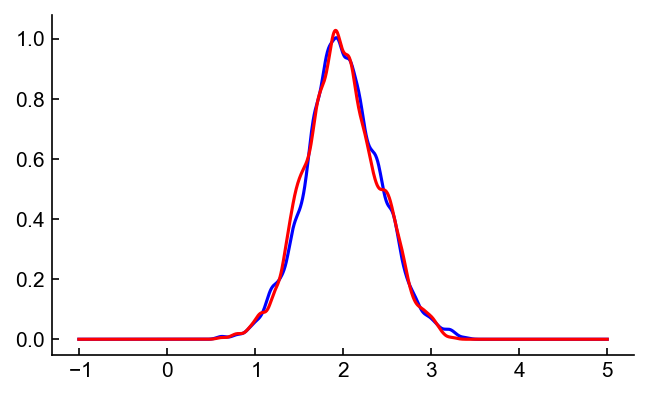

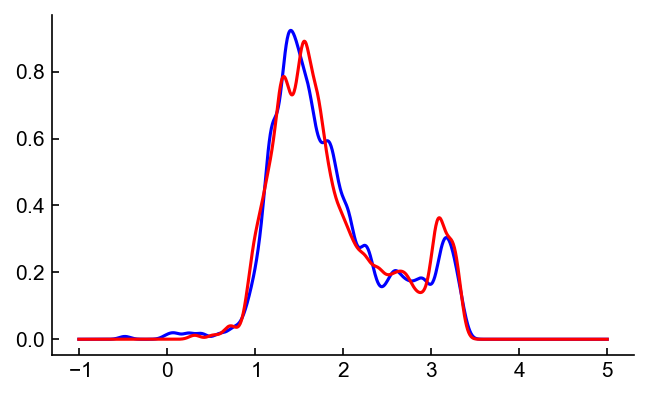

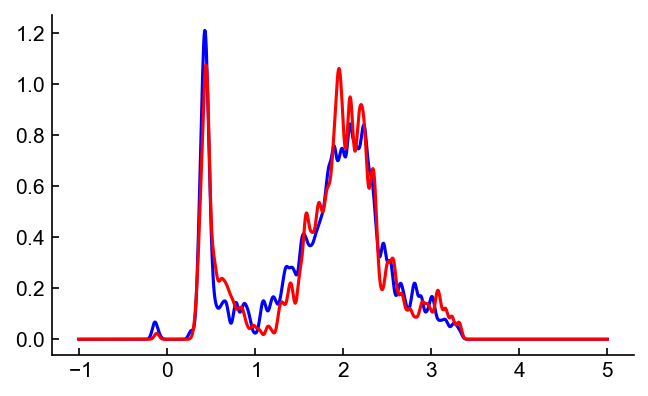

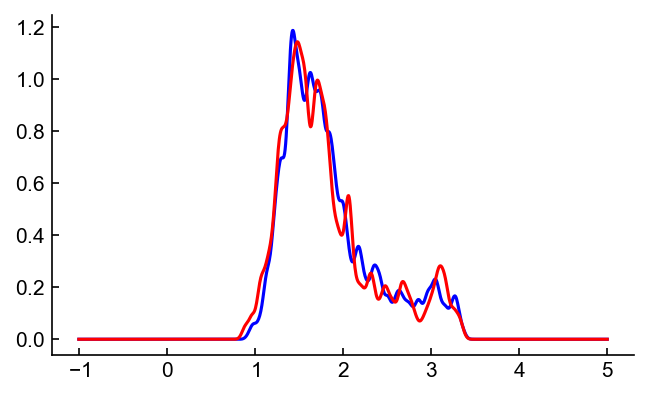

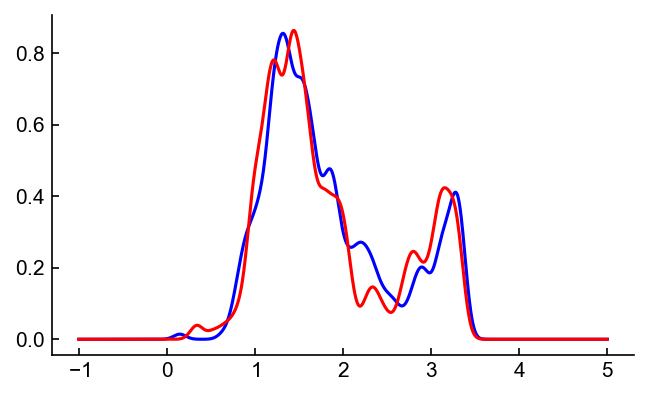

In [11]:
for clust in tqdm(sessionfile.clusters.good[0:5]):
    best_bw = ilep.sklearn_grid_search_bw(sessionfile,clust)
    folds = ilep.K_fold_strat(sessionfile,sessionfile.trim[clust].trimmed_trials,10)
    
    xmin = -1
    xmax = 5
    xrange = np.linspace(xmin,xmax,num=1000)
    TargISILibraries = np.zeros((len(xrange),len(folds)))
    NontargISILibraries = np.zeros((len(xrange),len(folds)))
    
    for K, (Train_X, Test_X) in enumerate(folds):
        model = ilep.trainDecodingAlgorithm(sessionfile,clust,best_bw,Train_X,['target_tone','nontarget_tone'])
        
        TargISILibraries[:,K] = model['target_tone'].Likelihood.evaluate(xrange)
        NontargISILibraries[:,K] = model['nontarget_tone'].Likelihood.evaluate(xrange)

    TargISILibrariesSEM = np.std(TargISILibraries,axis=1)
    TargISILibrariesMEAN = np.mean(TargISILibraries,axis=1)
    NontargISILibrariesSEM = np.std(NontargISILibraries,axis=1)
    NontargISILibrariesMEAN = np.mean(NontargISILibraries,axis=1)

    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(xrange,TargISILibrariesMEAN,color='blue')
    ax.plot(xrange,NontargISILibrariesMEAN,color='red')

#     #sessionfile
#     #clust = clustToUse
#     #bw = best_bw

#     conditions = ilep.getAllConditions(sessionfile,clust)
#     condition_names = ['target_tone','nontarget_tone']

#     model = dict()
#     for cond in condition_names:
#         model[cond] = SimpleNamespace()

#     Train_X = sessionfile.trim[clust].trimmed_trials
        
#     decoding_conditions = splitByConditions(sessionfile,clust,Train_X,condition_names)
#     for cond in decoding_conditions:
#         LogISIs,_ = getLogISIs(sessionfile,clust,decoding_conditions[cond].trials)
#         cond_KDE = LogISIsToLikelihoods(LogISIs,bw) #This is a gaussian KDE

#         model[cond].Likelihood = cond_KDE

#     xmin = -1
#     xmax = 5
#     xrange = np.linspace(xmin,xmax,num=1000)
#     fig,ax = plt.subplots(figsize=(5,3))
#     ax.plot(xrange,model['target_tone'].Likelihood.evaluate(xrange),color='blue')
#     ax.plot(xrange,model['nontarget_tone'].Likelihood.evaluate(xrange),color='red')

<ipython-input-202-b6c04c427bb5>:32: RuntimeWarning: divide by zero encountered in log10
  result = (np.log10(target) - np.log10(nontarget)) * alltrials
<ipython-input-202-b6c04c427bb5>:32: RuntimeWarning: invalid value encountered in multiply
  result = (np.log10(target) - np.log10(nontarget)) * alltrials


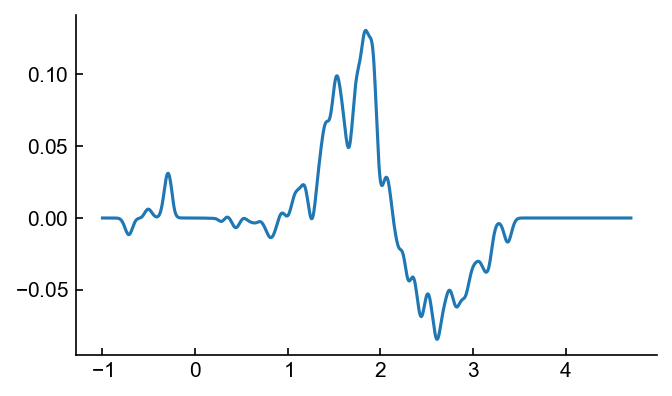

In [202]:
#sessionfile
clust = clustToUse
bw = best_bw

conditions = ilep.getAllConditions(sessionfile,clust)
condition_names = ['all_trials','target_tone','nontarget_tone']

model = dict()
for cond in condition_names:
    model[cond] = SimpleNamespace()
        
decoding_conditions = splitByConditions(sessionfile,clust,Train_X,condition_names)
for cond in decoding_conditions:
    LogISIs,_ = getLogISIs(sessionfile,clust,decoding_conditions[cond].trials)
    cond_KDE = LogISIsToLikelihoods(LogISIs,bw) #This is a gaussian KDE
    
    model[cond].Likelihood = cond_KDE

xmin = -1
xmax = 5
xrange = np.linspace(xmin,xmax,num=1000)
fig,ax = plt.subplots(figsize=(5,3))

target = model['target_tone'].Likelihood.evaluate(xrange)
nontarget = model['nontarget_tone'].Likelihood.evaluate(xrange)
alltrials = model['all_trials'].Likelihood.evaluate(xrange)
#result = (np.log10(target) - np.log10(nontarget)) / np.log10(alltrials)

#print(np.sort(np.unique(target)))
#ax.plot((target))

result = (np.log10(target) - np.log10(nontarget)) * alltrials
result2 = target-nontarget
#result = (result-0.5)*2
#result = (target-0.5)*2

ax.plot(xrange,result)
#ax.plot(xrange,result2)

In [12]:
def CalculatePosterior(prior,posmodel,negmodel,logISI):
    return prior + np.log10(posmodel.Likelihood.evaluate(logISI)) - np.log10(negmodel.Likelihood.evaluate(logISI))

<ipython-input-42-ab1b61b53fe0>:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(figsize=(5,3))


correct  : 129
incorrect: 109
PC: 0.5458412169931076


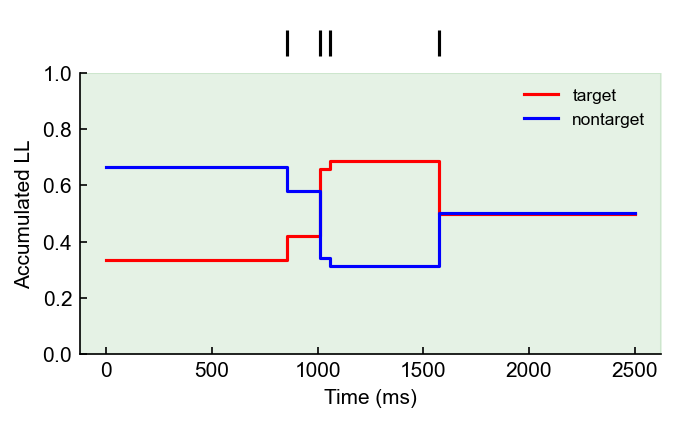

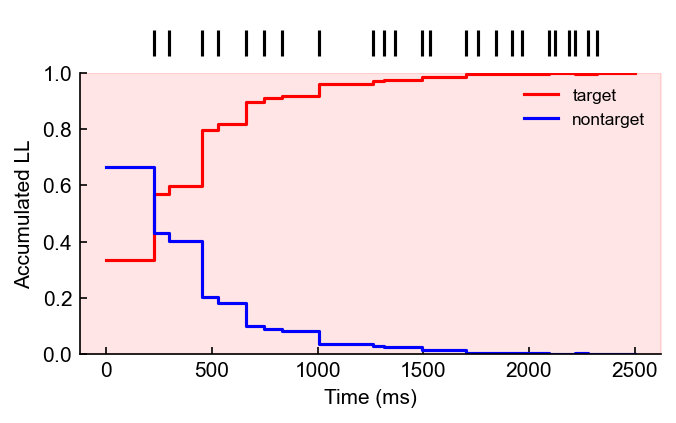

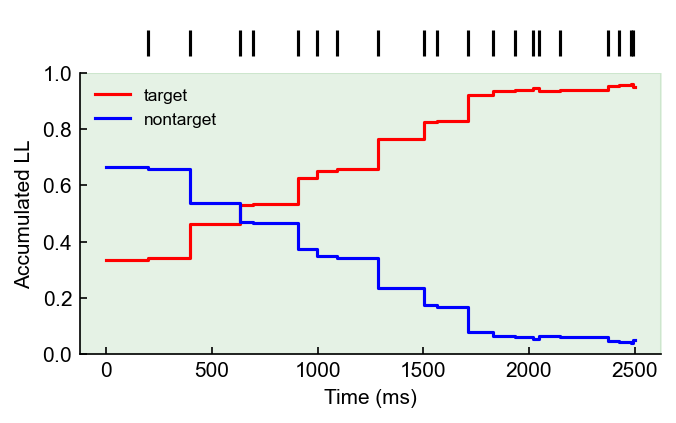

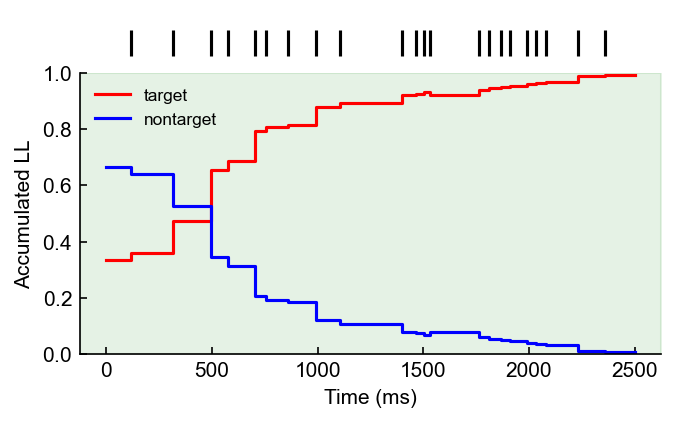

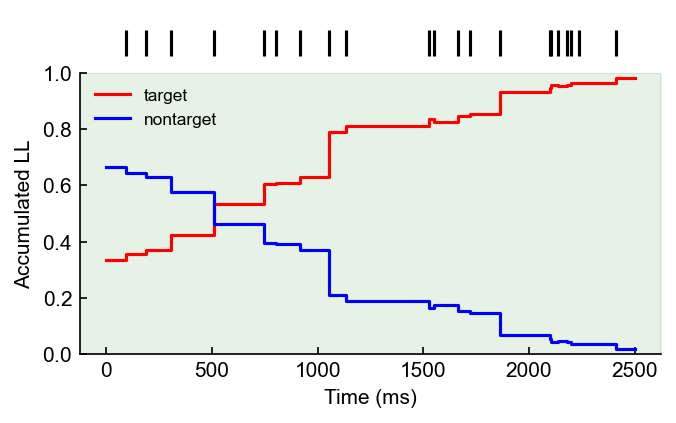

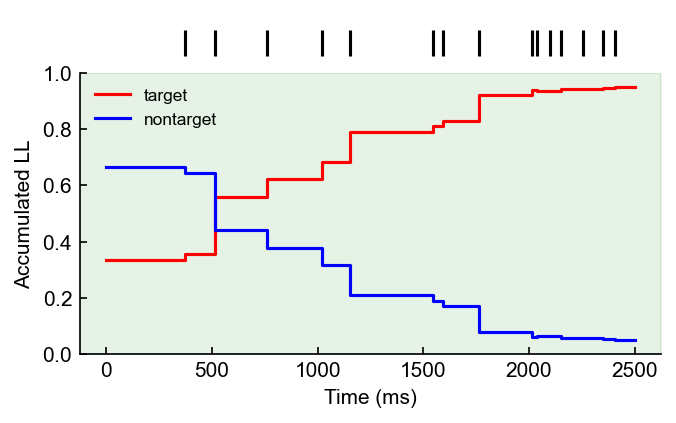

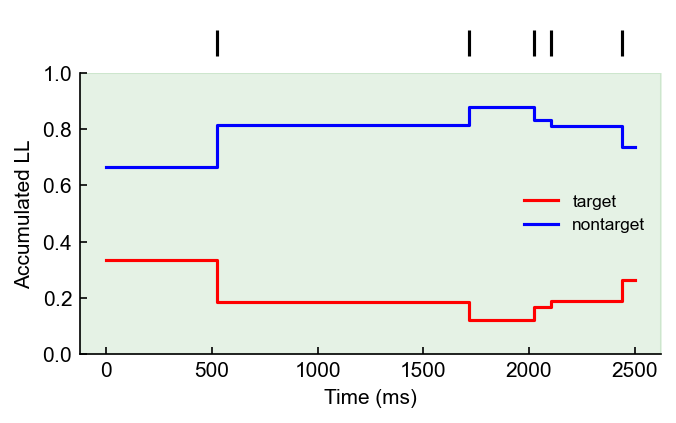

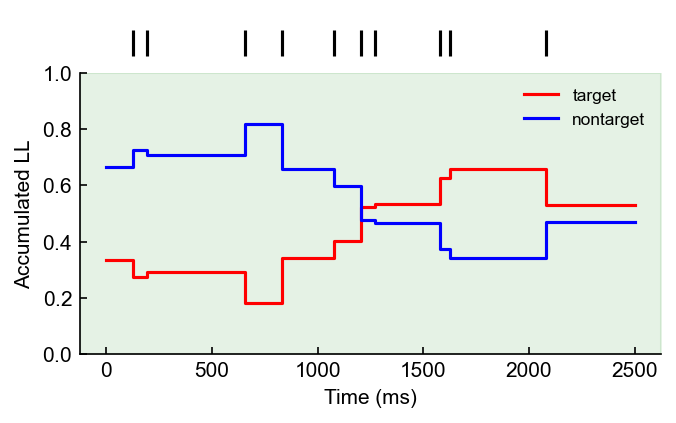

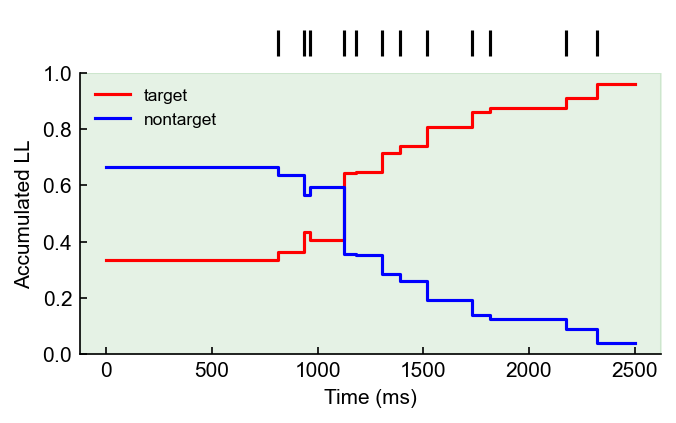

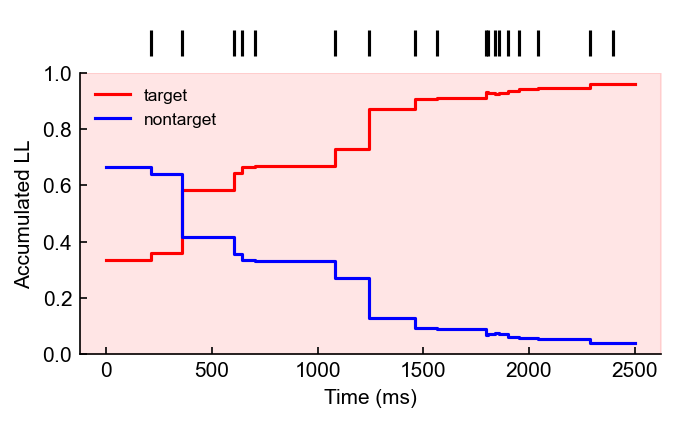

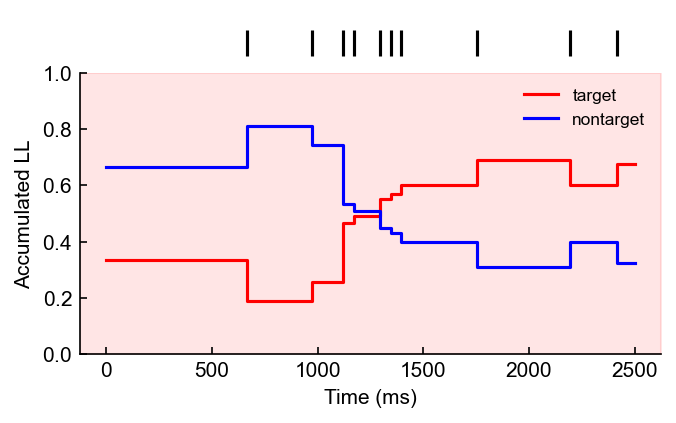

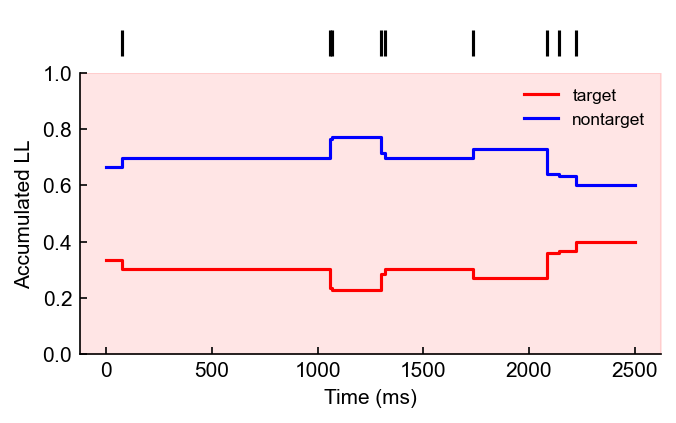

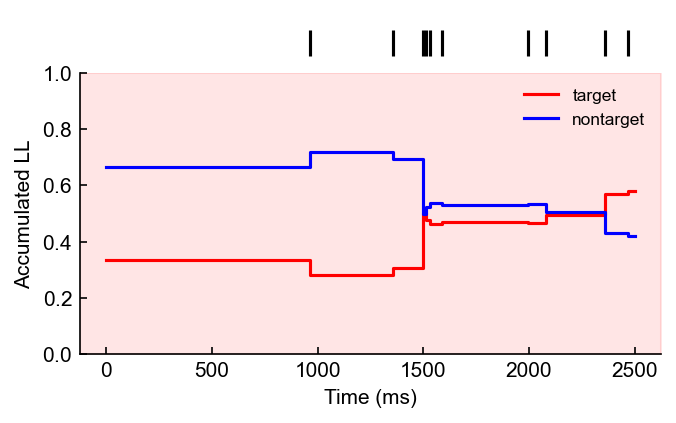

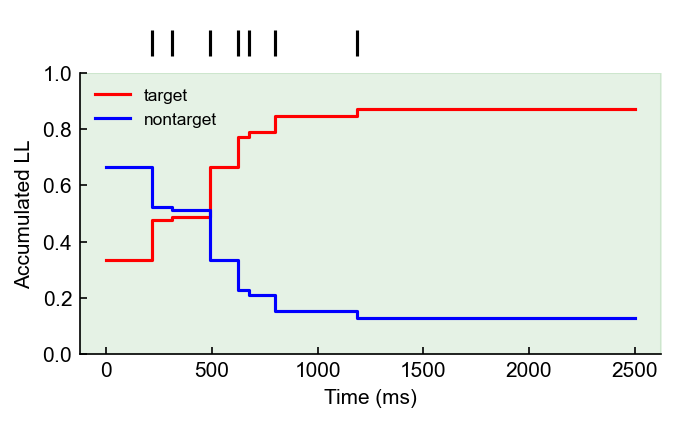

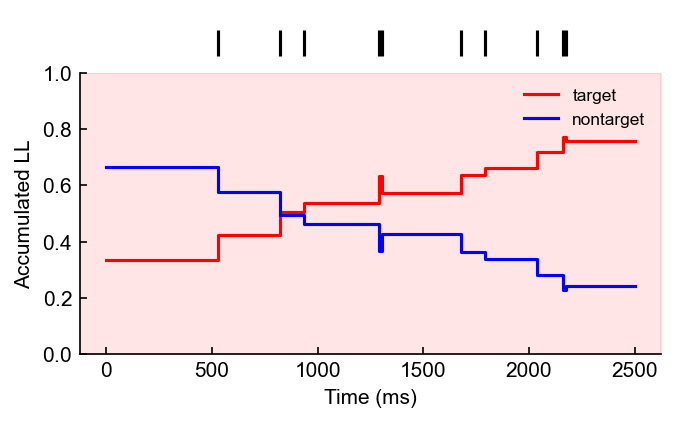

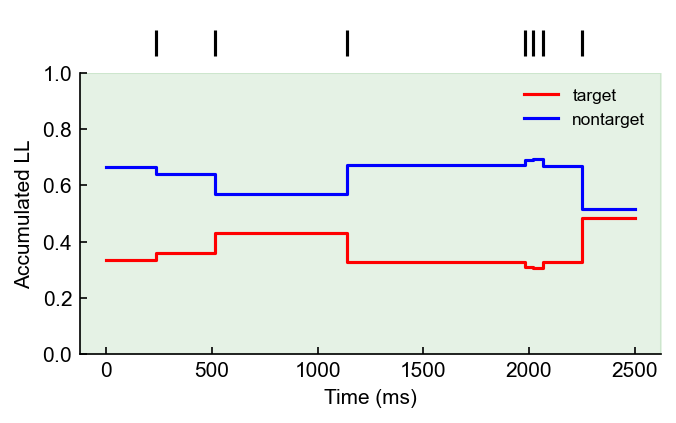

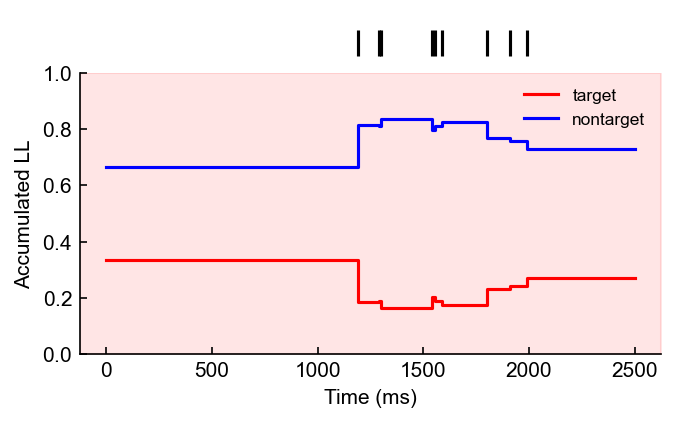

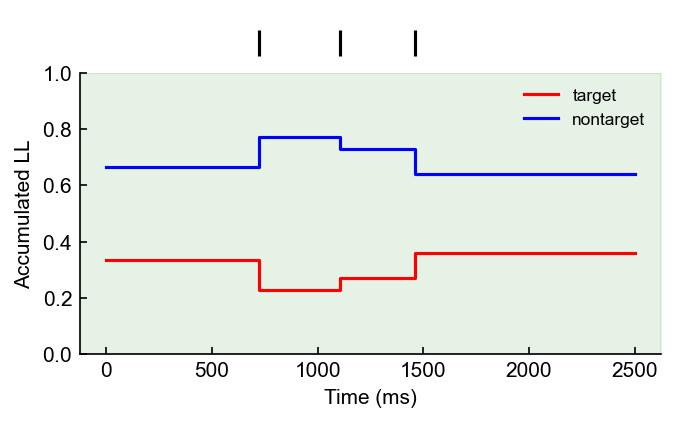

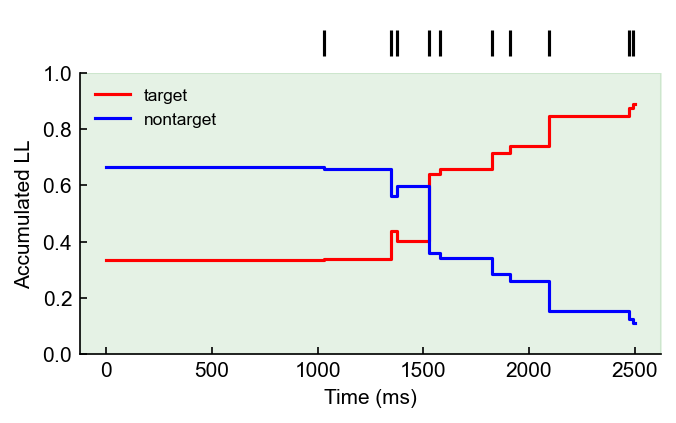

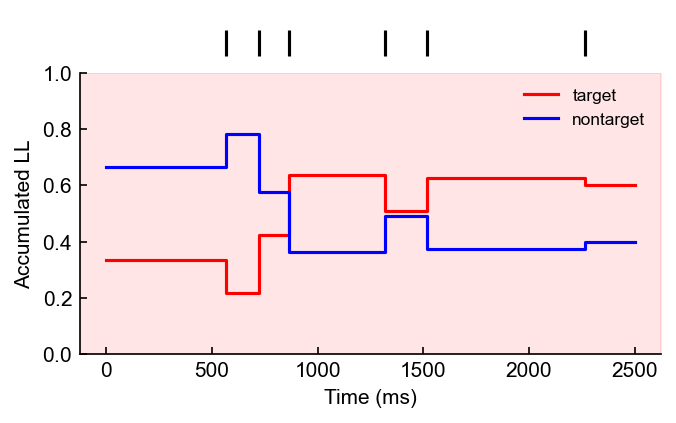

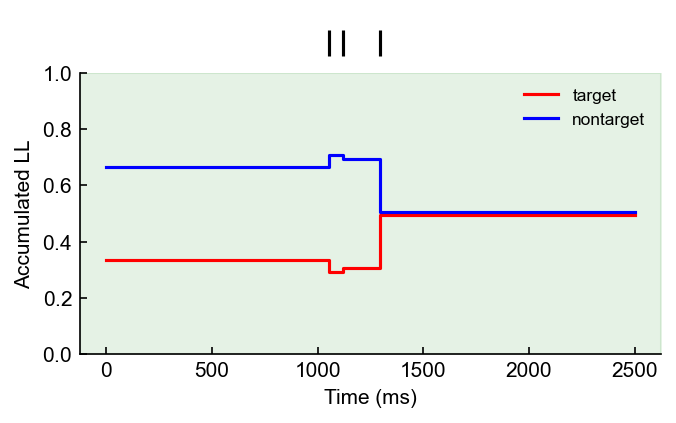

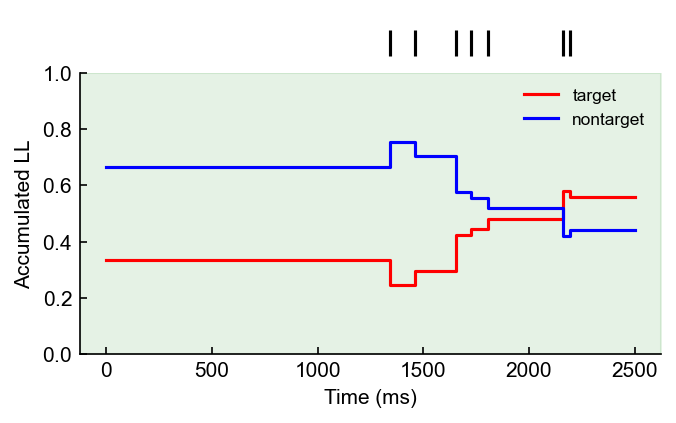

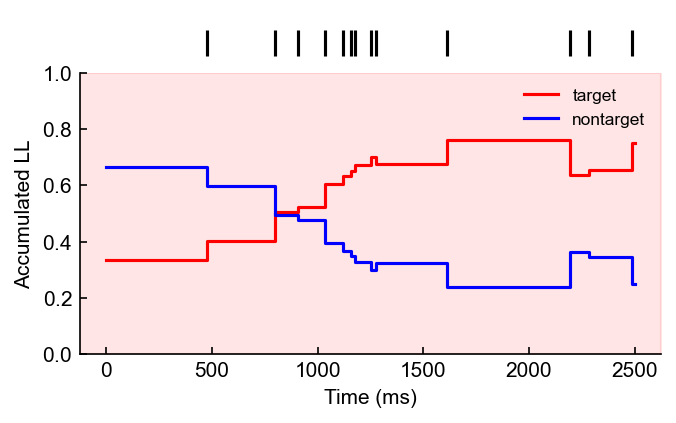

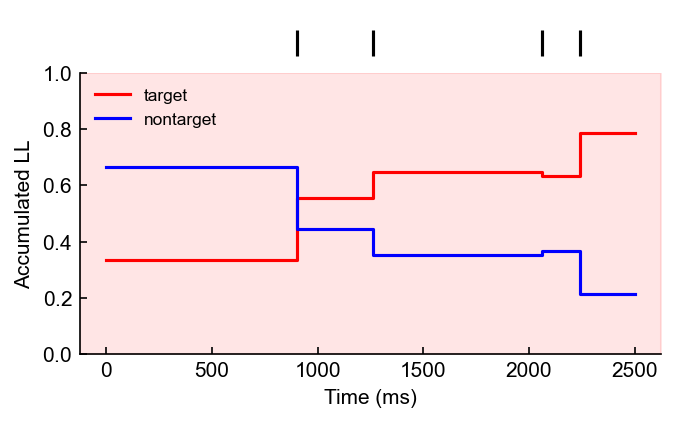

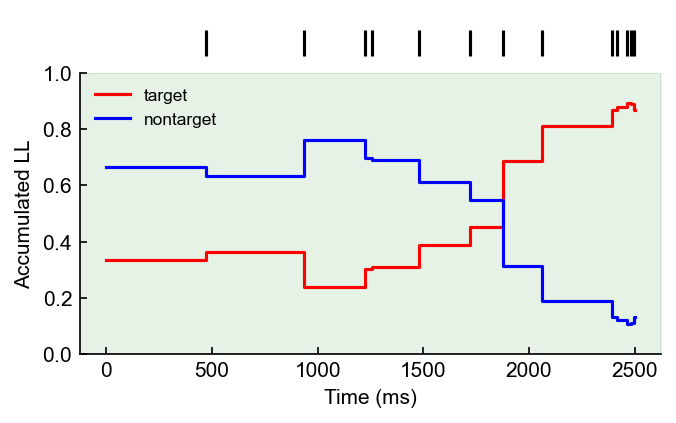

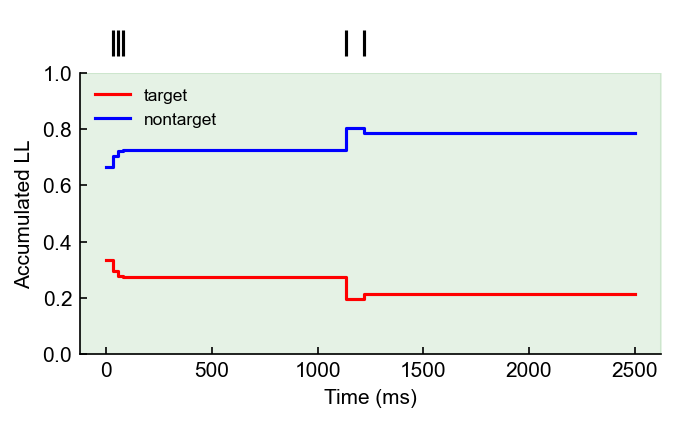

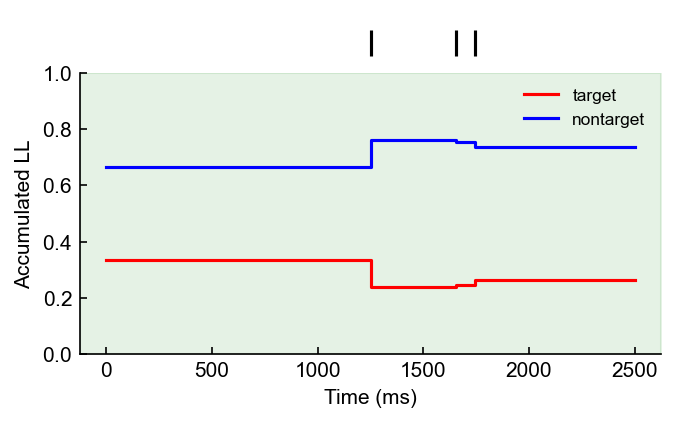

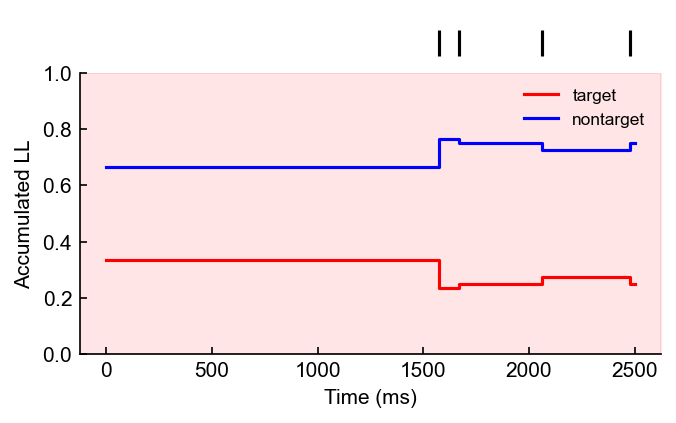

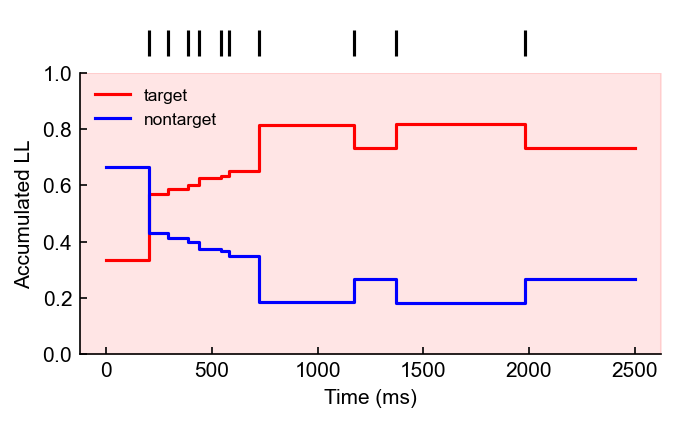

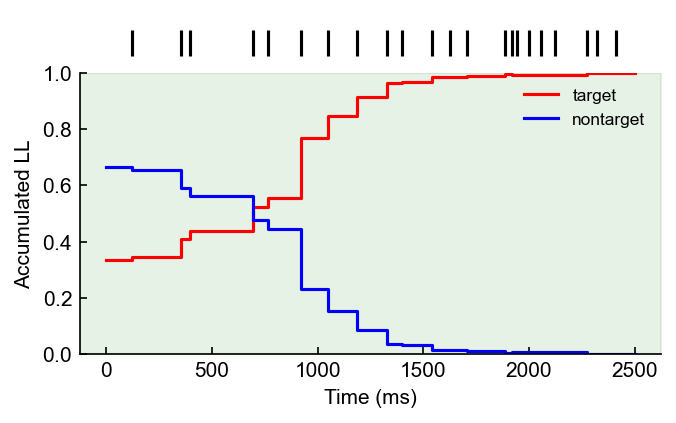

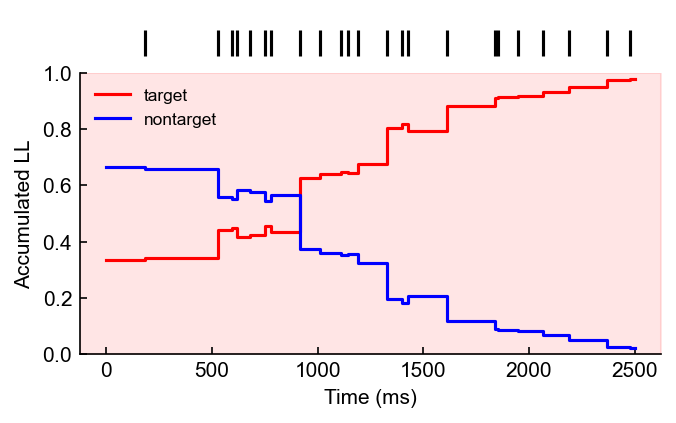

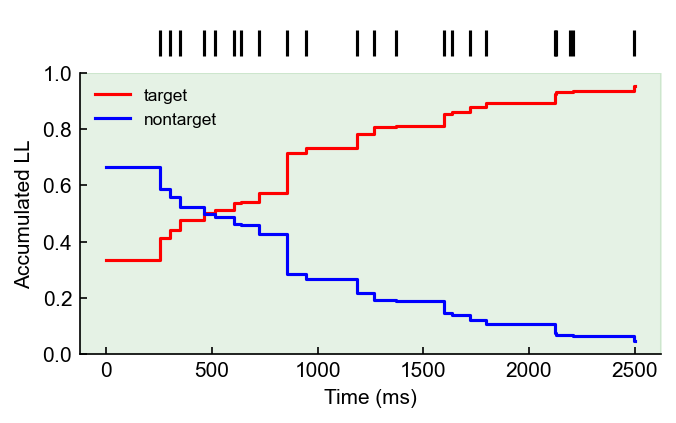

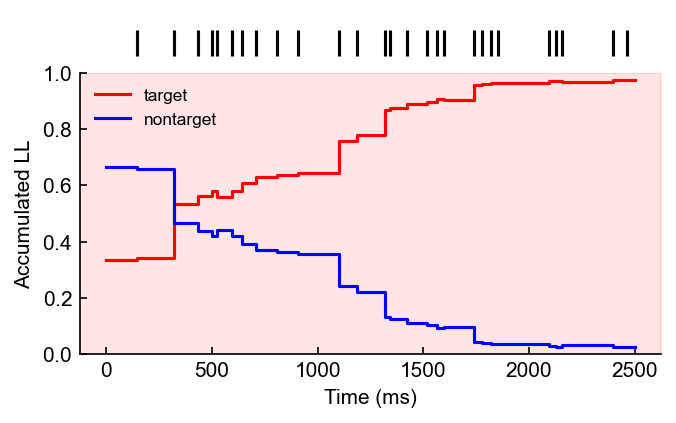

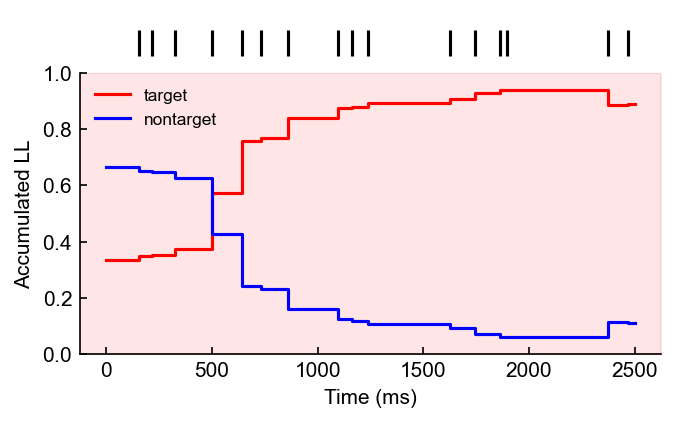

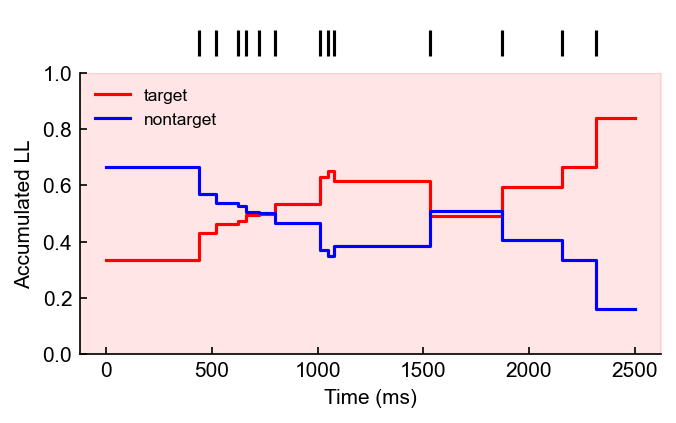

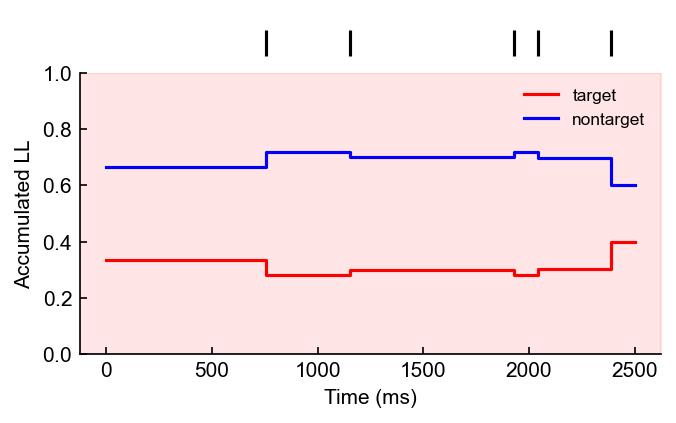

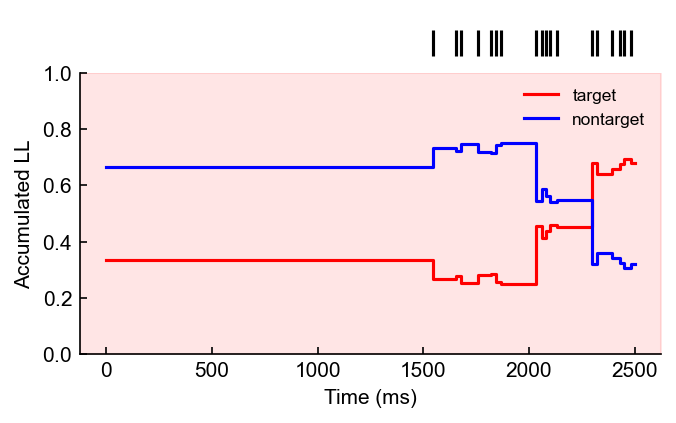

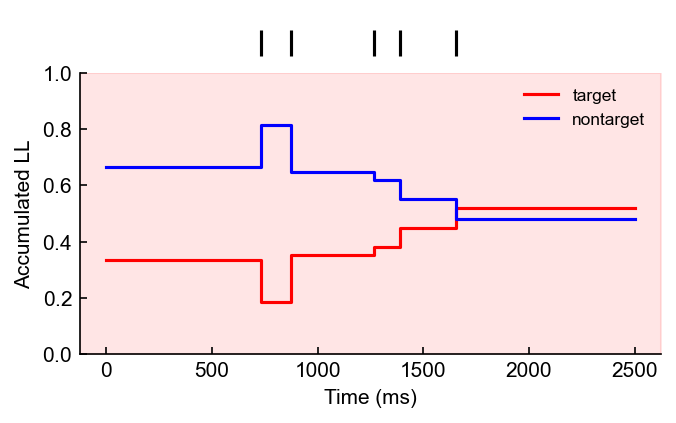

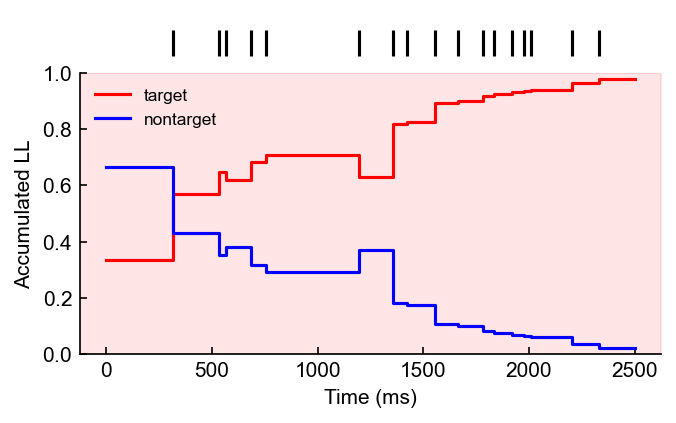

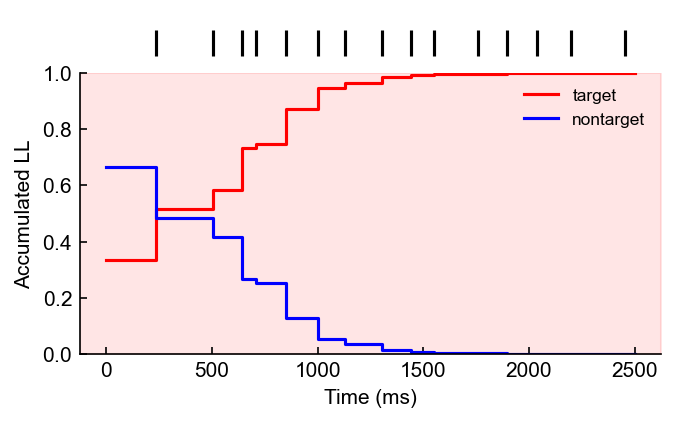

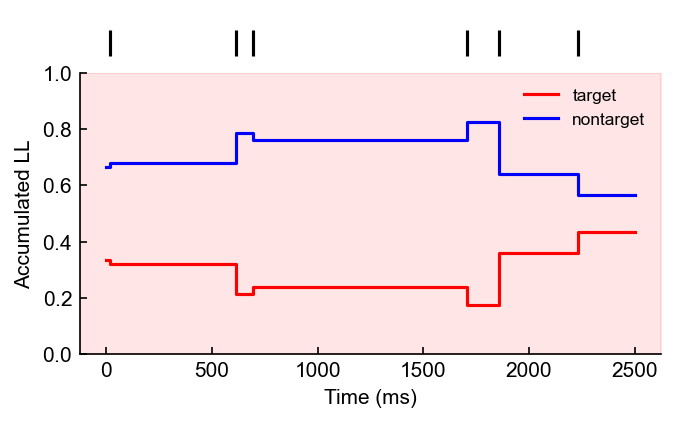

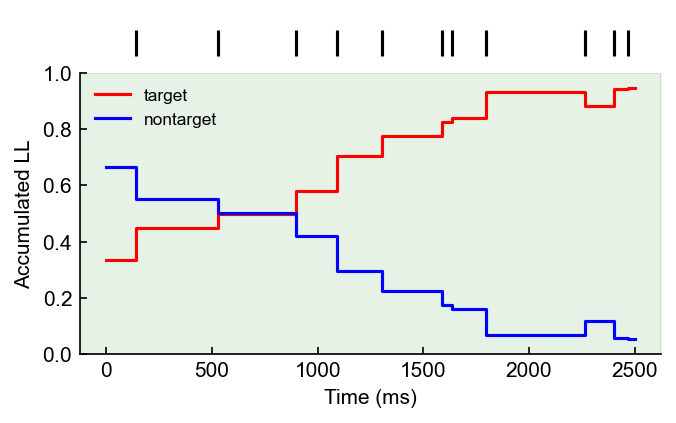

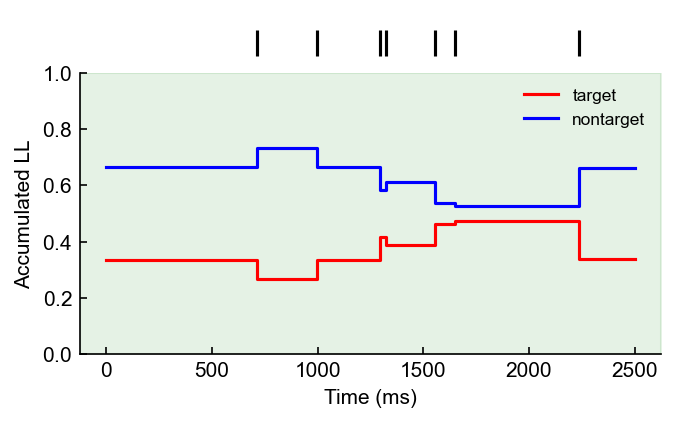

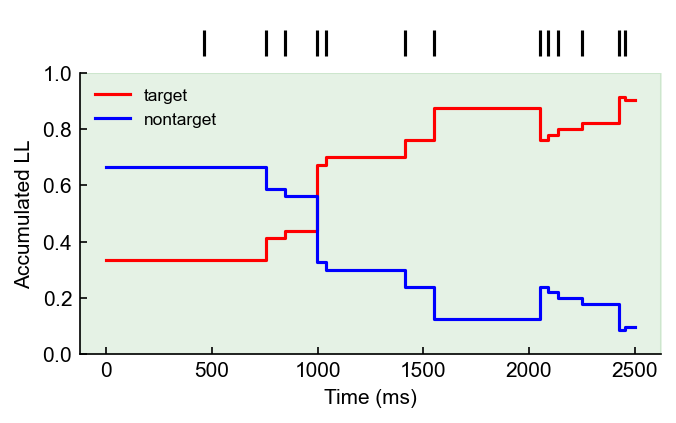

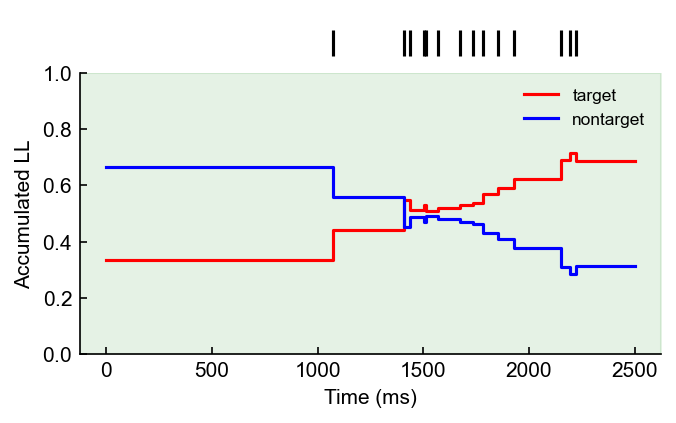

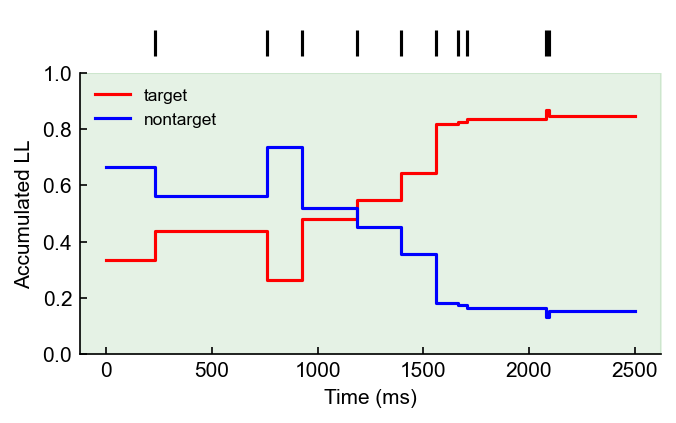

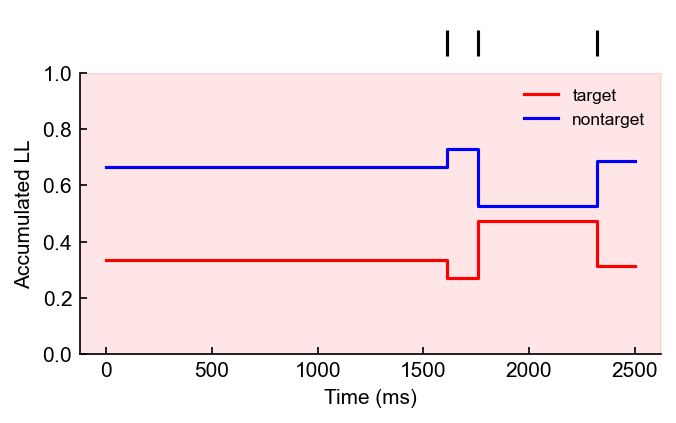

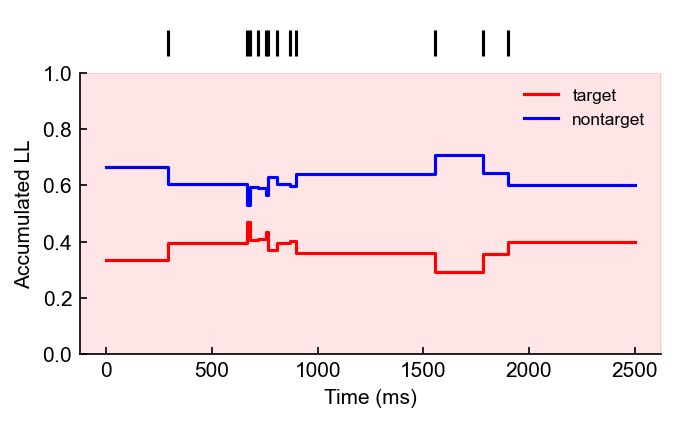

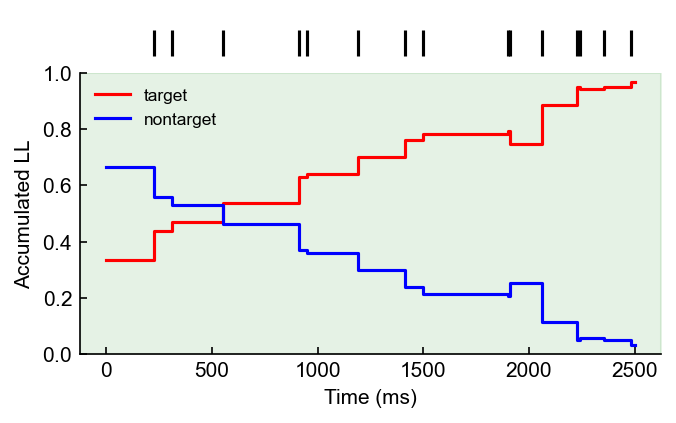

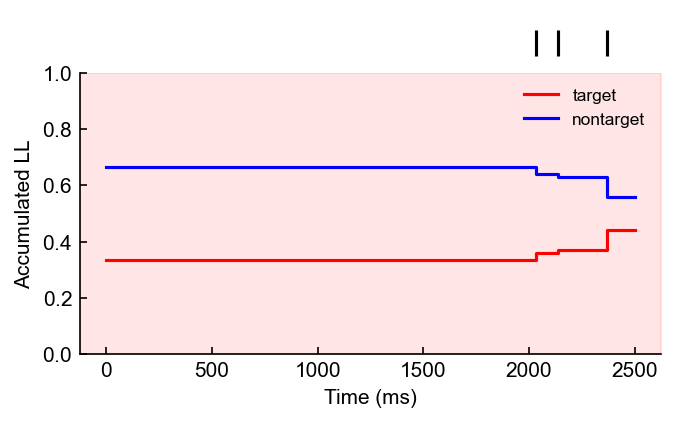

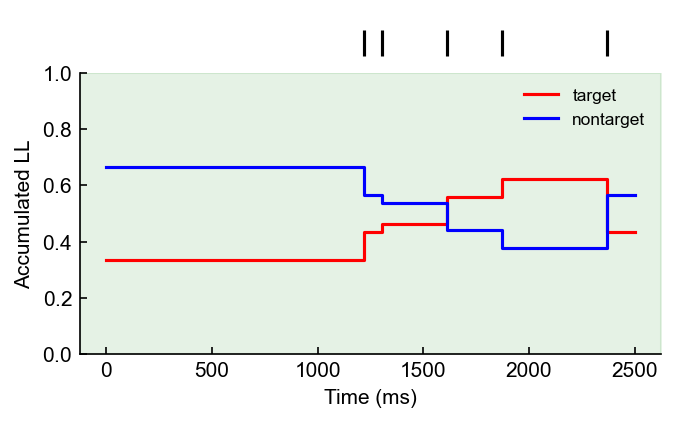

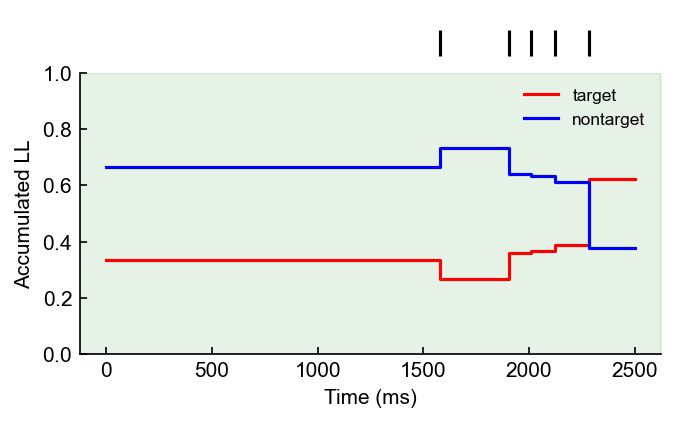

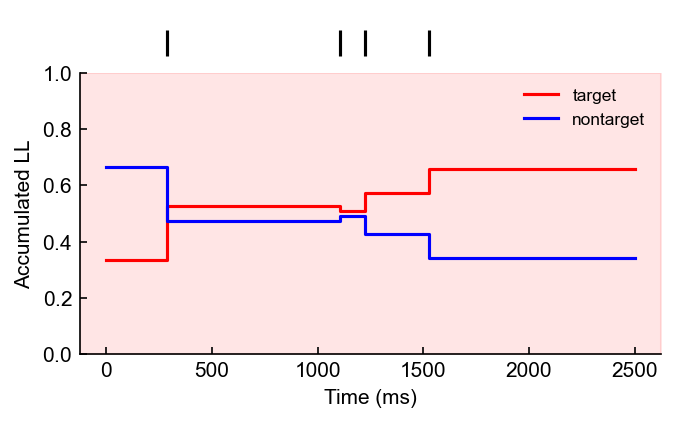

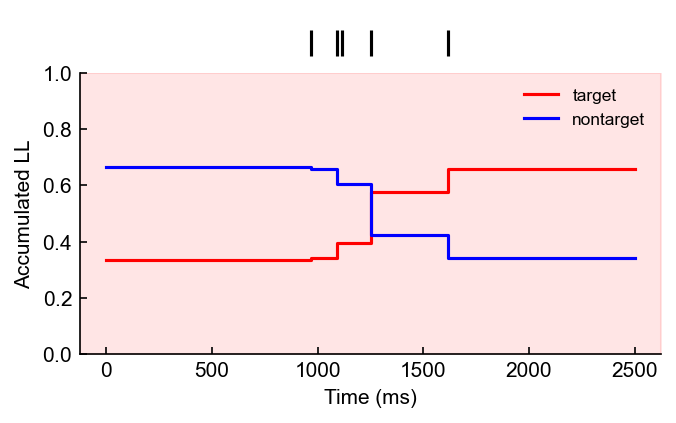

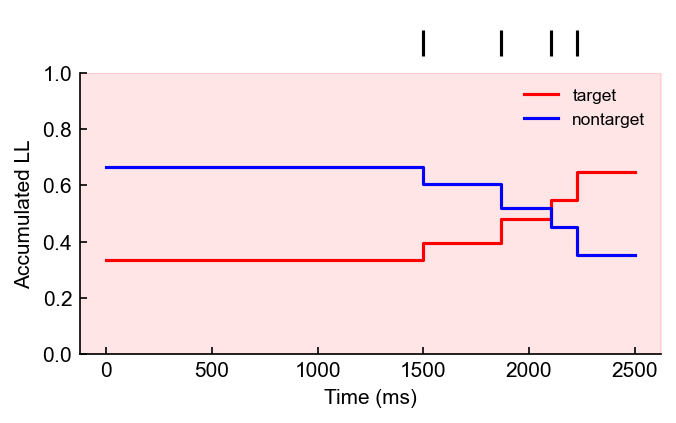

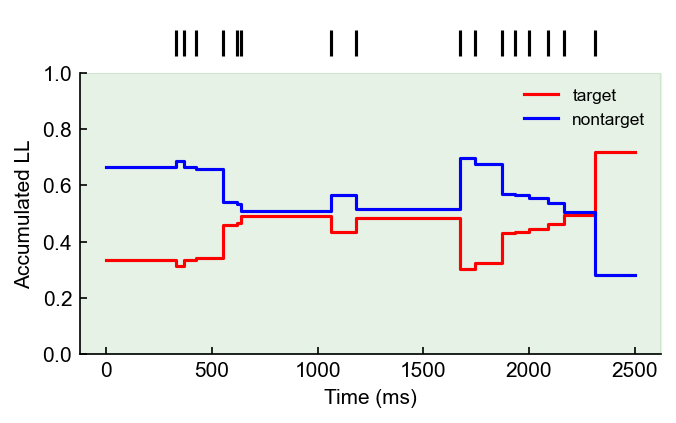

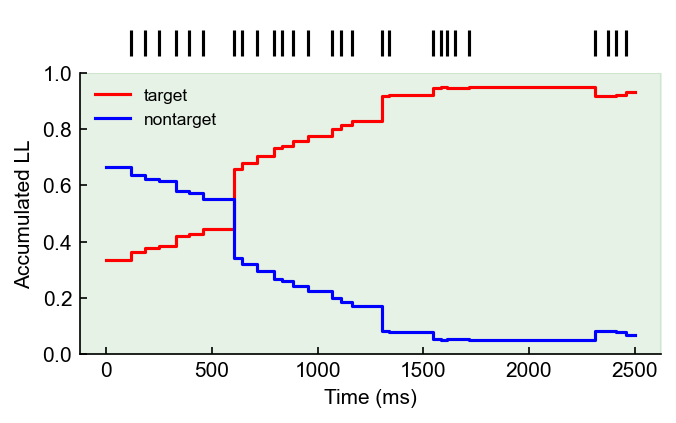

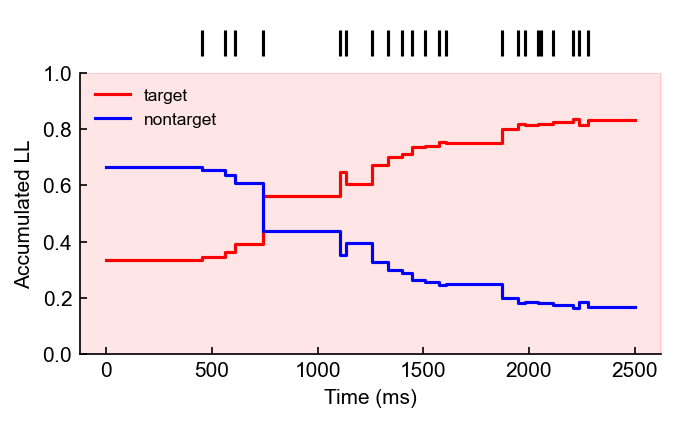

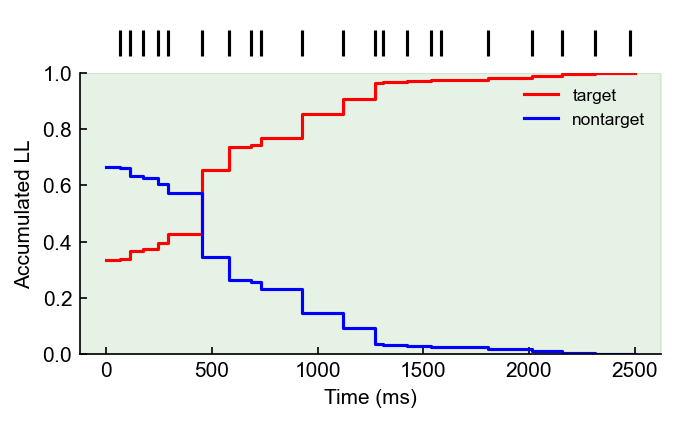

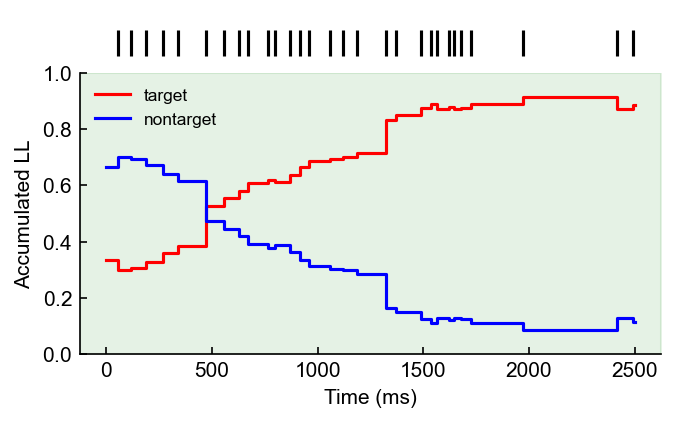

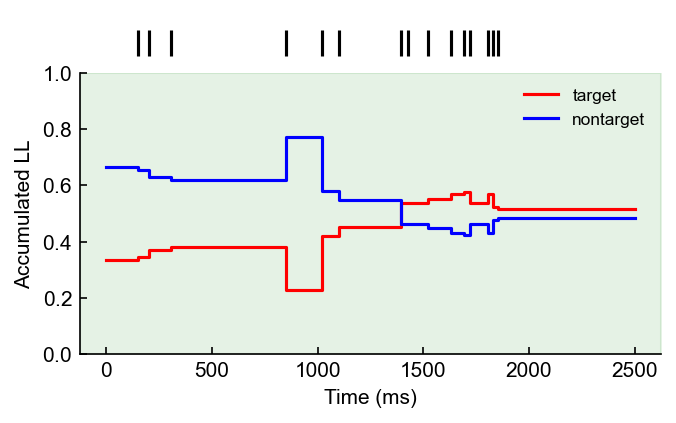

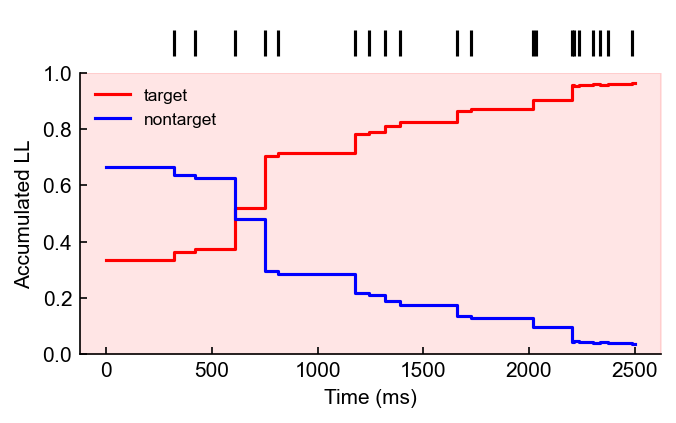

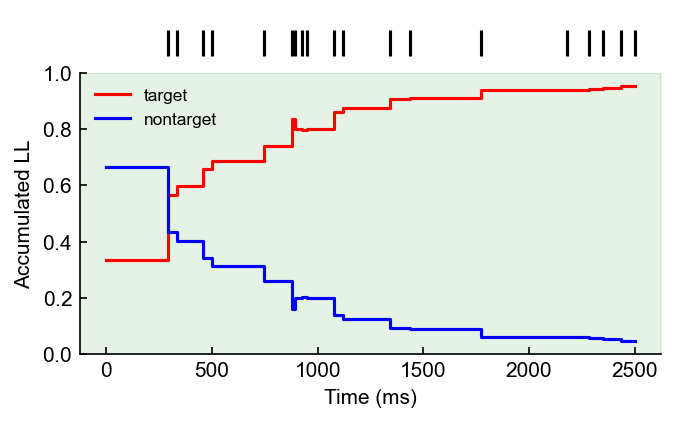

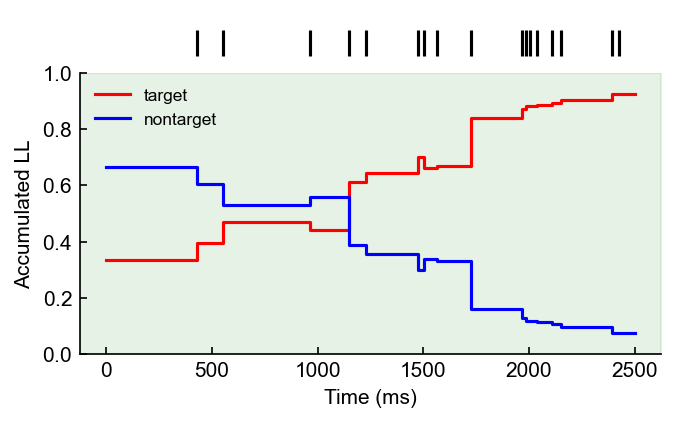

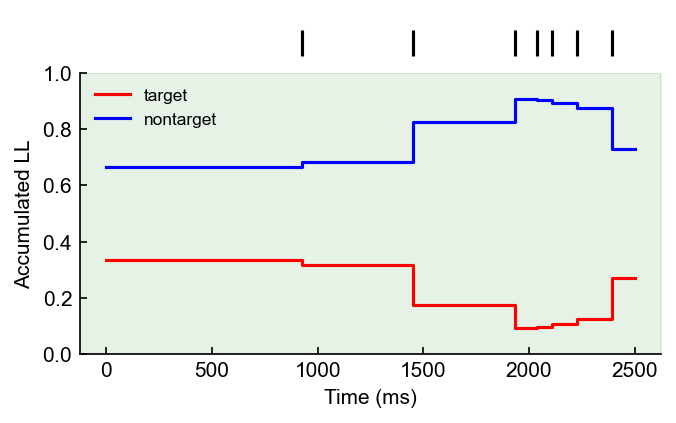

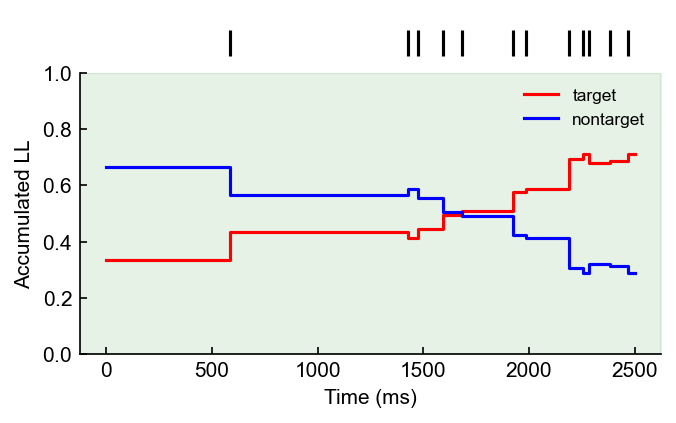

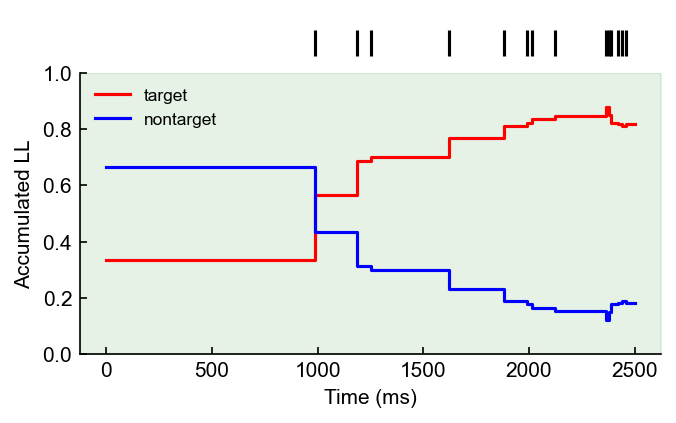

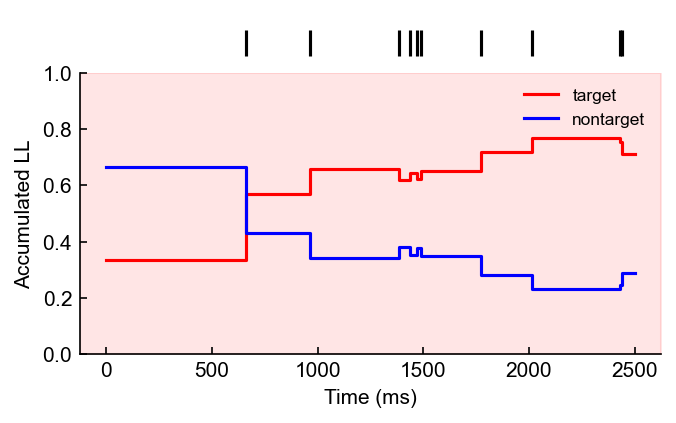

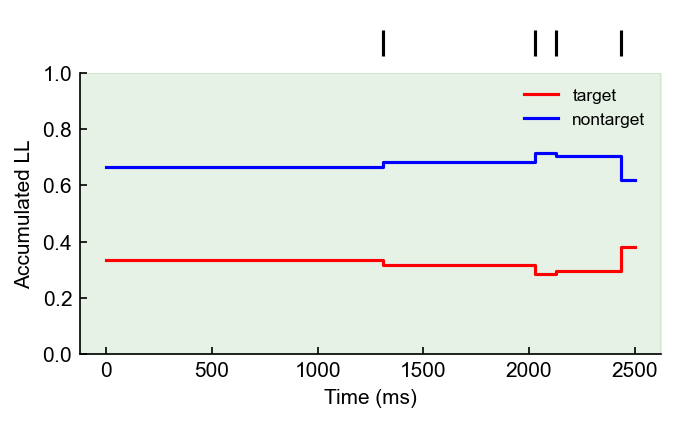

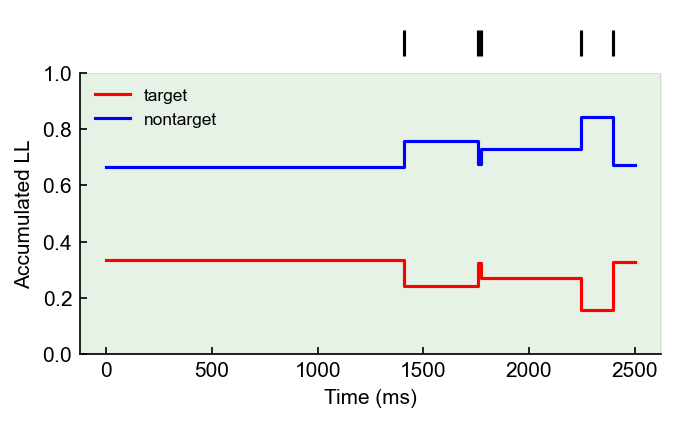

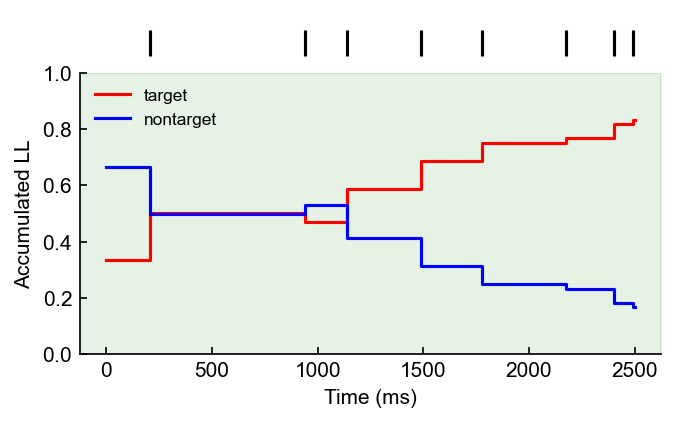

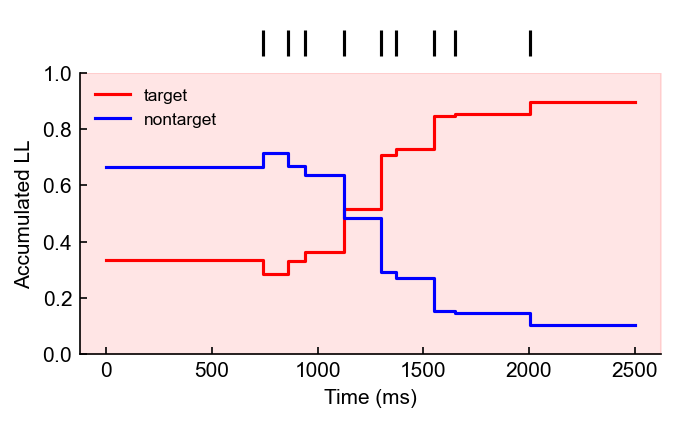

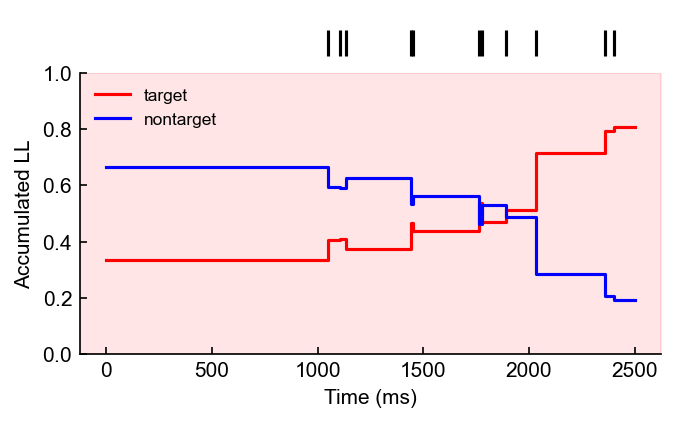

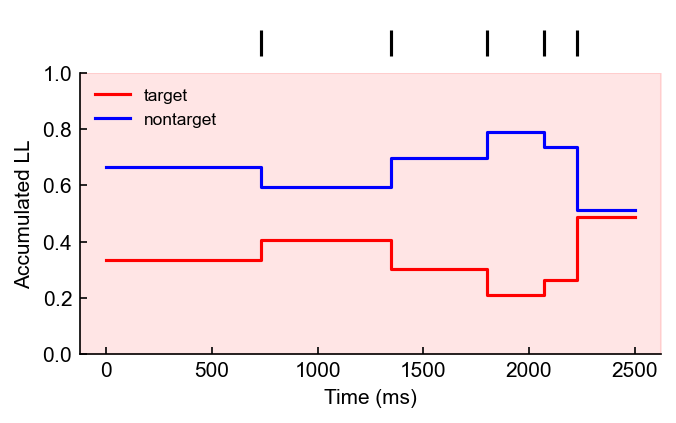

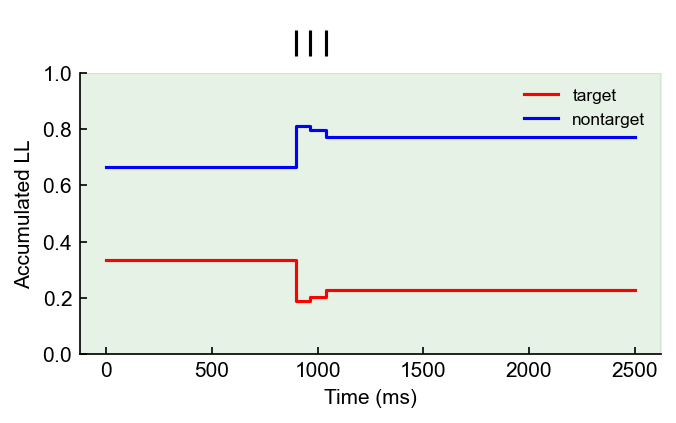

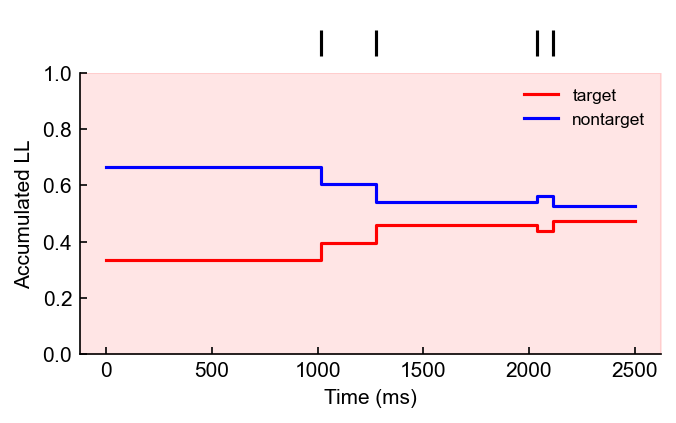

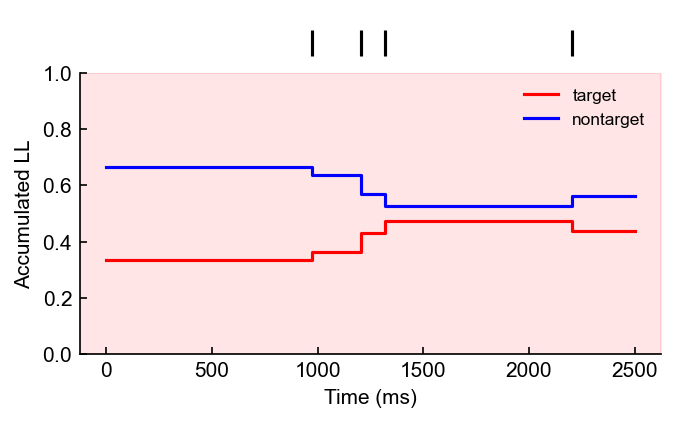

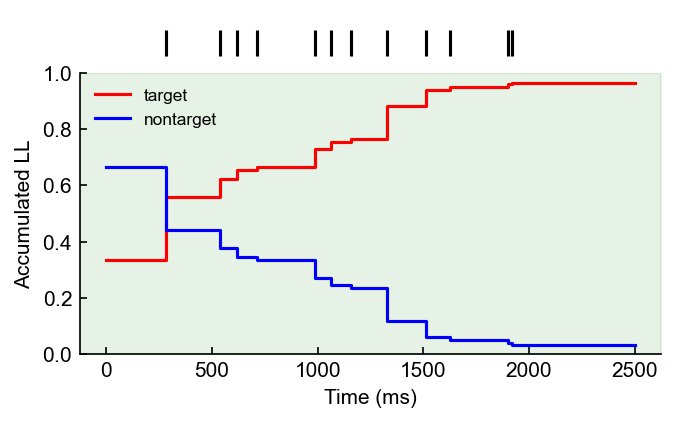

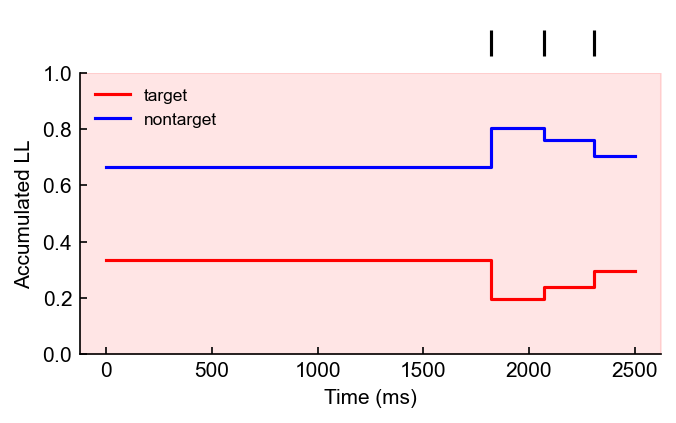

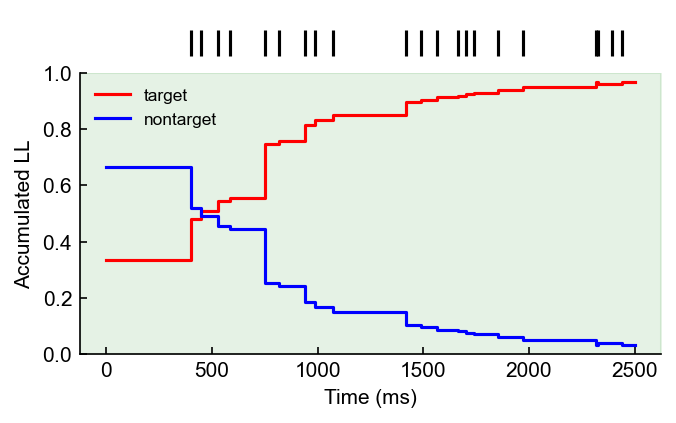

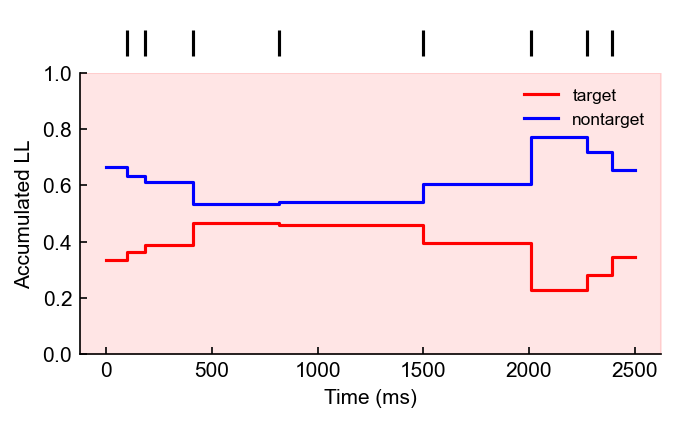

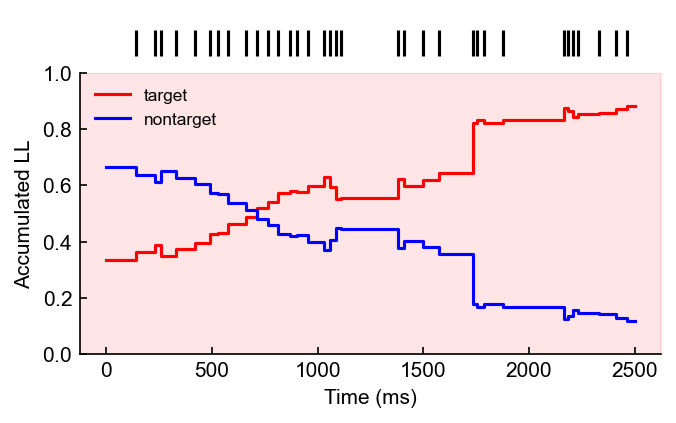

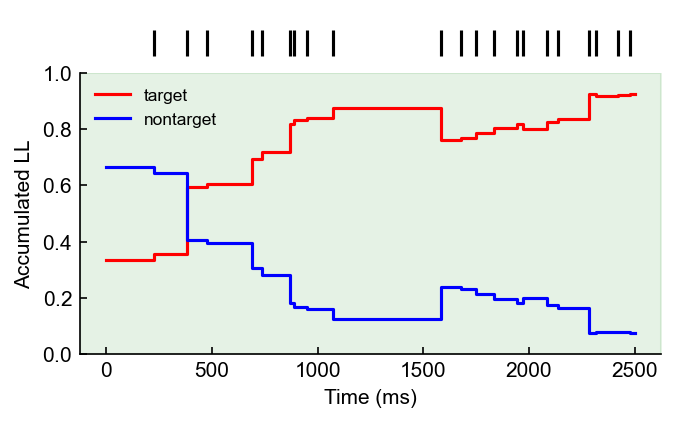

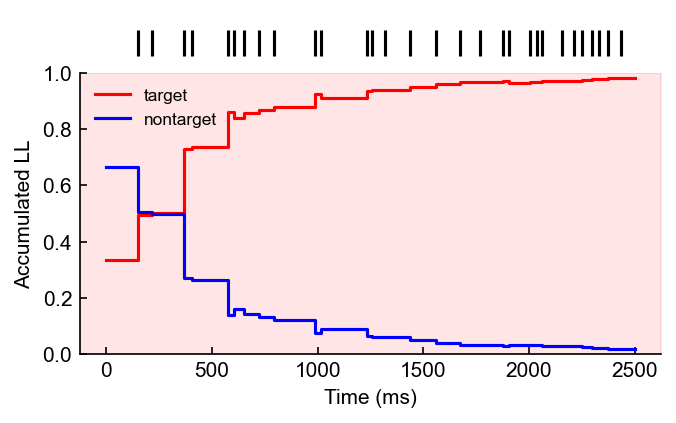

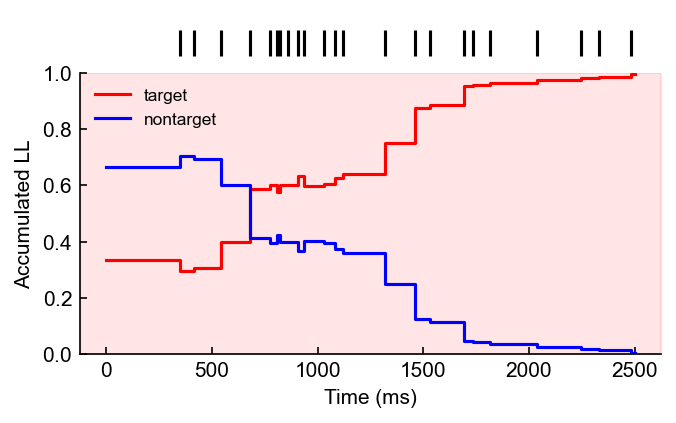

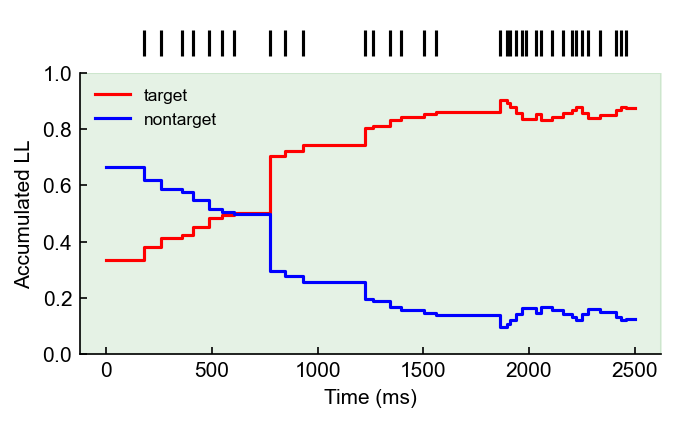

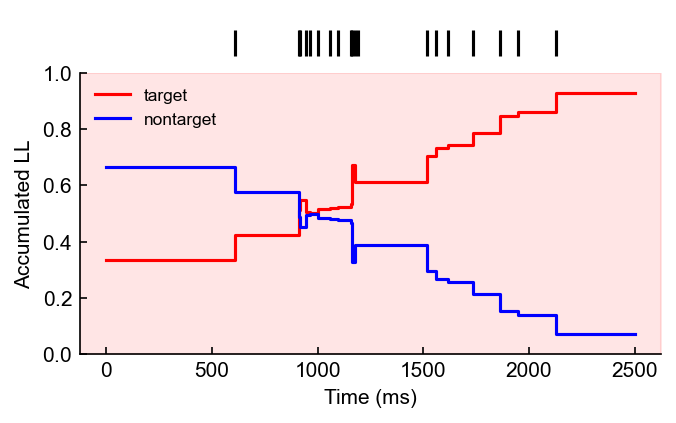

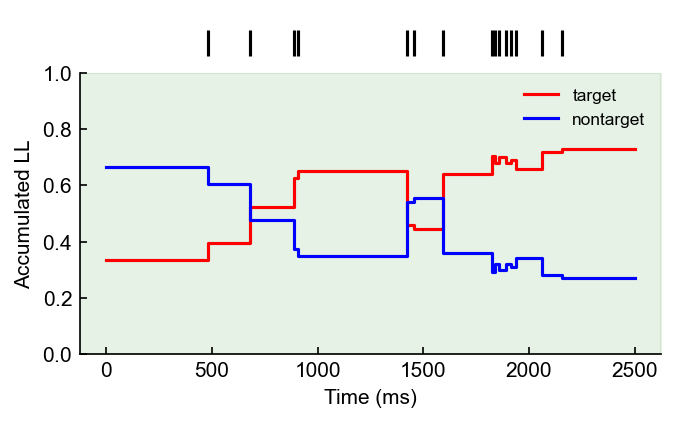

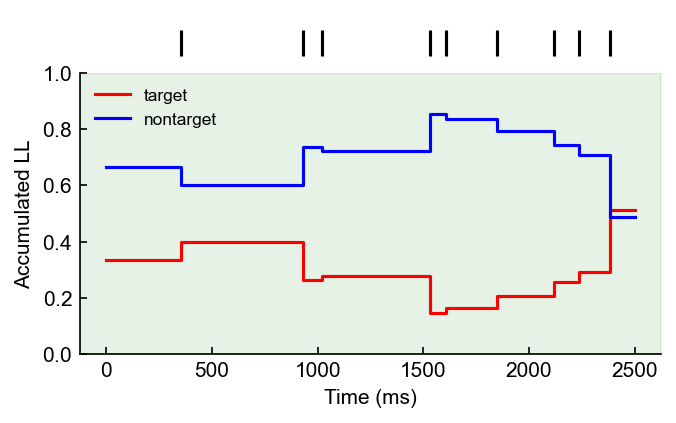

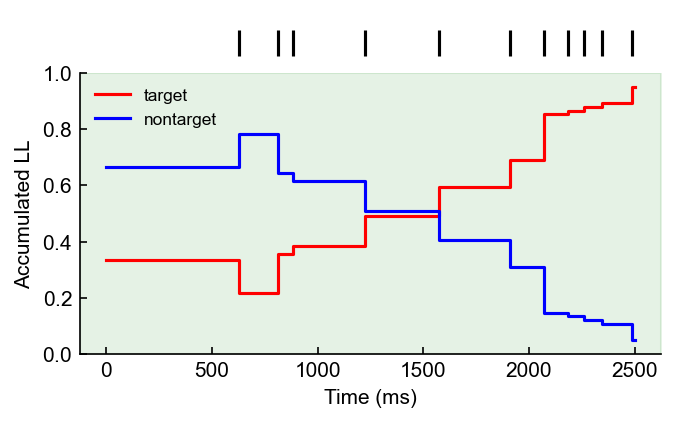

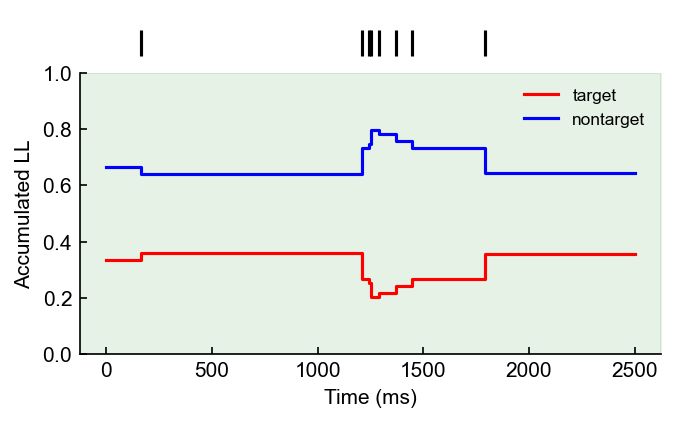

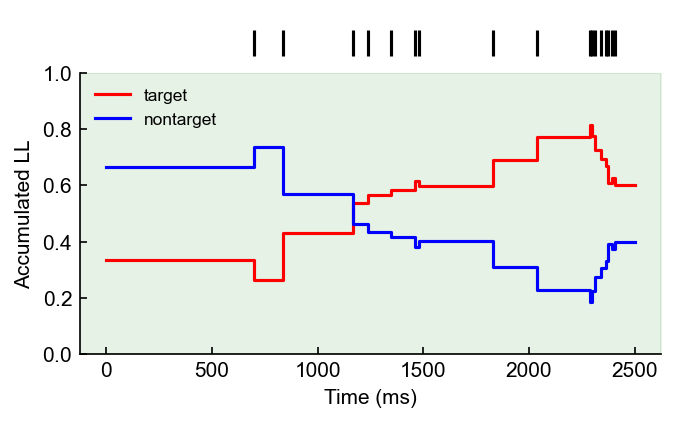

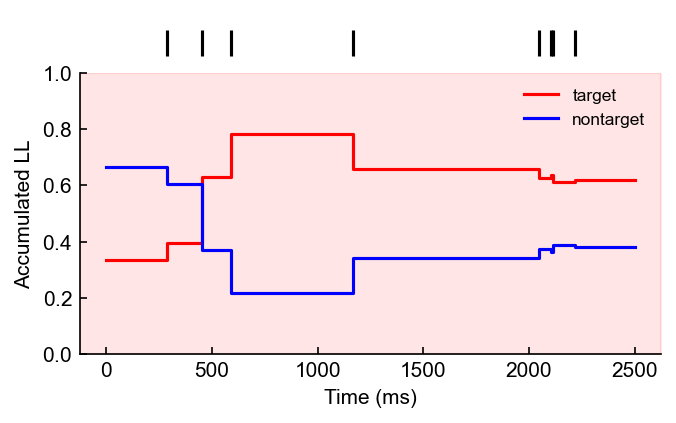

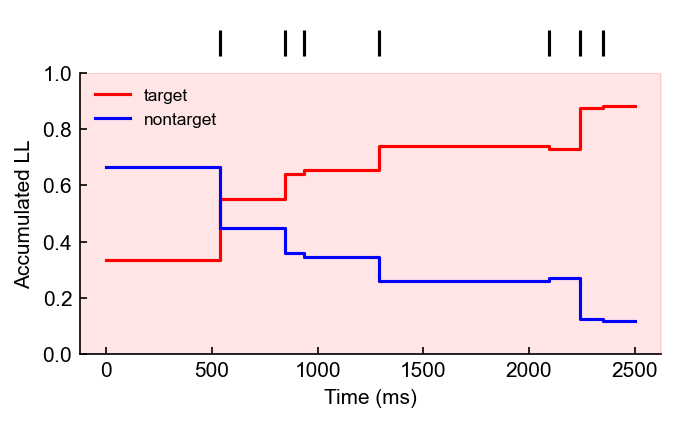

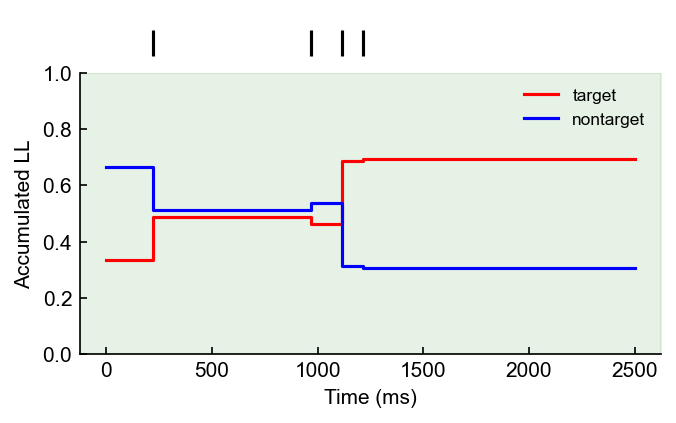

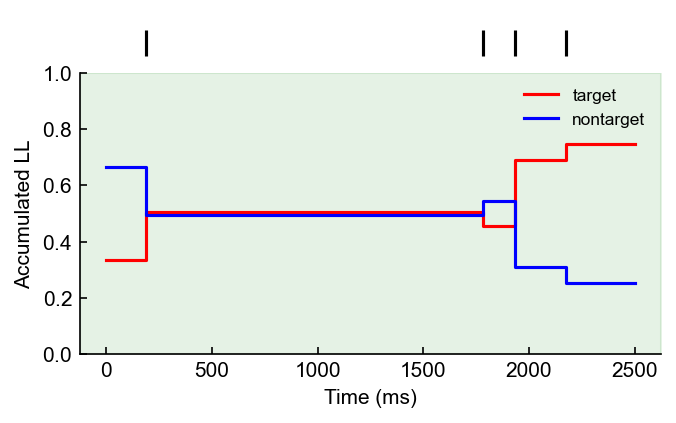

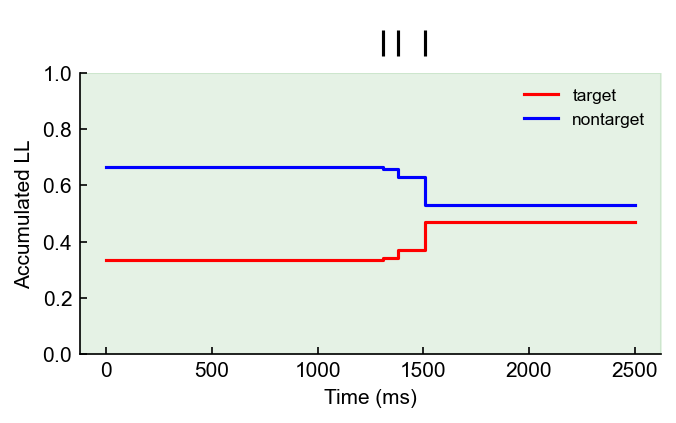

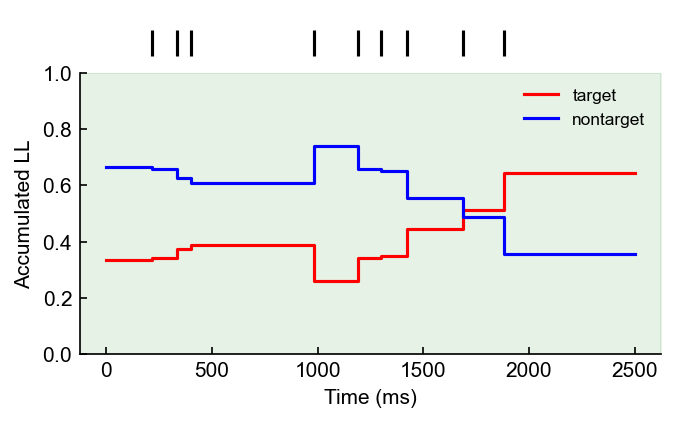

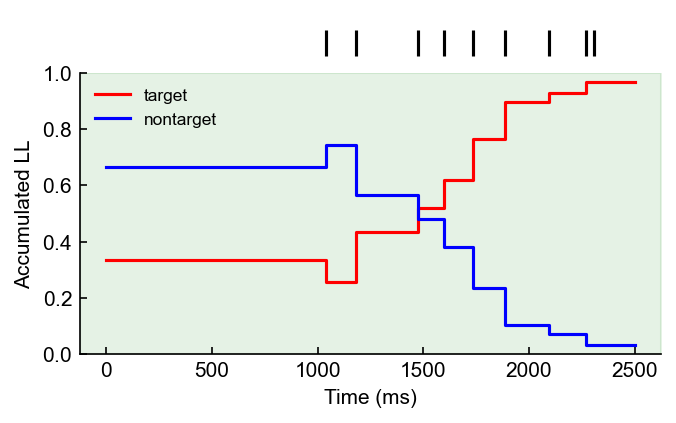

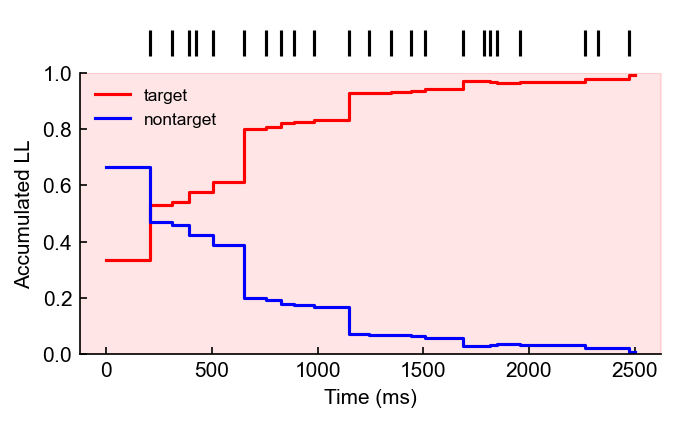

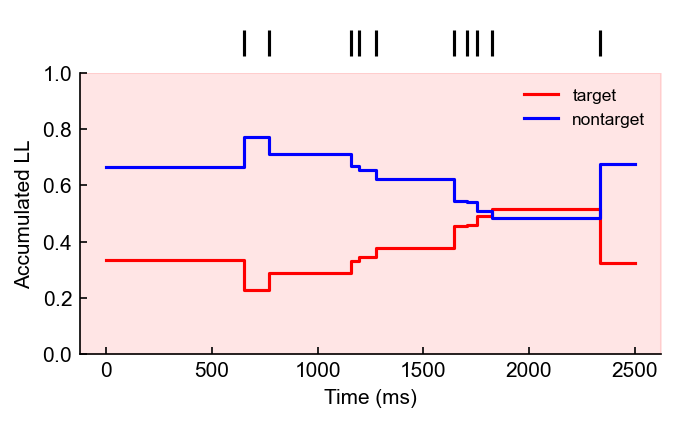

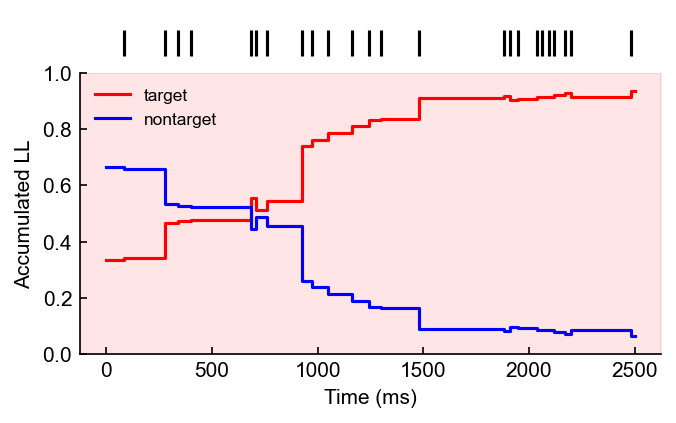

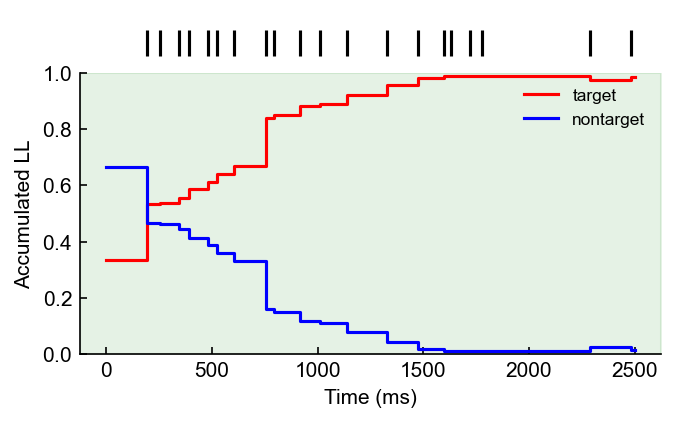

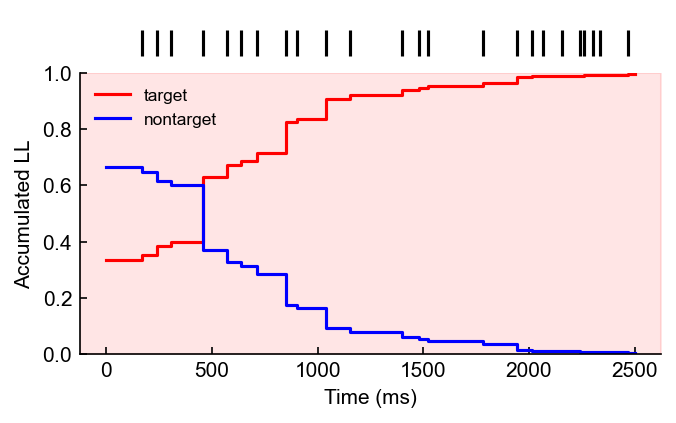

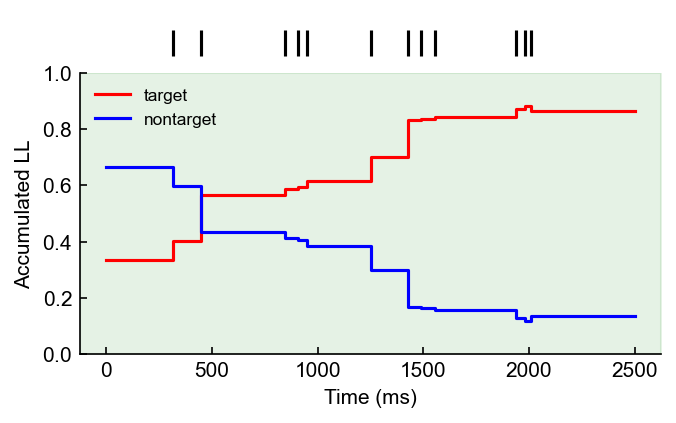

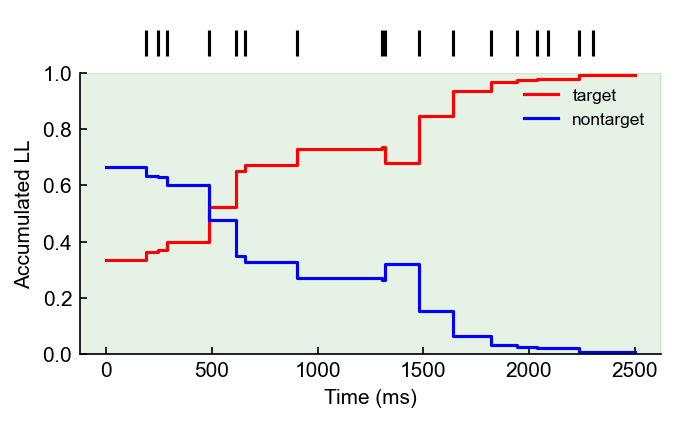

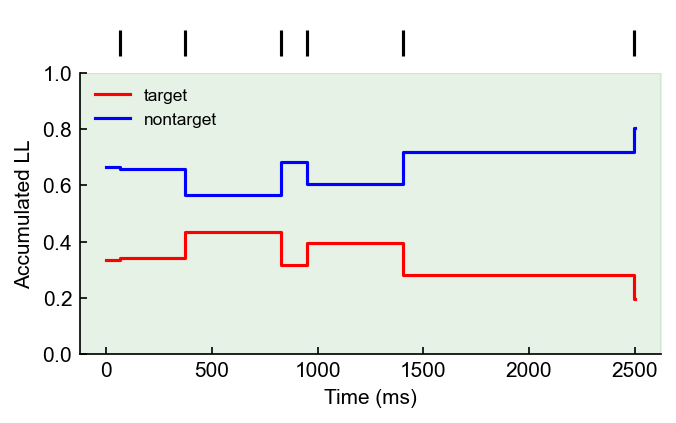

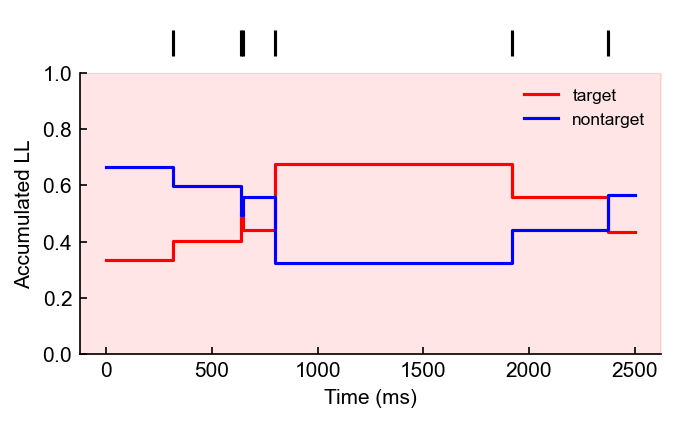

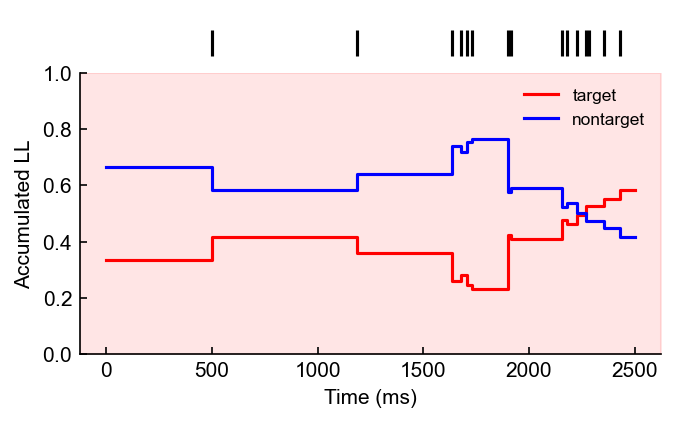

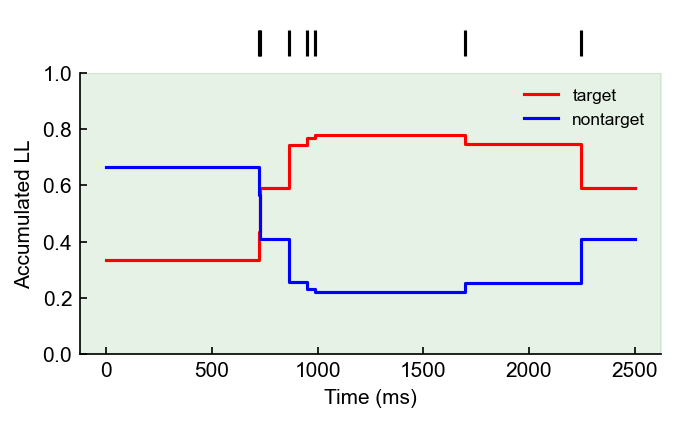

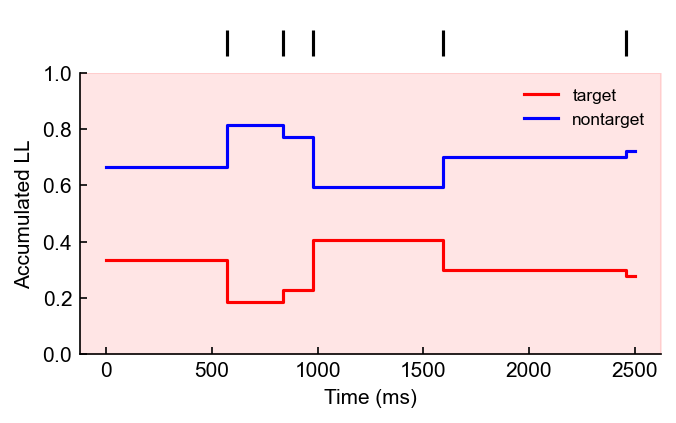

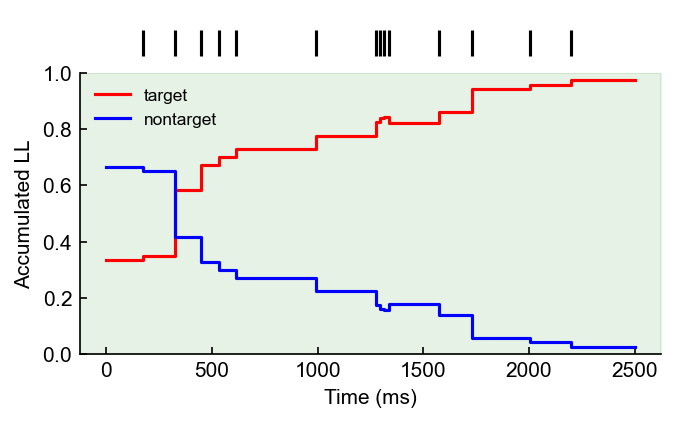

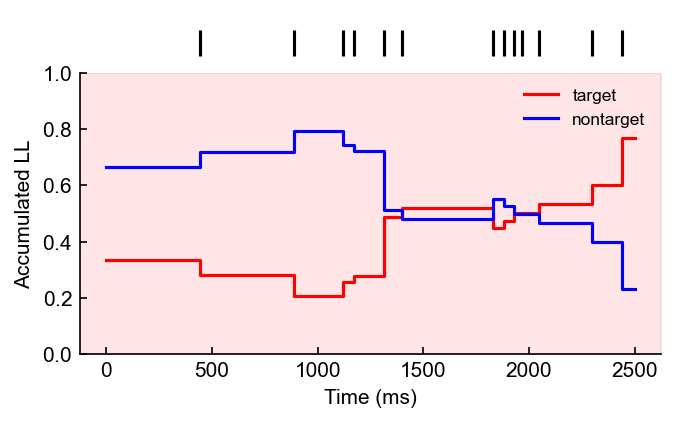

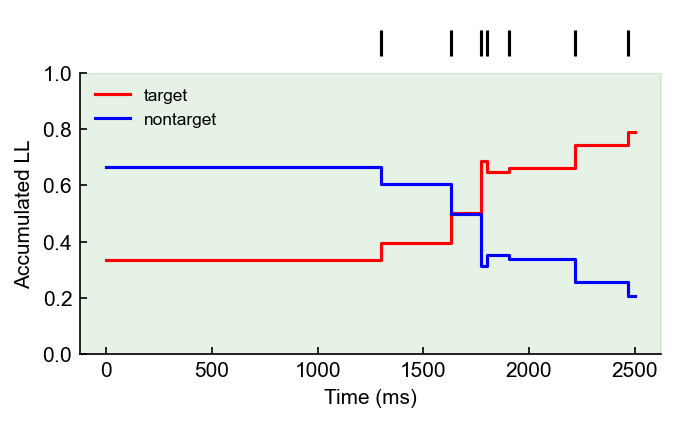

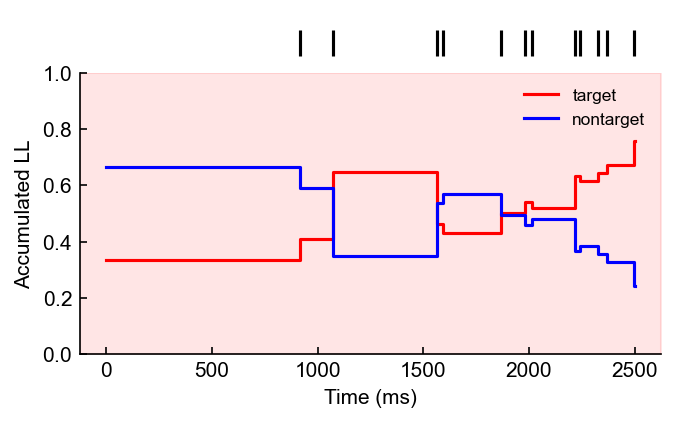

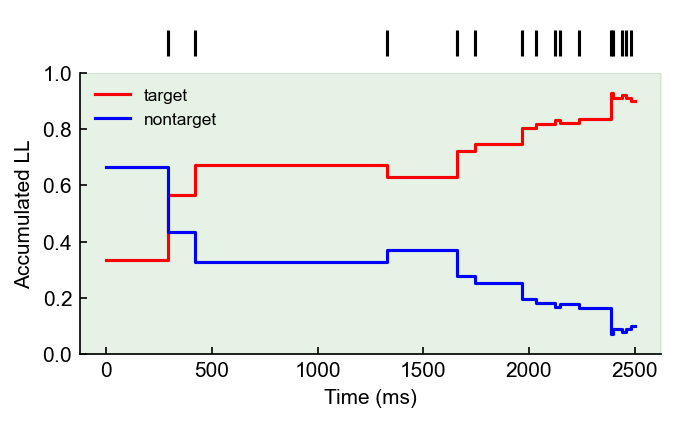

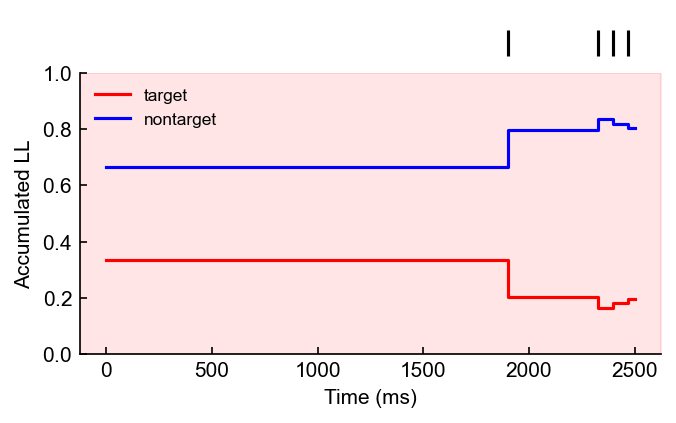

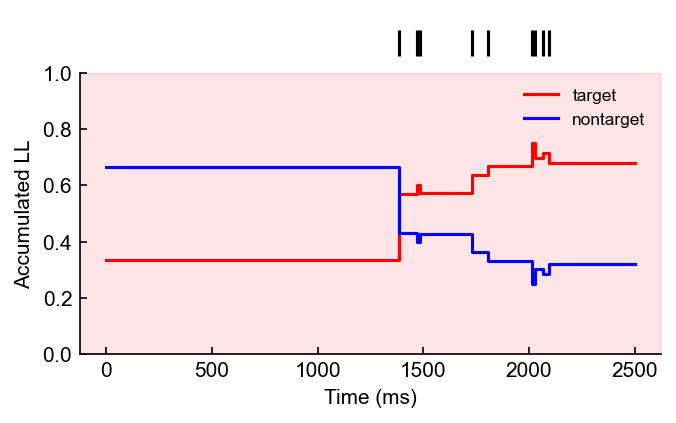

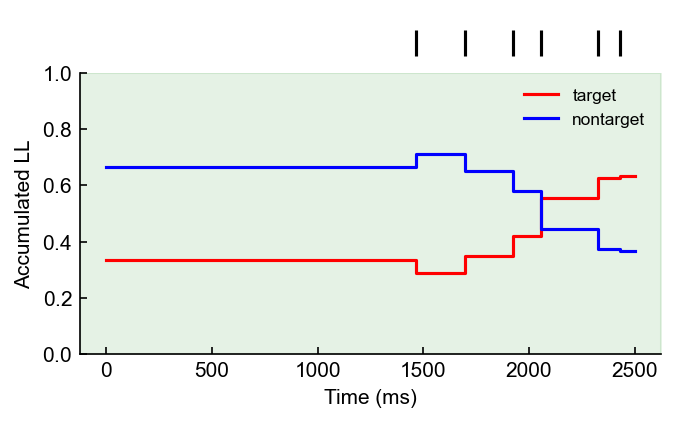

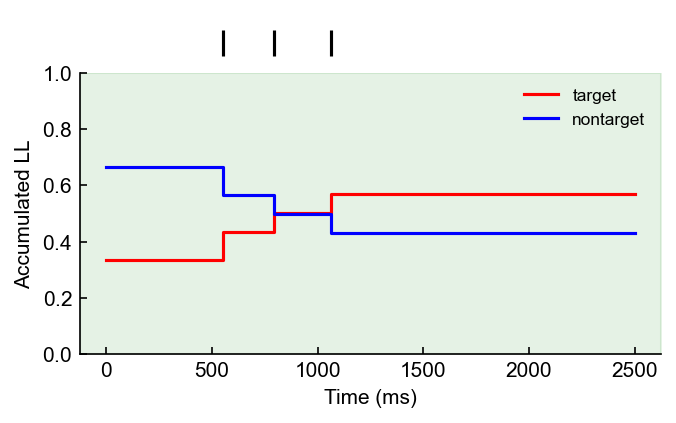

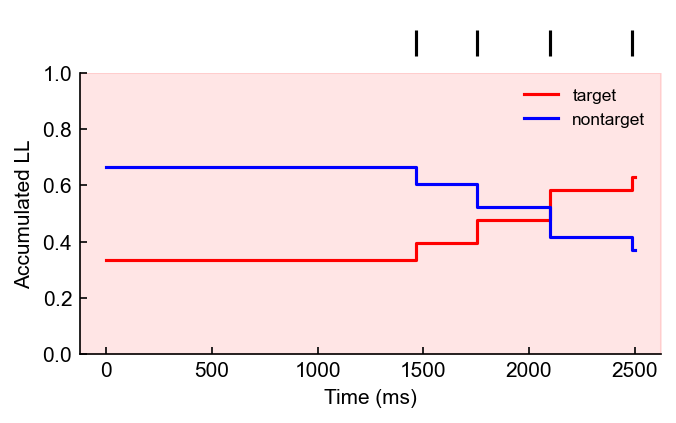

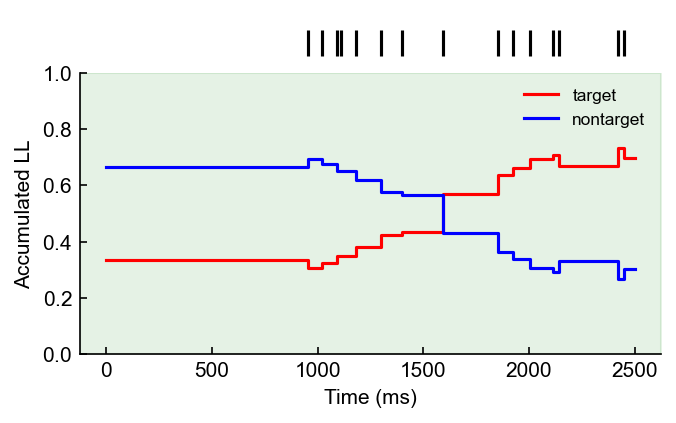

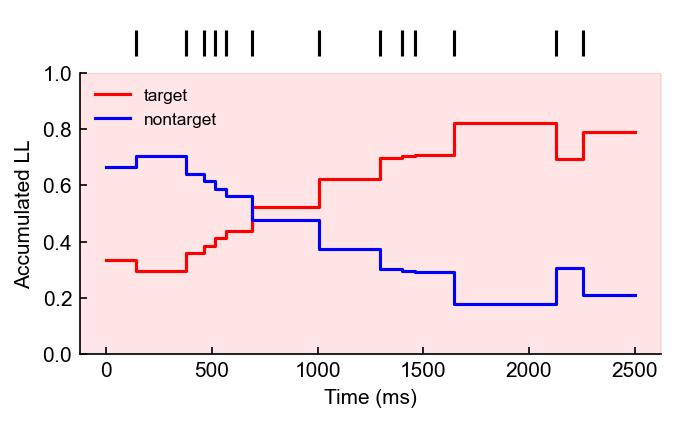

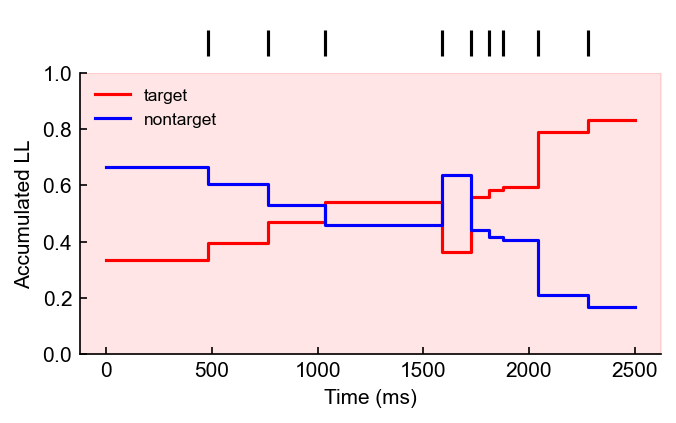

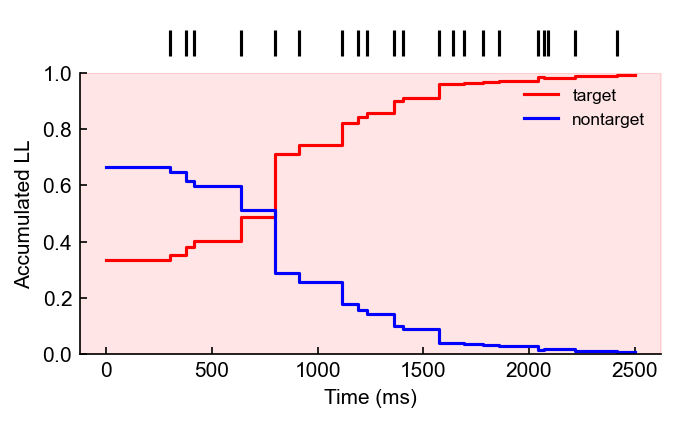

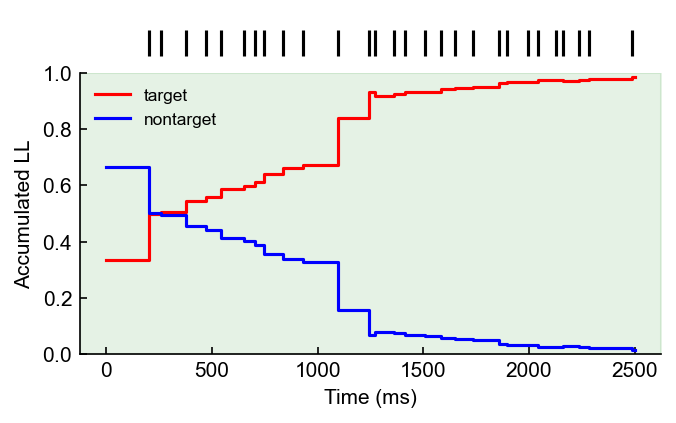

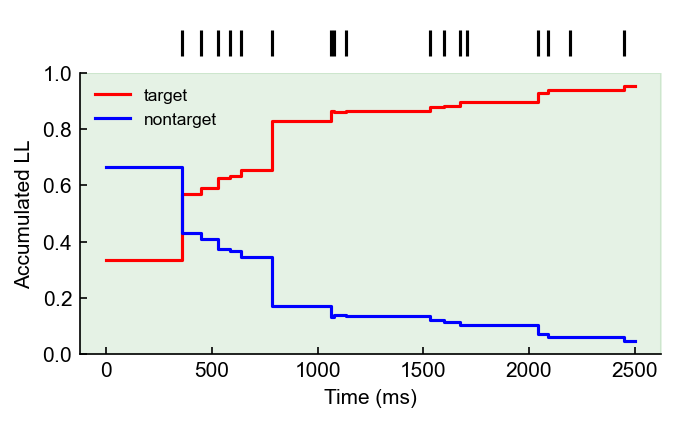

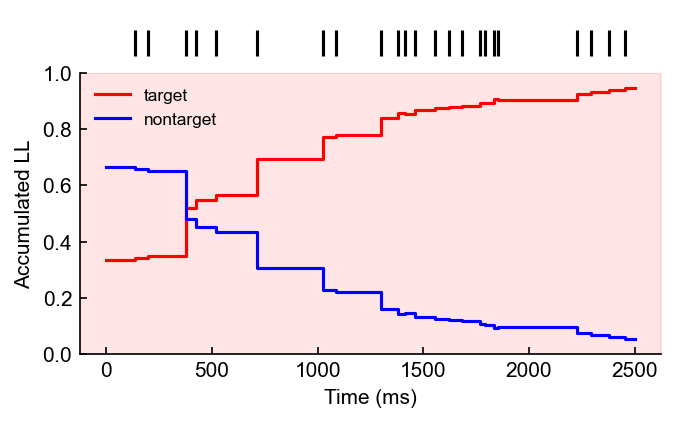

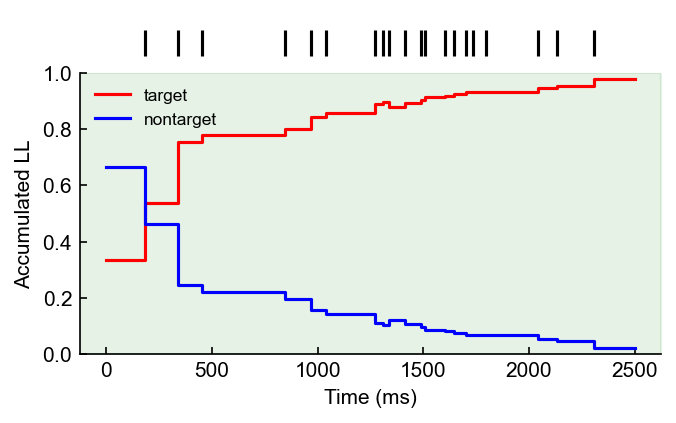

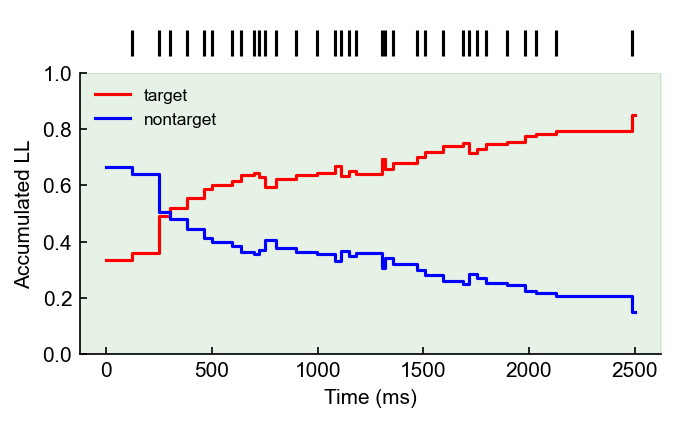

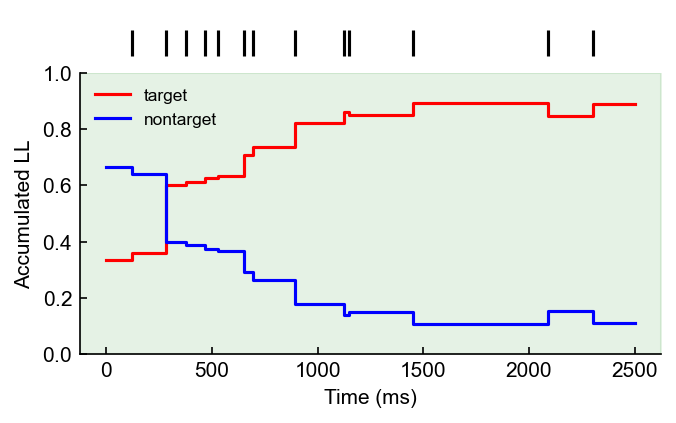

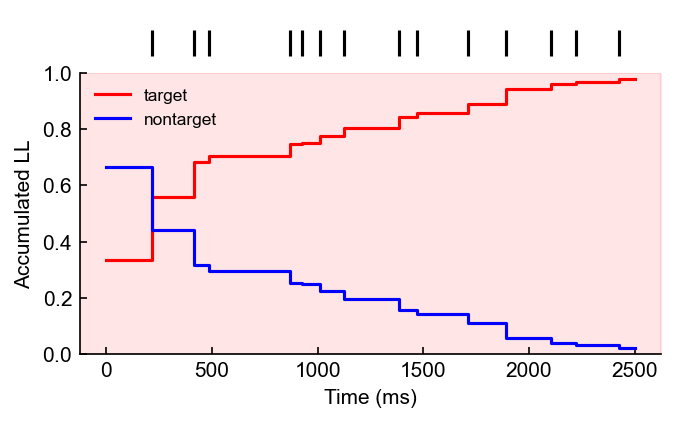

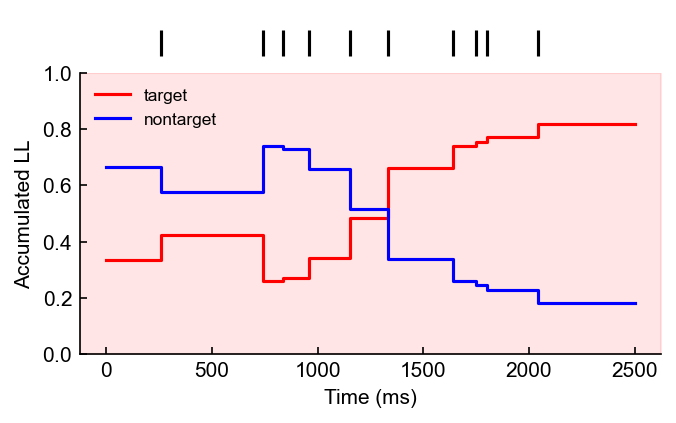

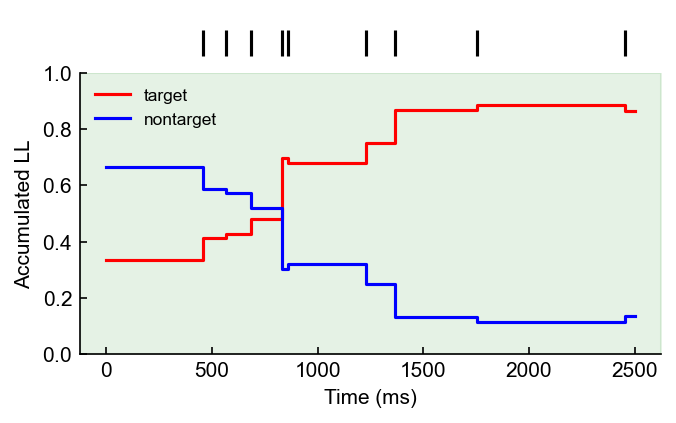

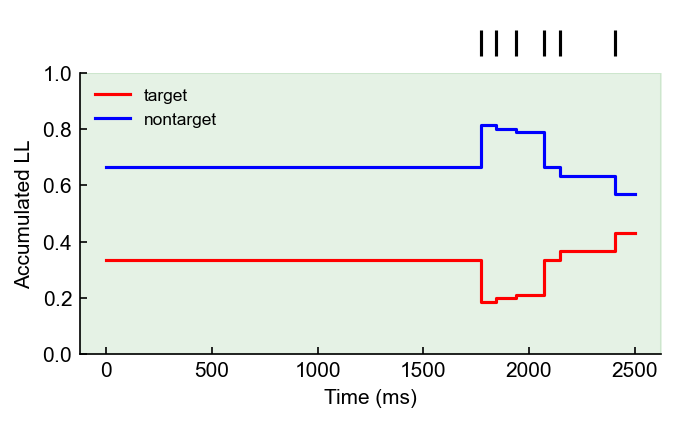

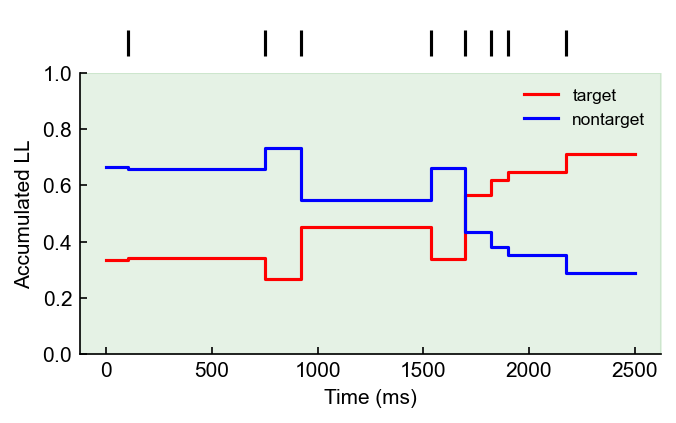

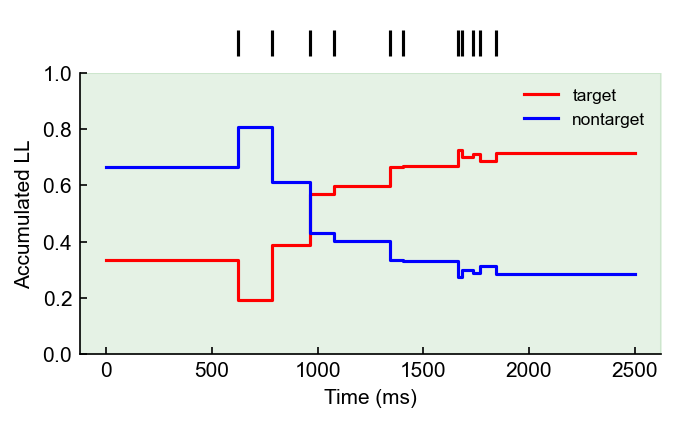

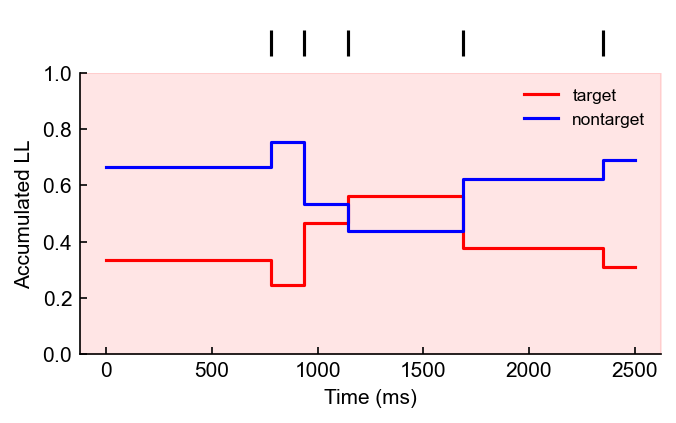

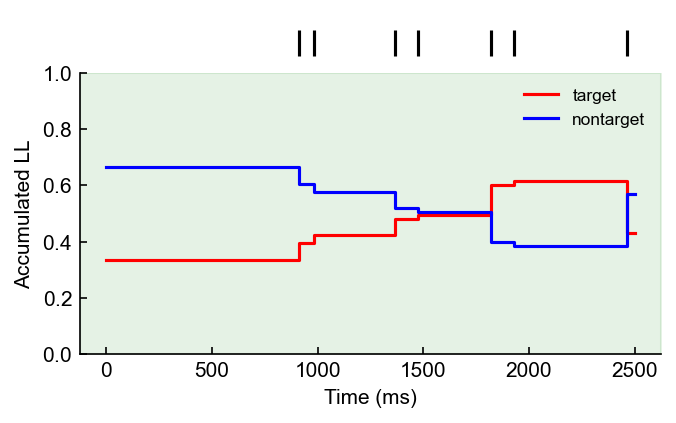

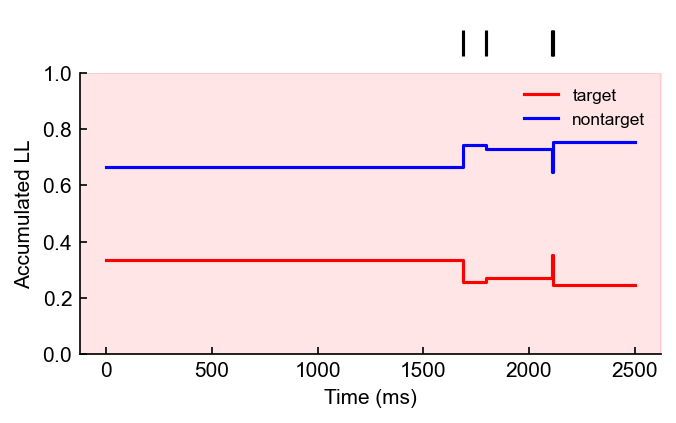

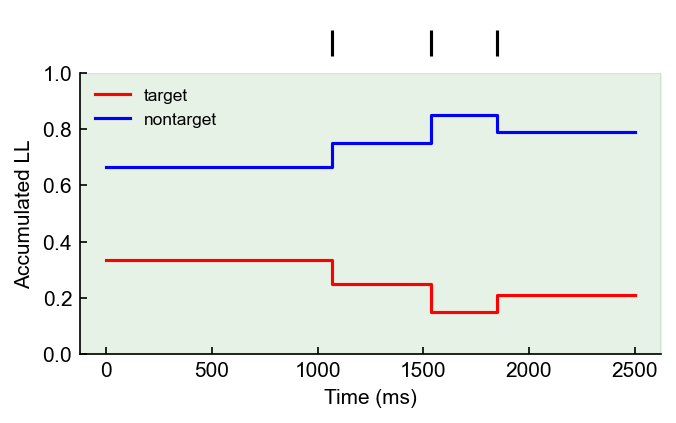

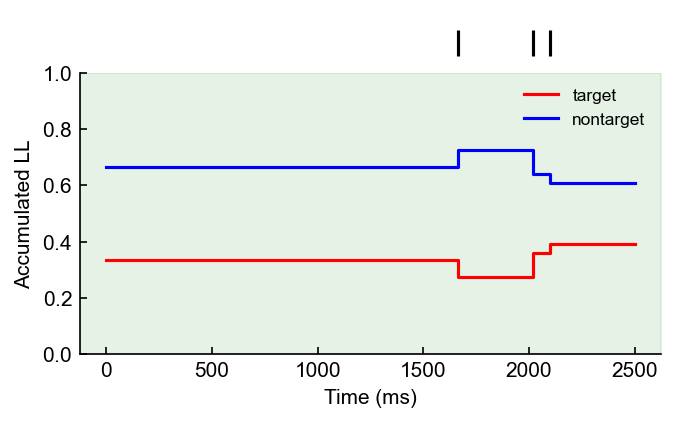

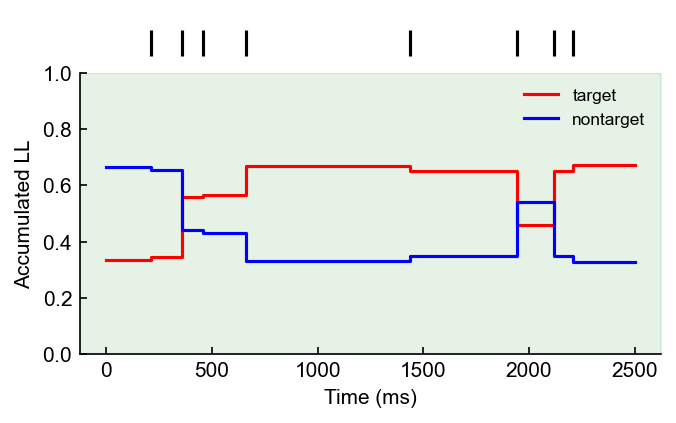

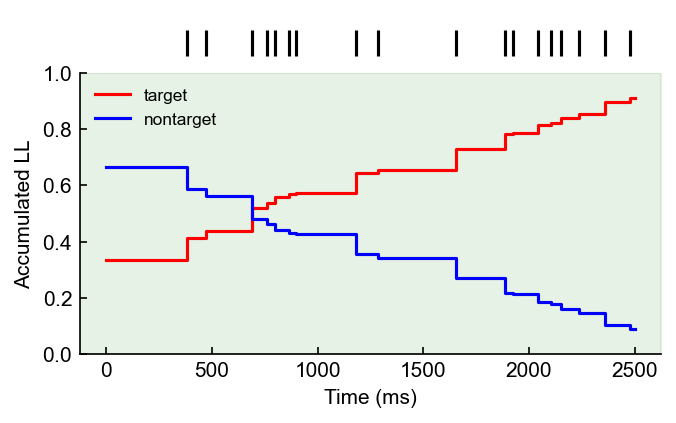

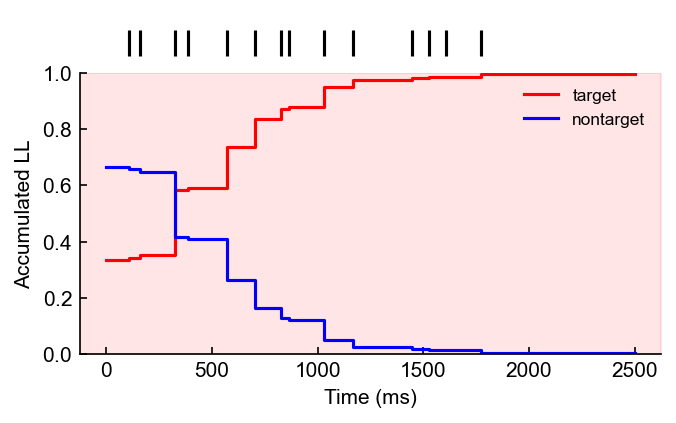

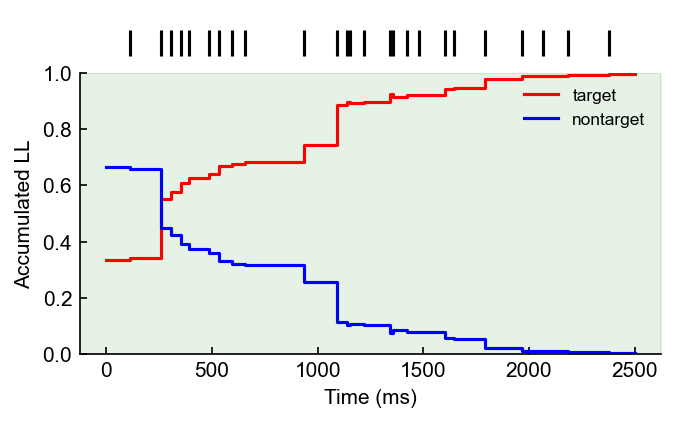

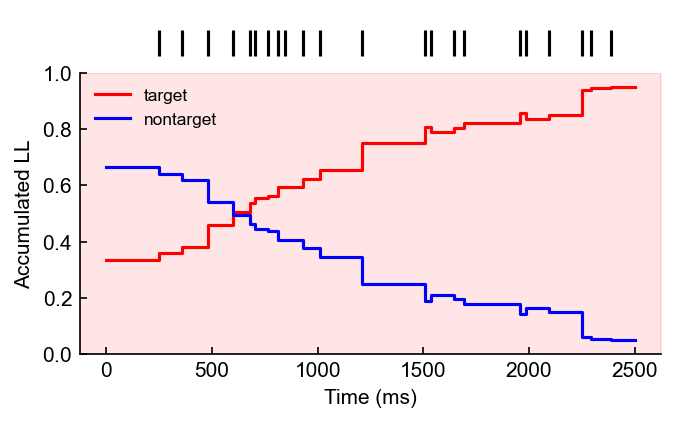

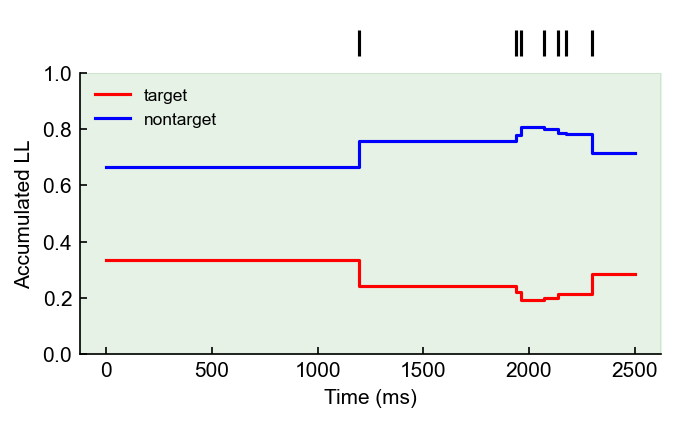

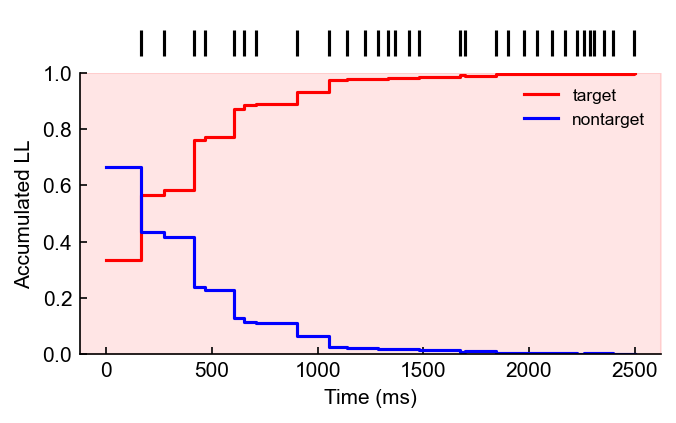

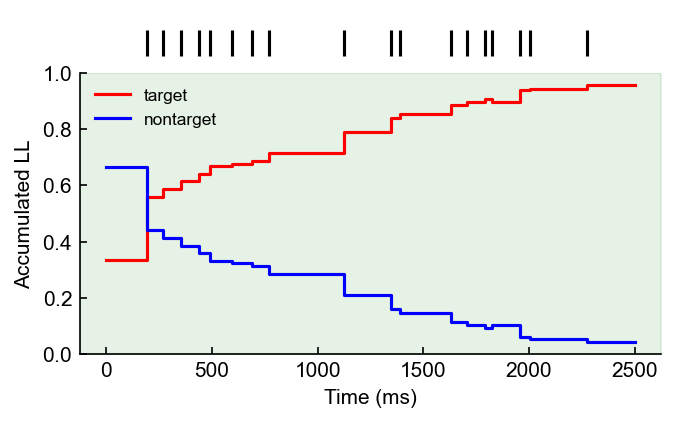

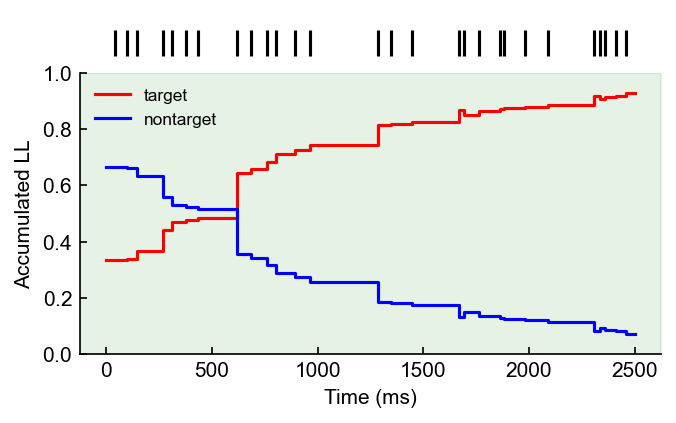

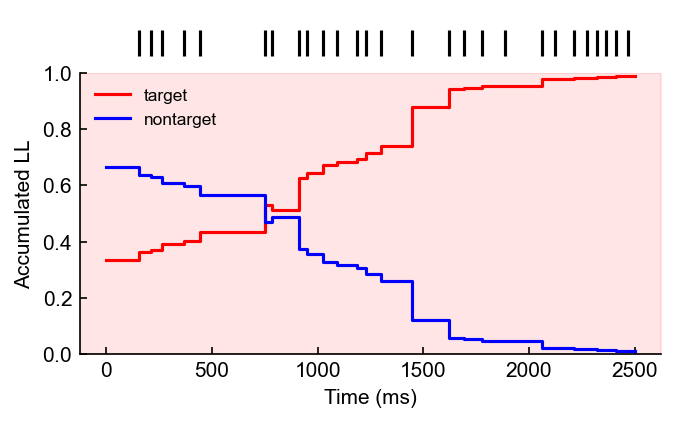

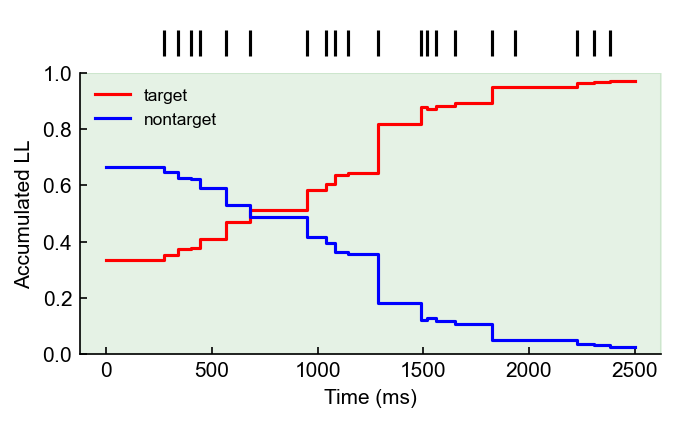

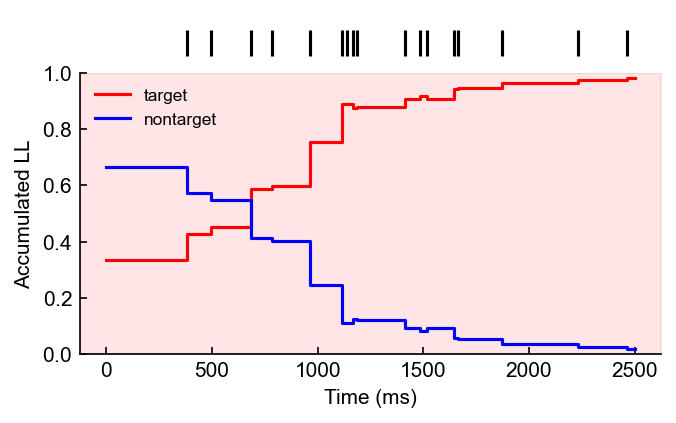

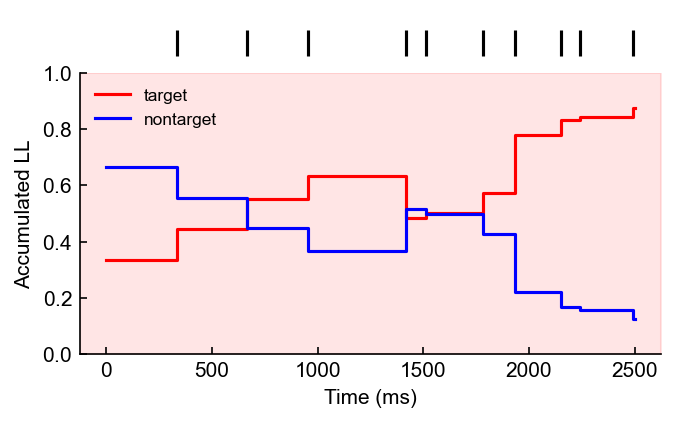

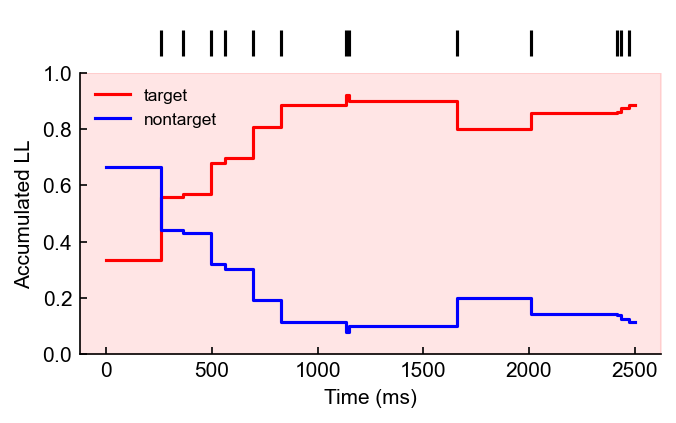

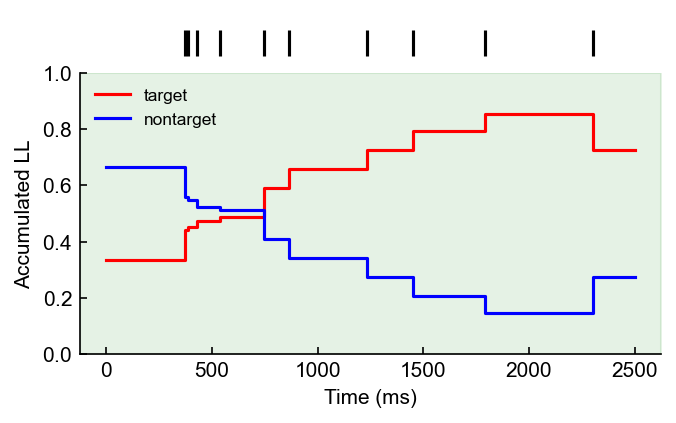

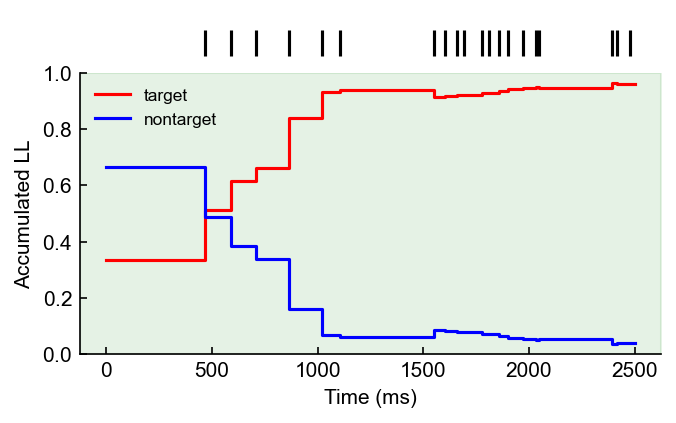

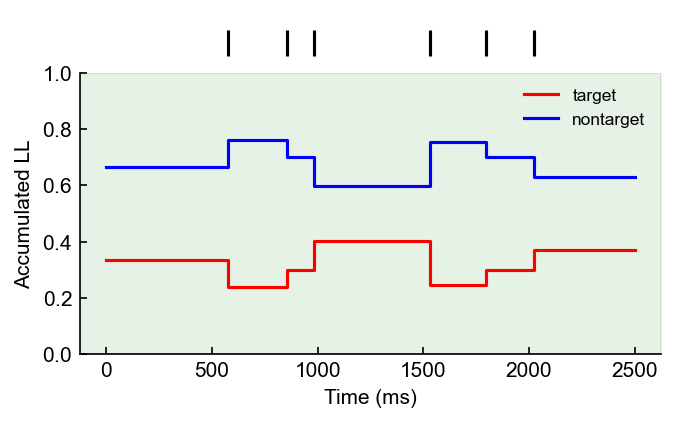

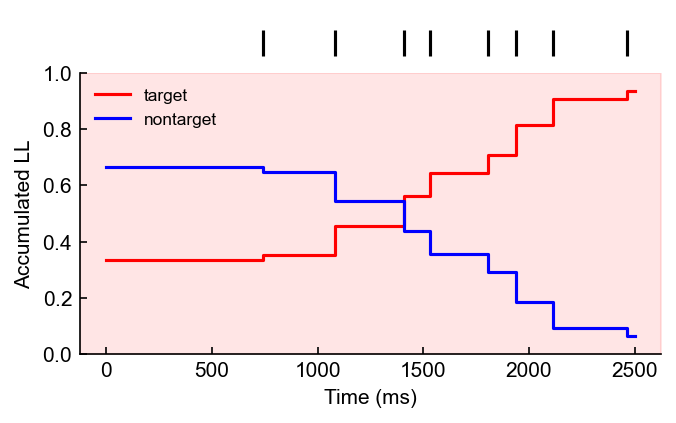

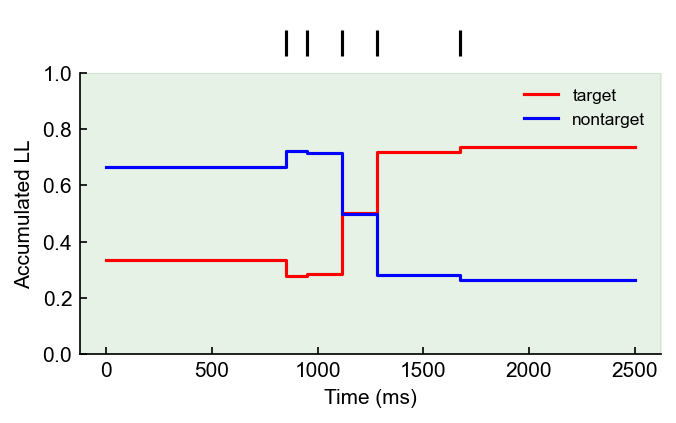

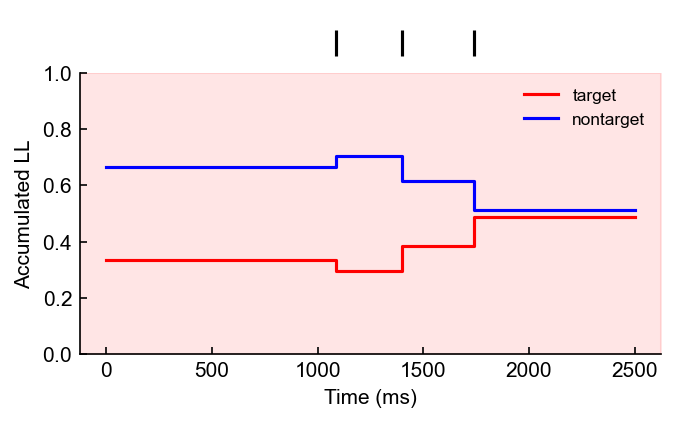

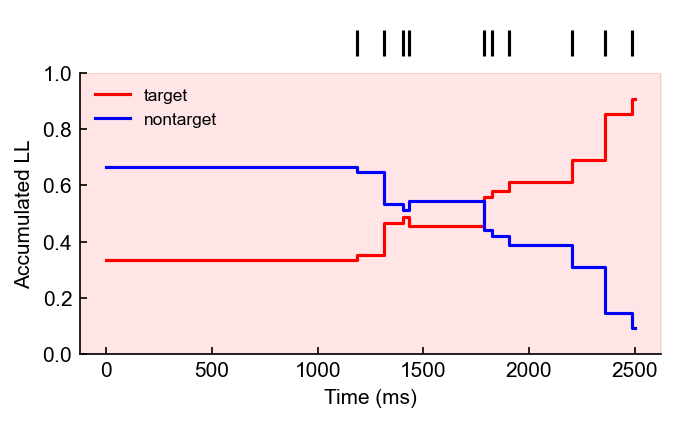

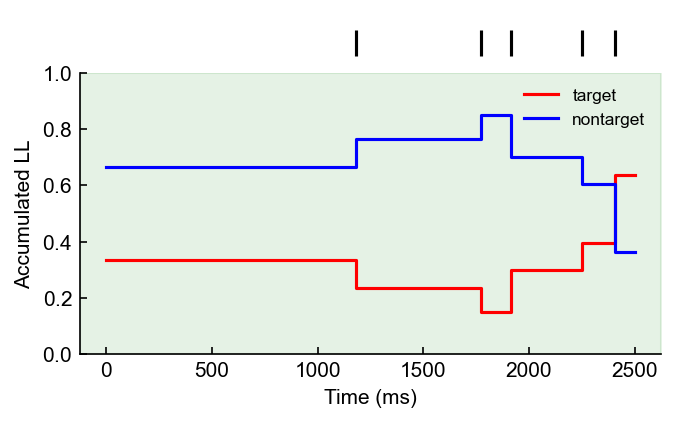

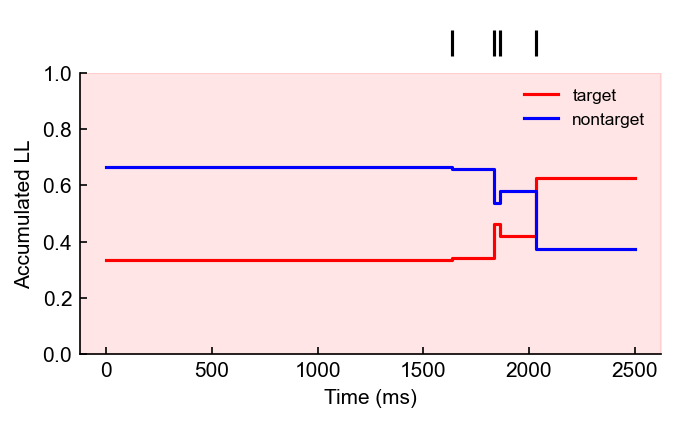

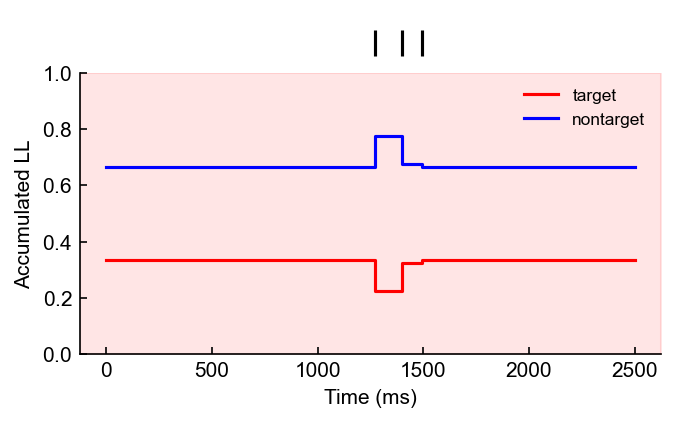

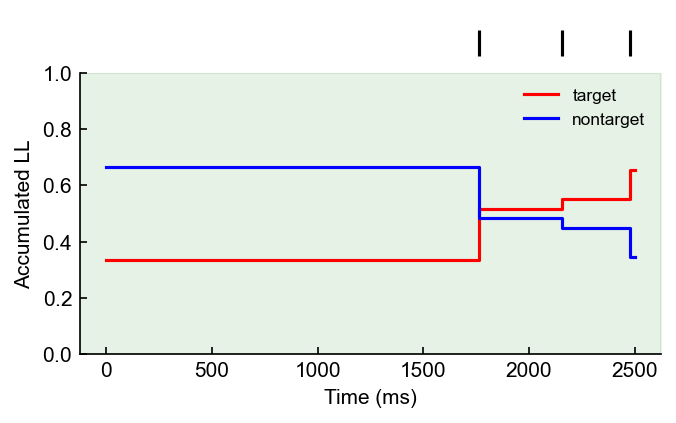

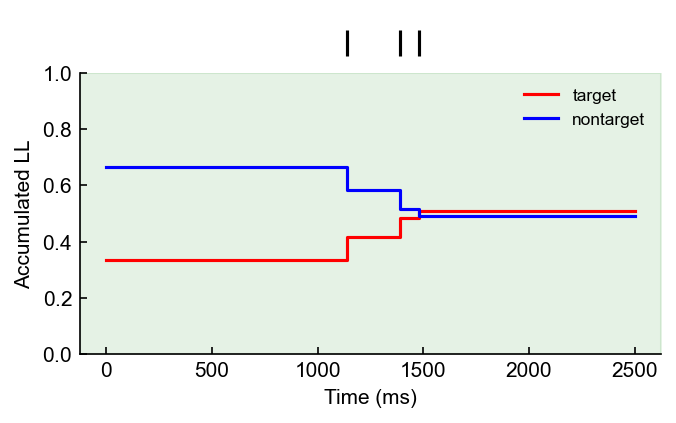

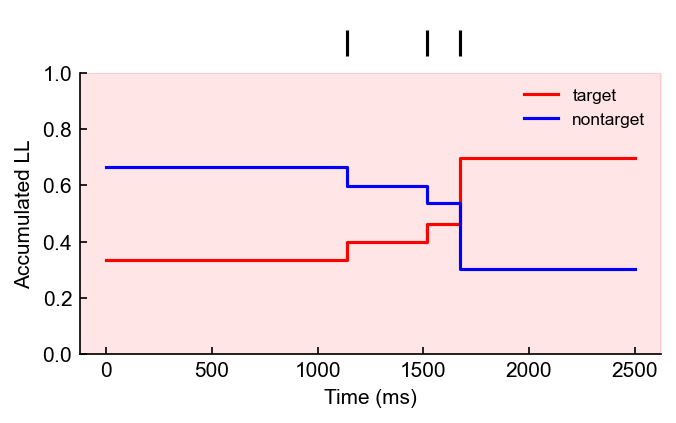

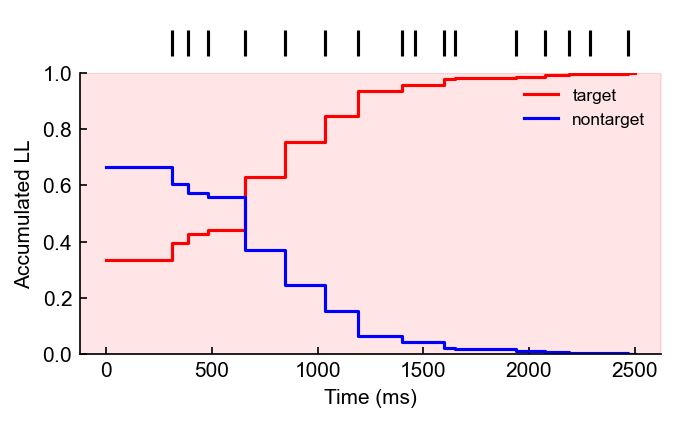

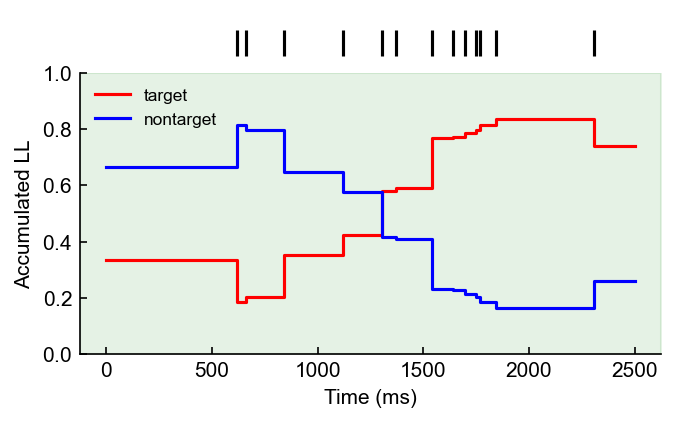

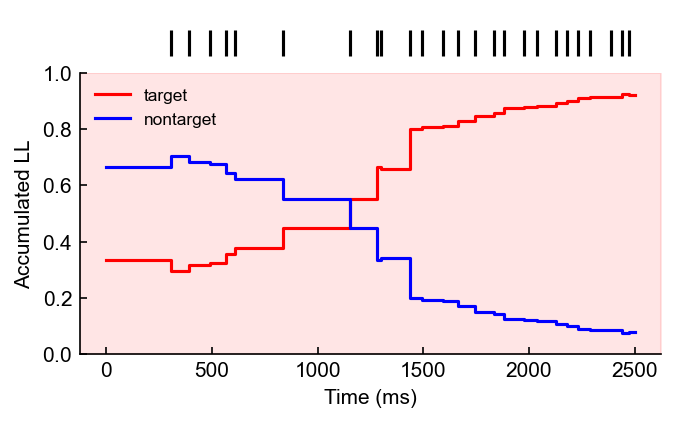

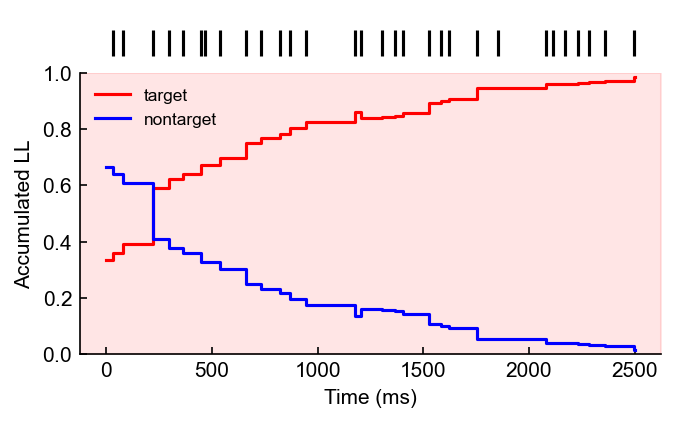

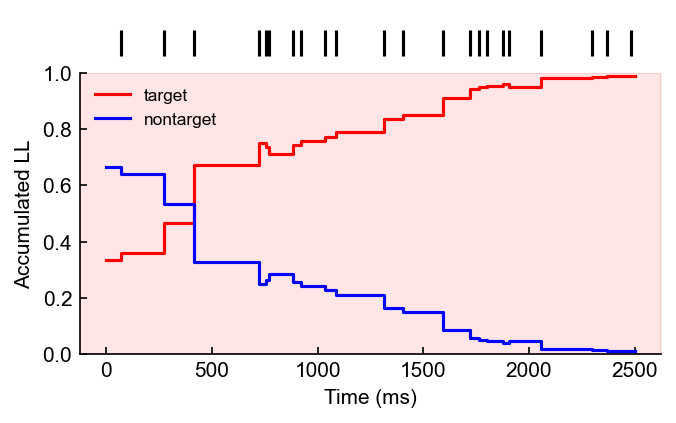

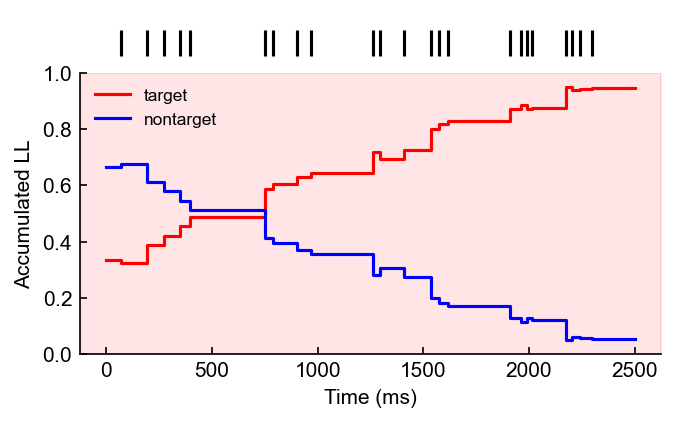

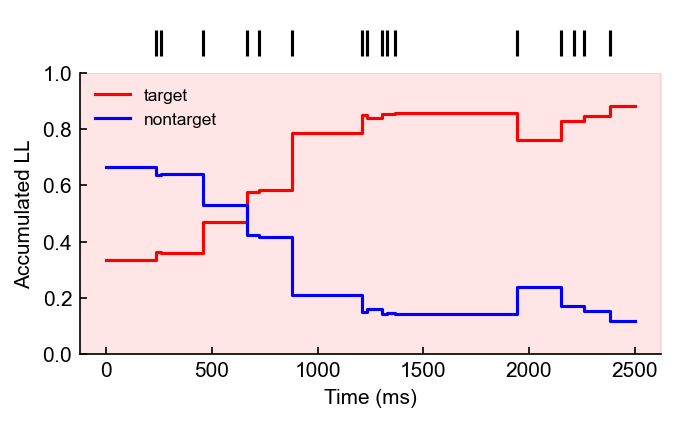

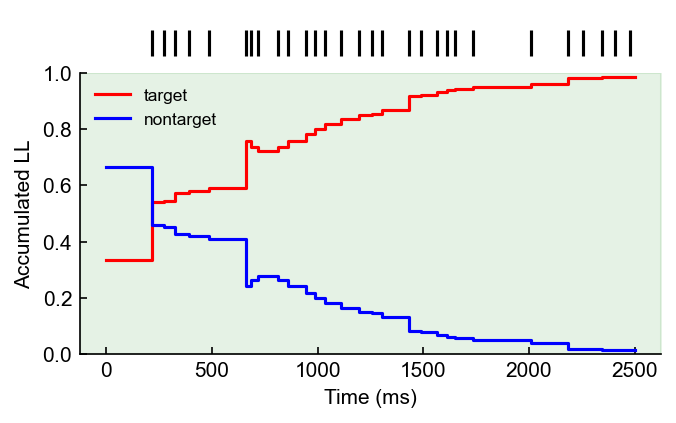

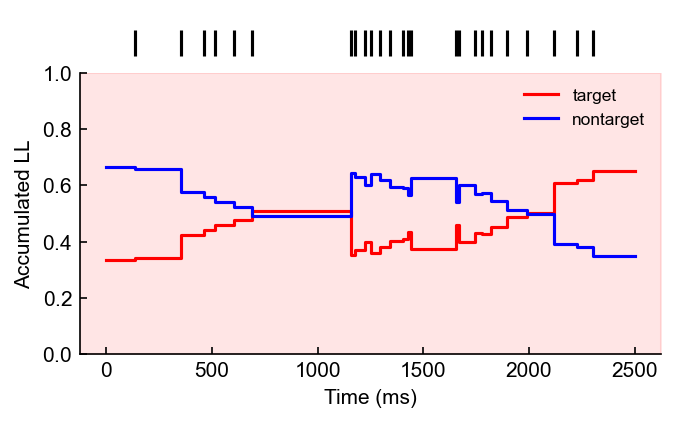

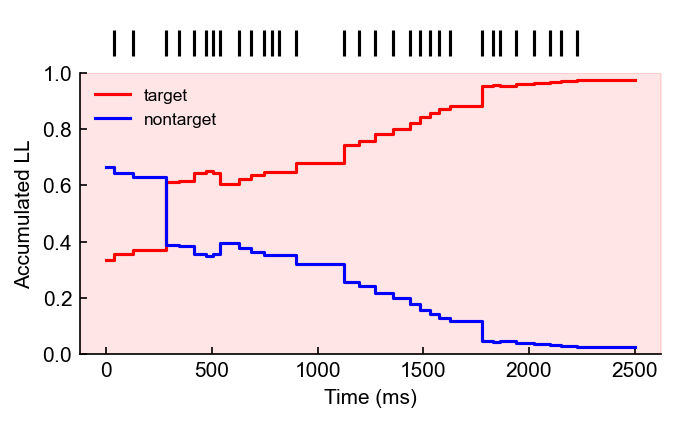

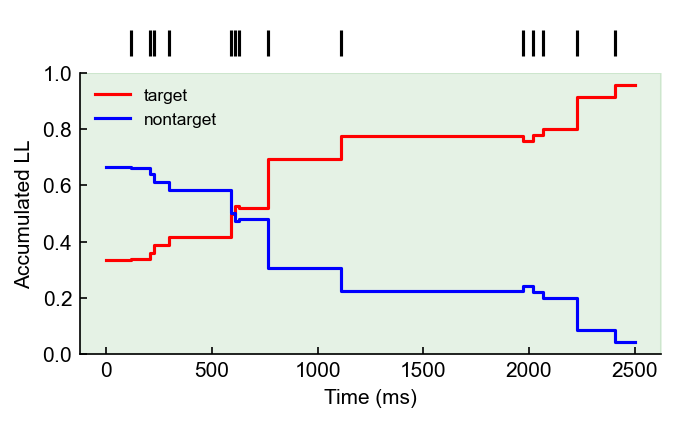

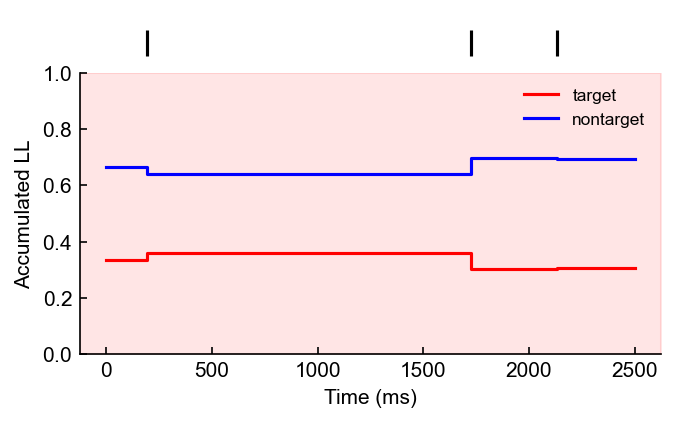

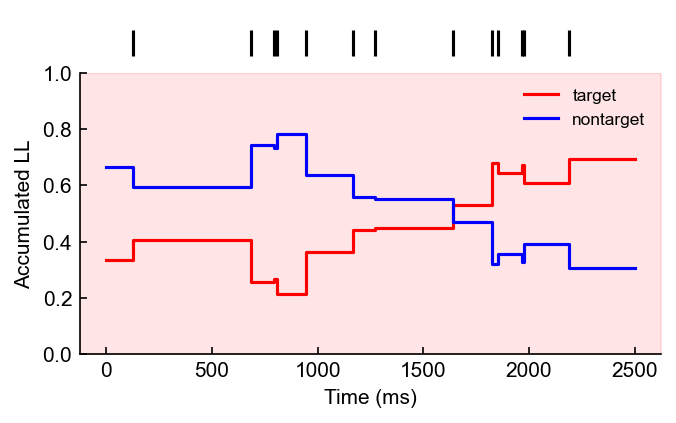

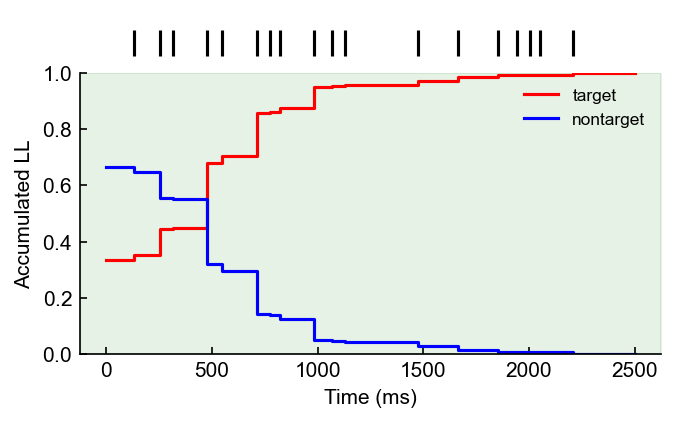

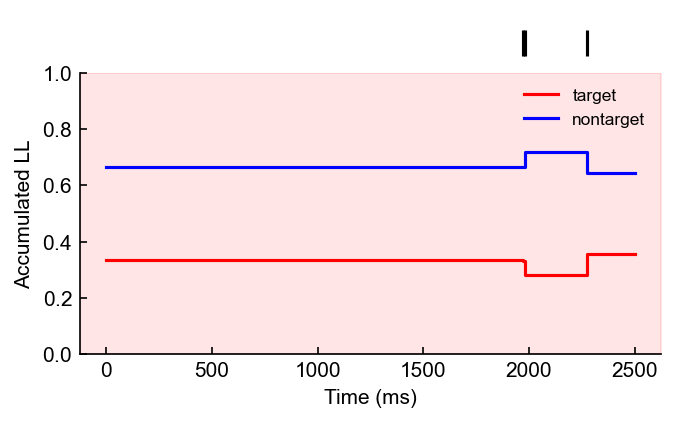

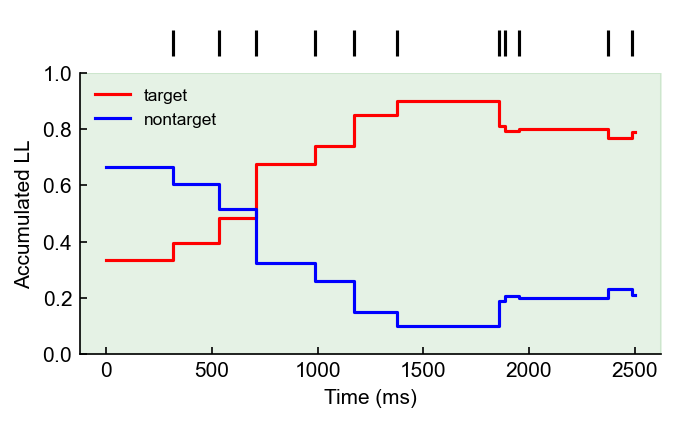

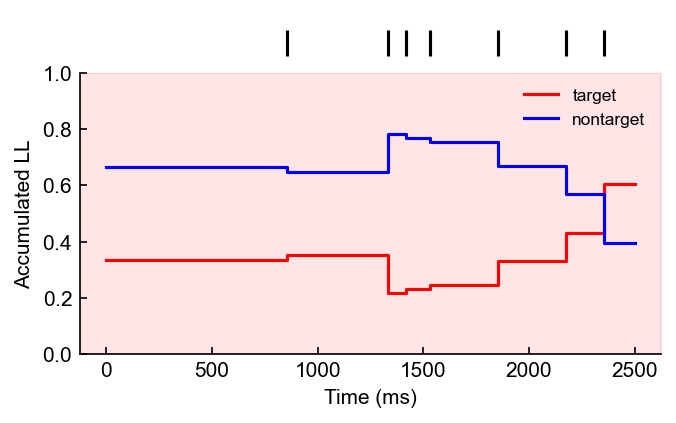

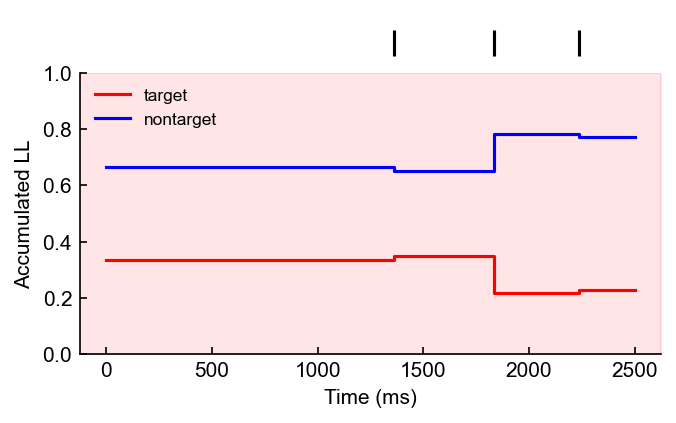

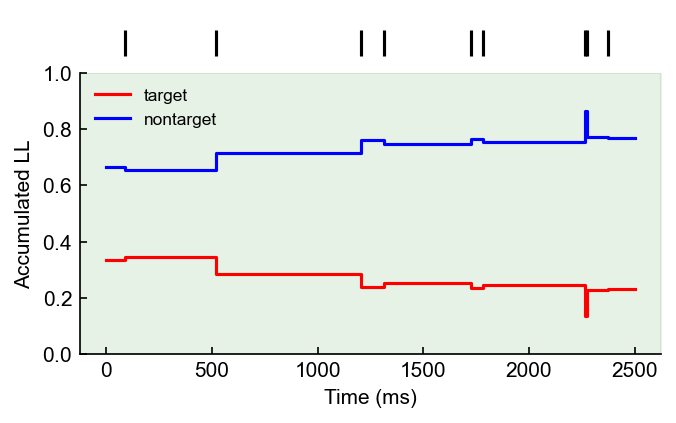

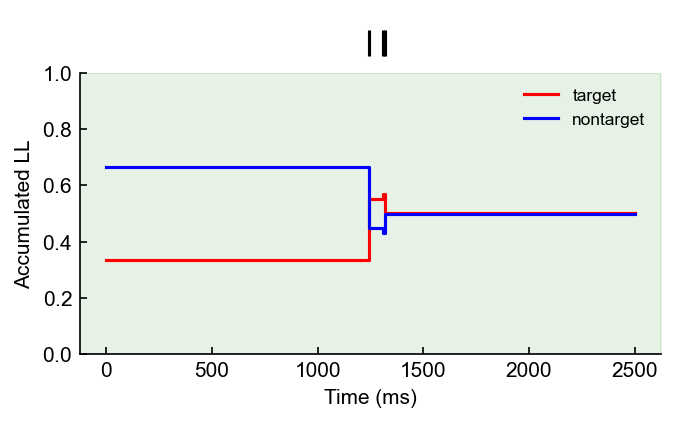

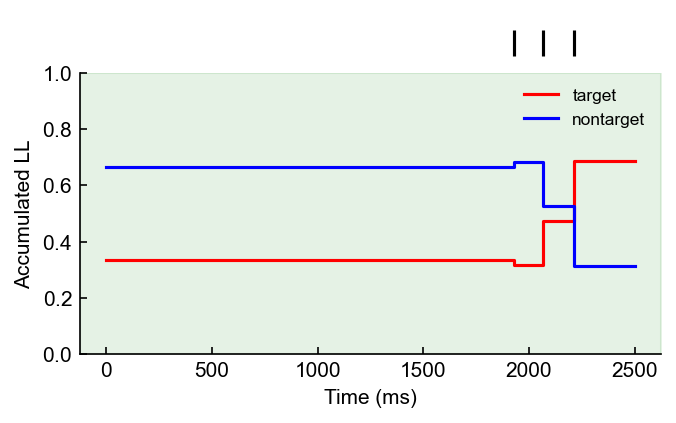

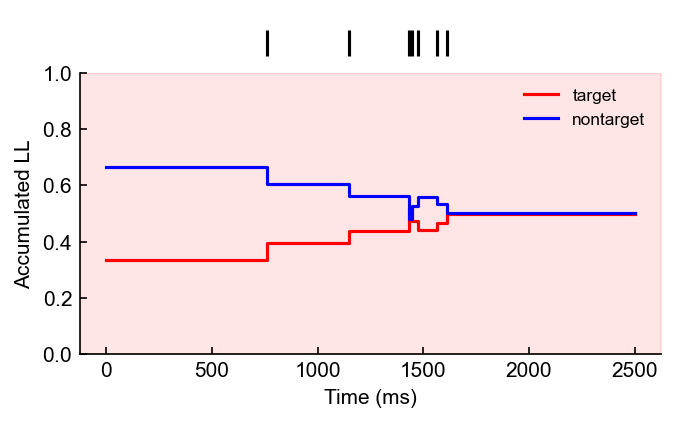

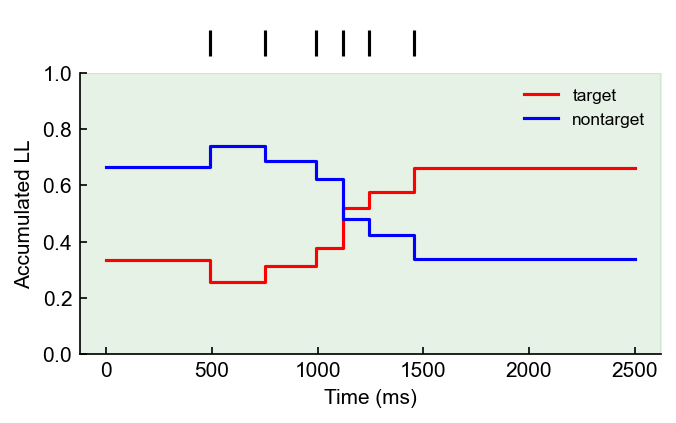

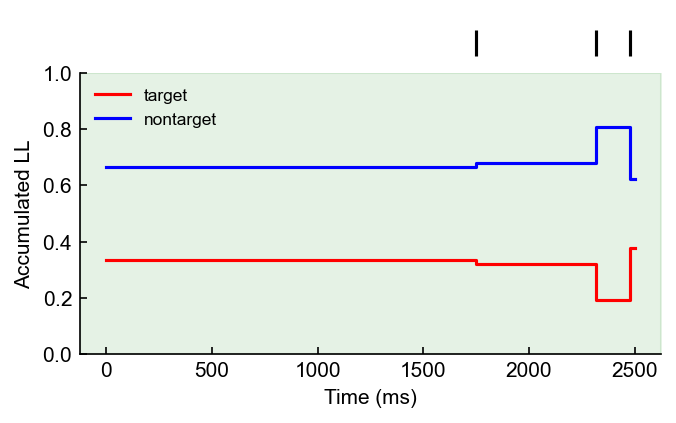

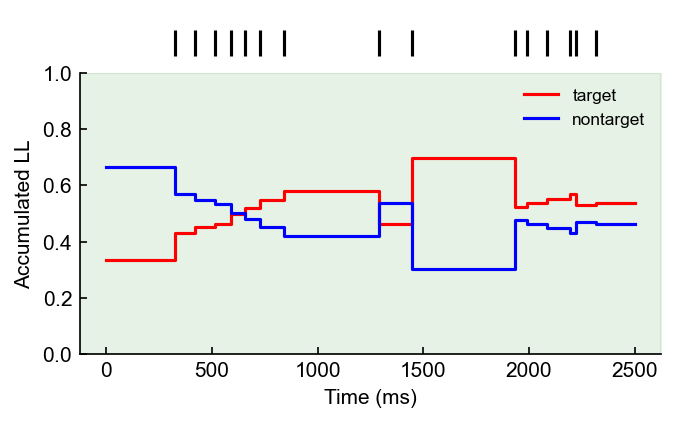

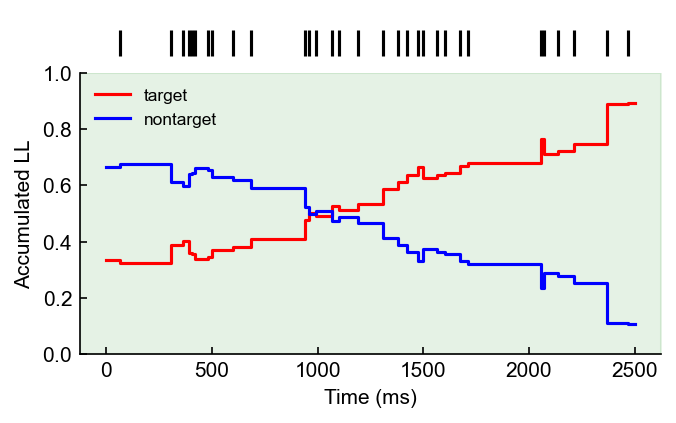

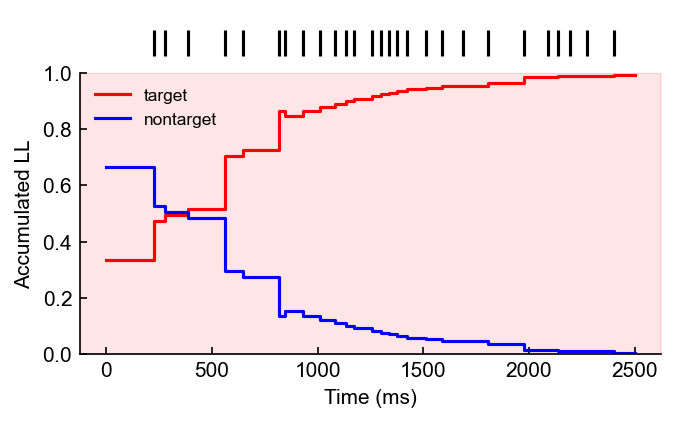

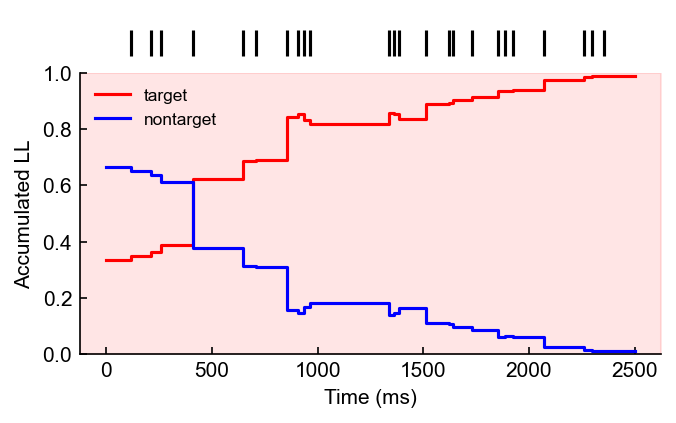

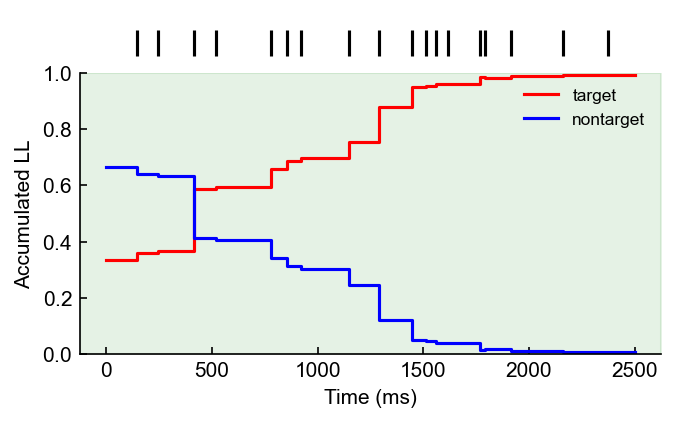

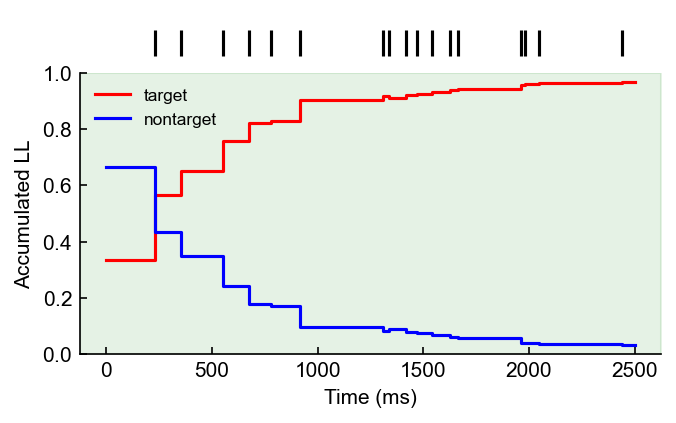

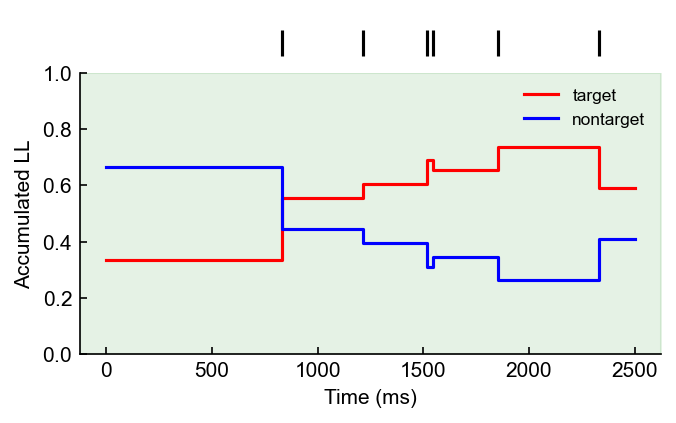

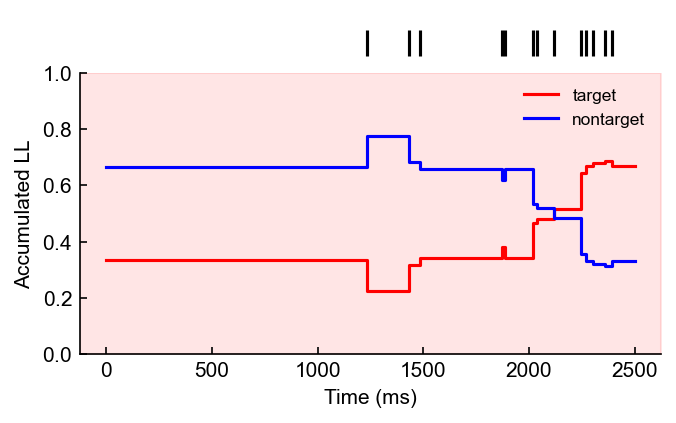

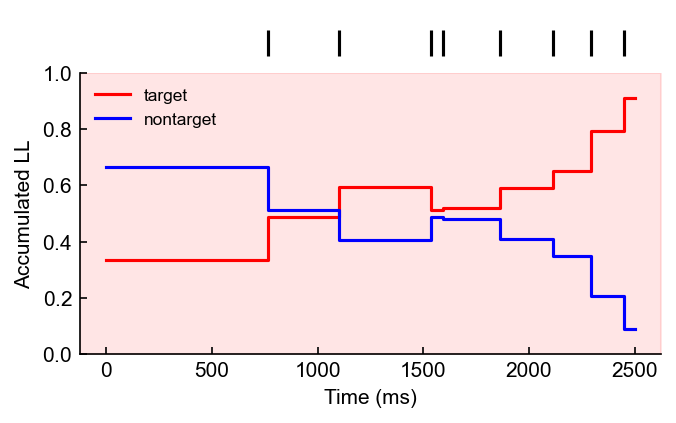

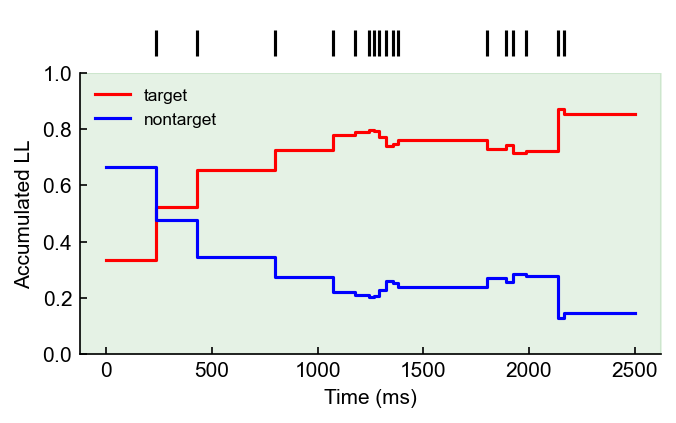

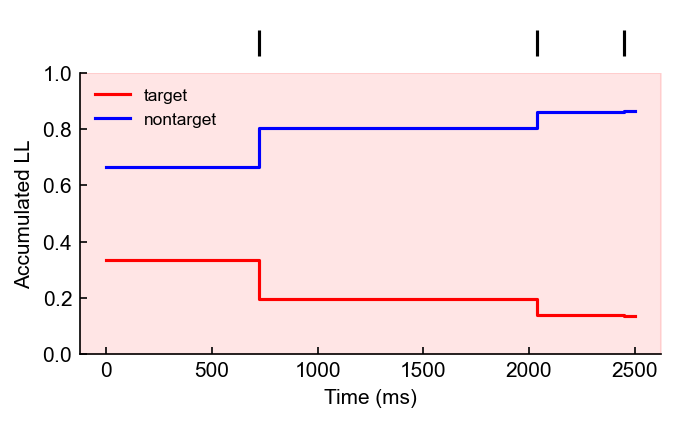

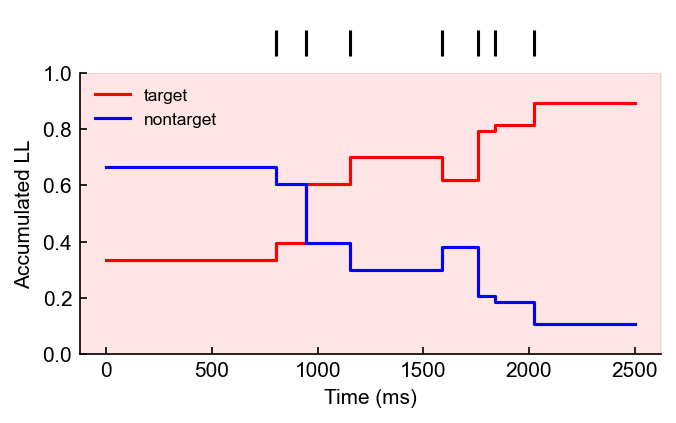

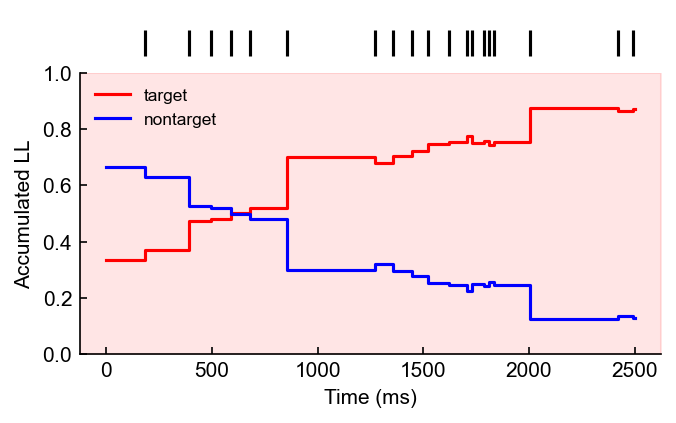

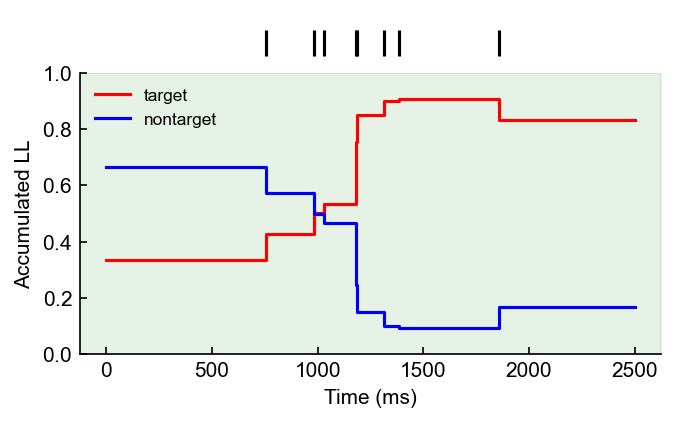

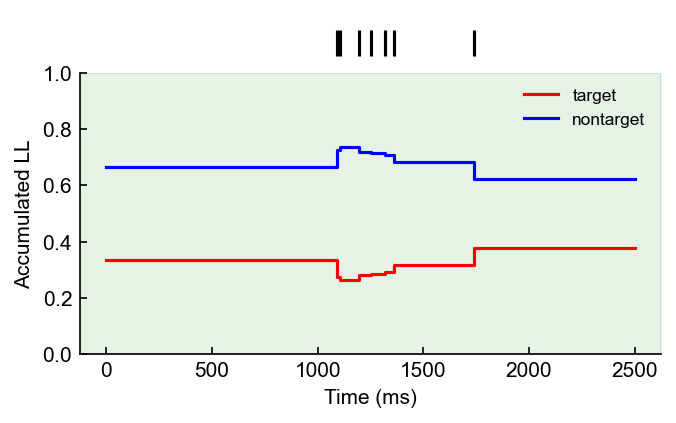

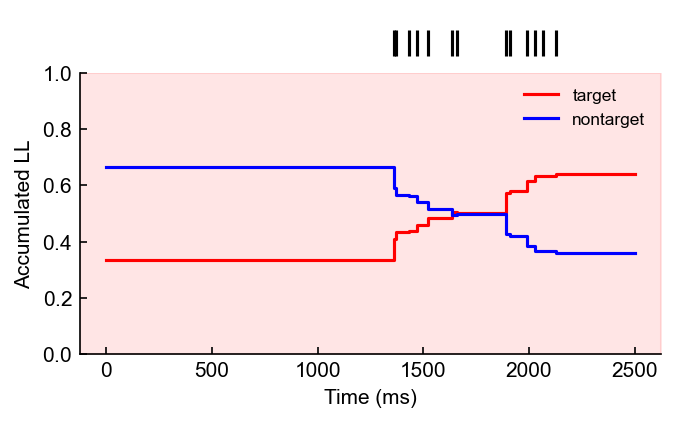

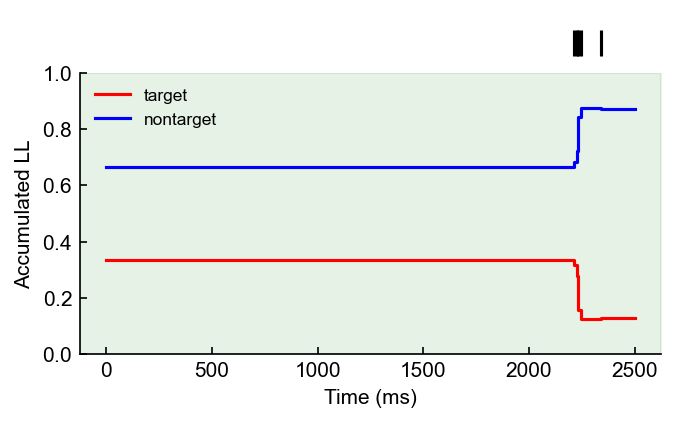

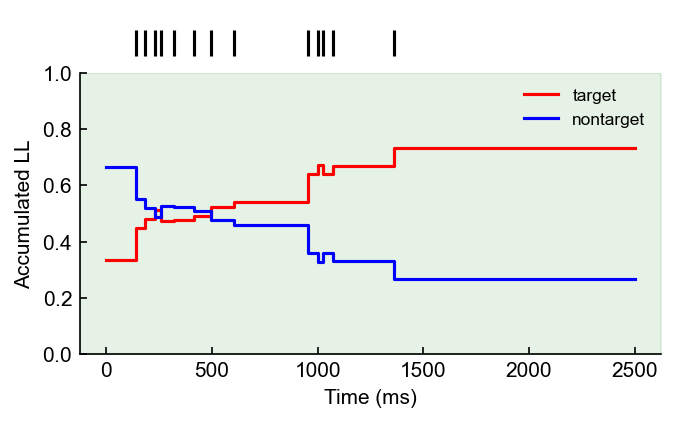

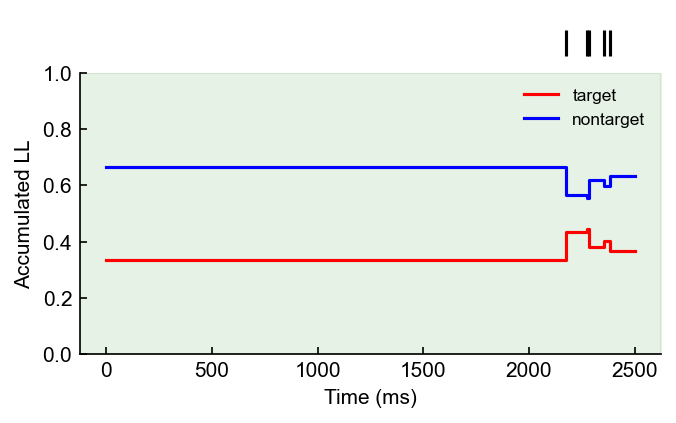

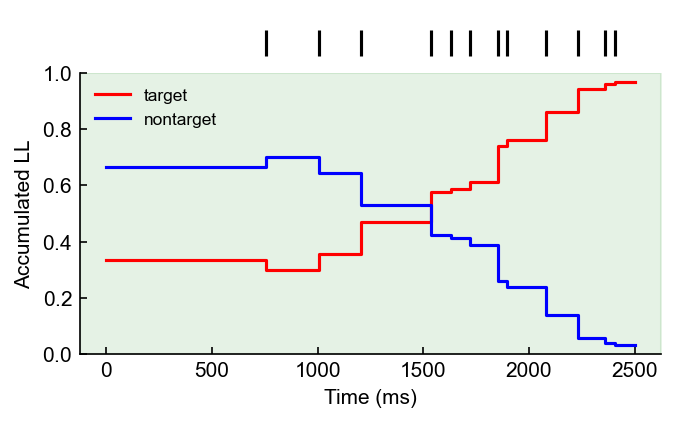

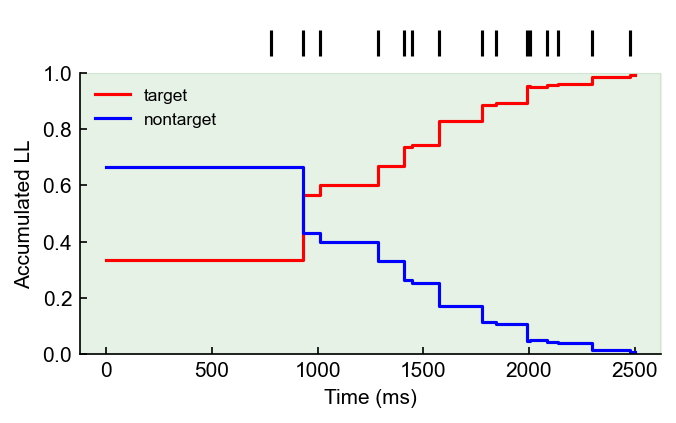

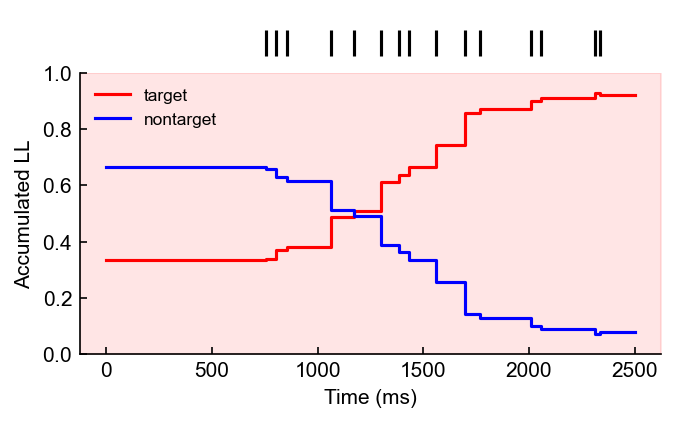

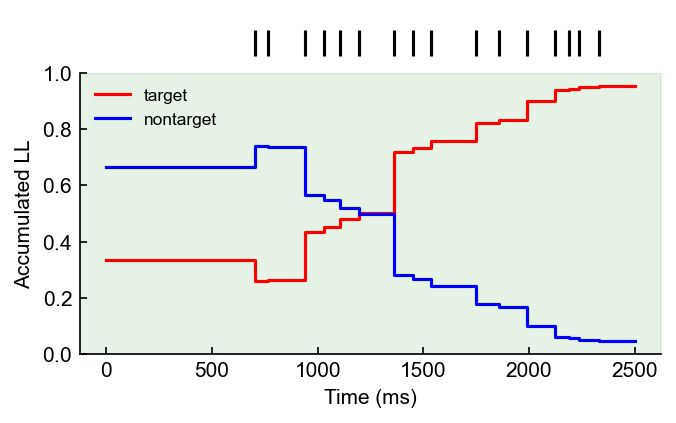

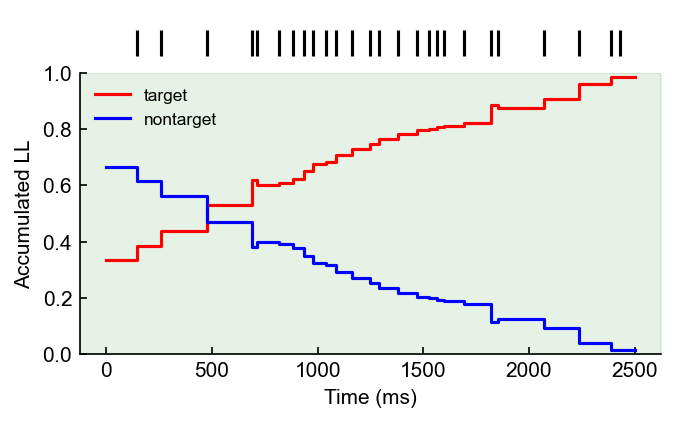

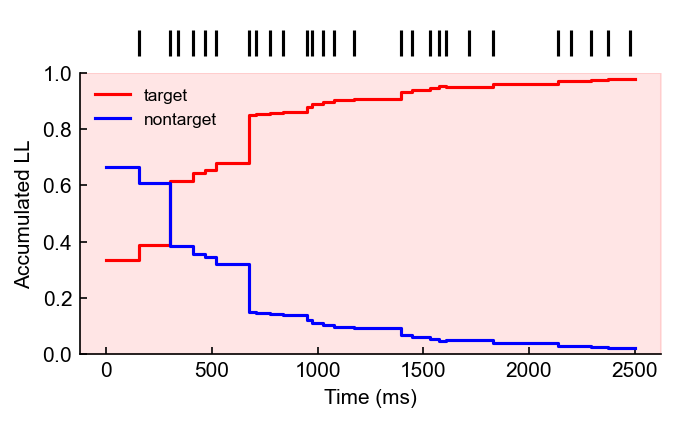

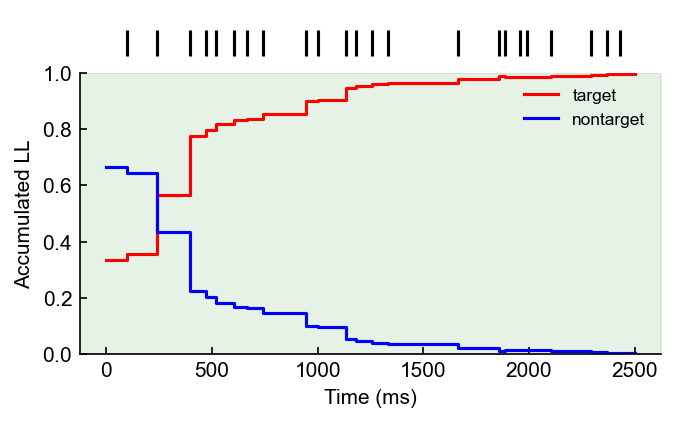

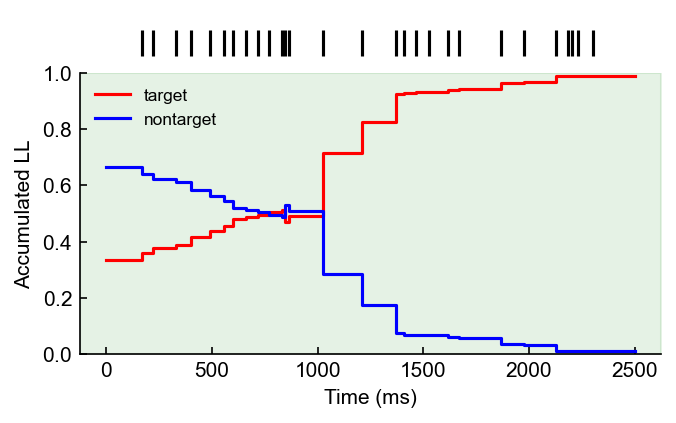

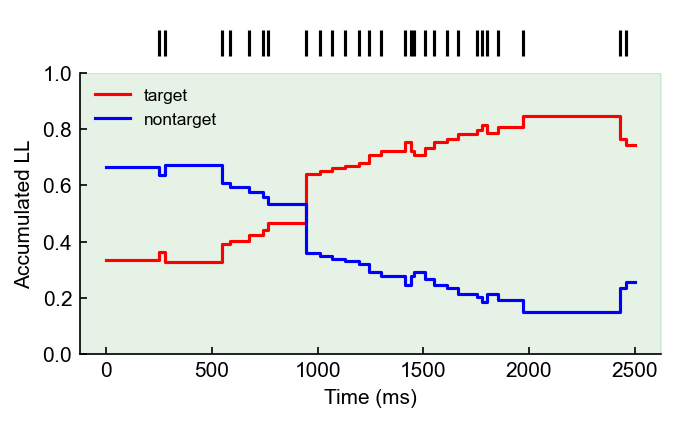

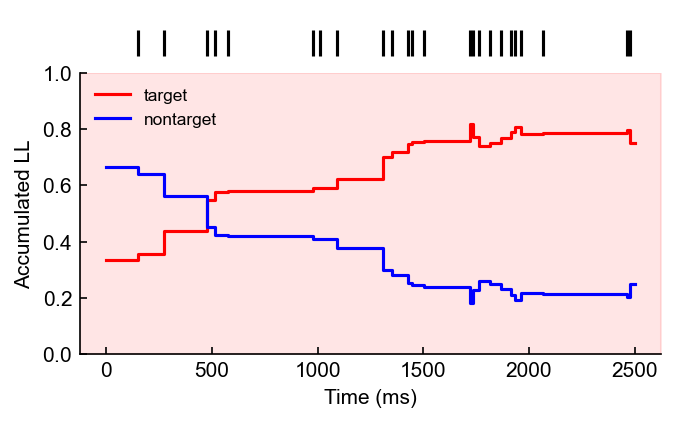

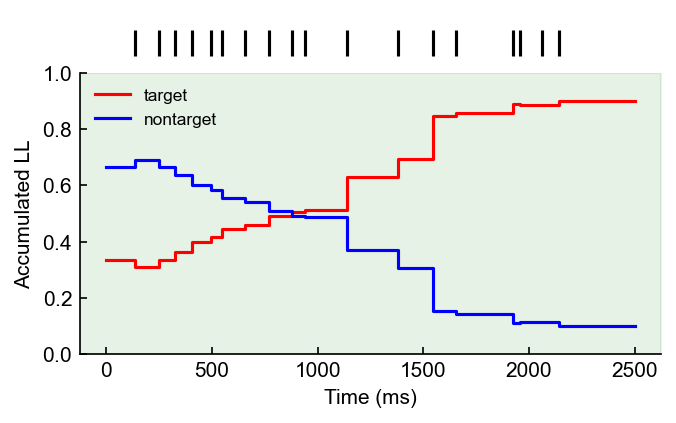

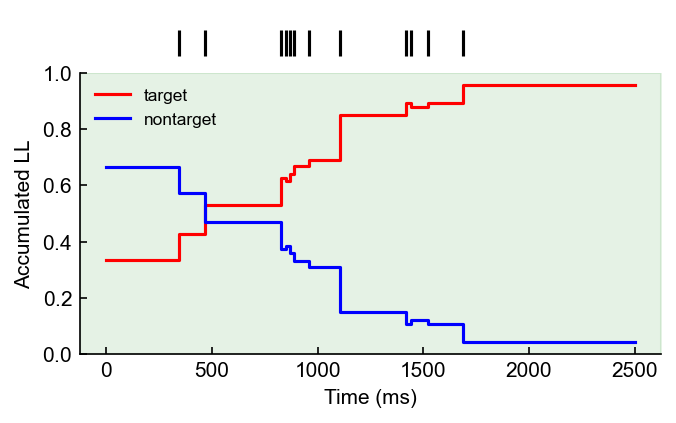

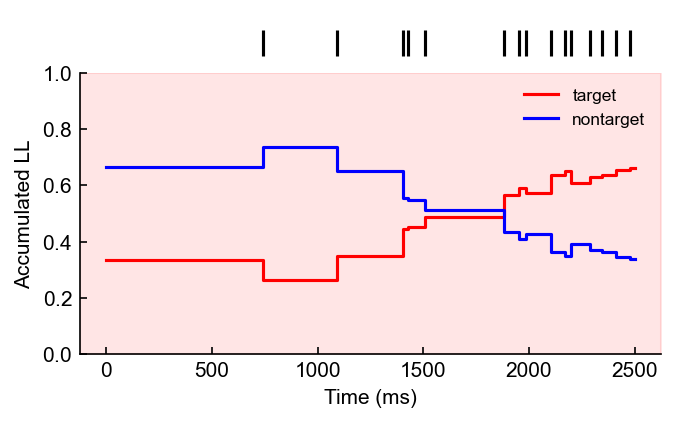

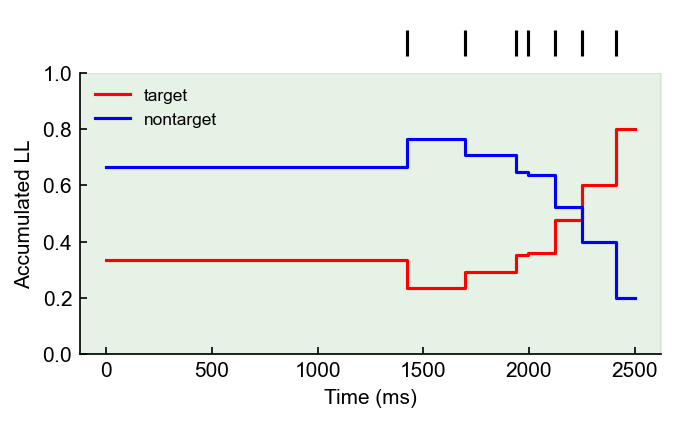

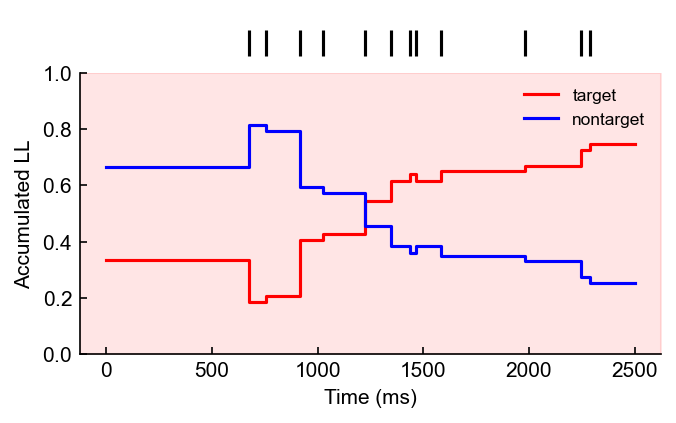

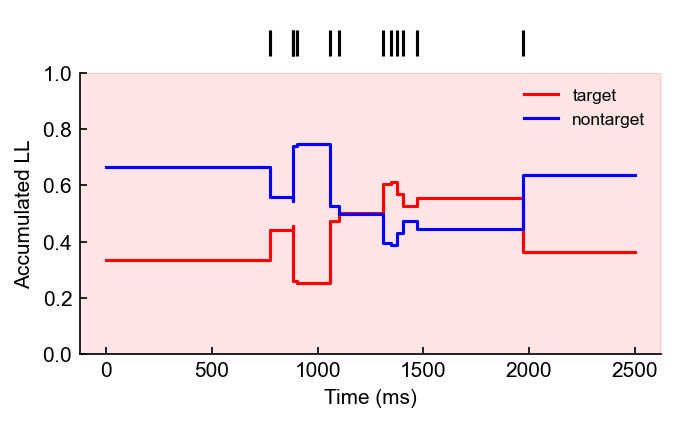

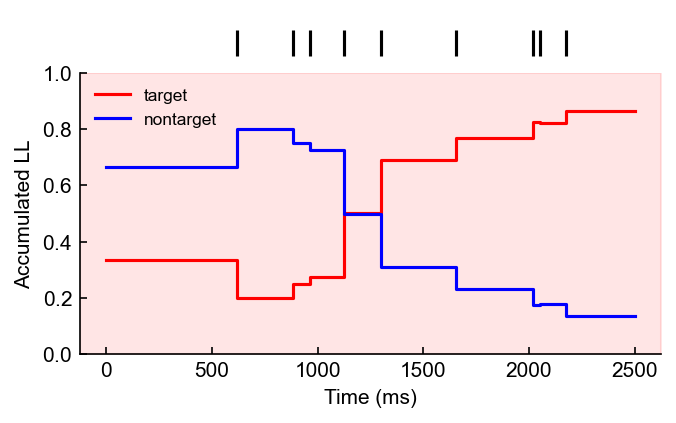

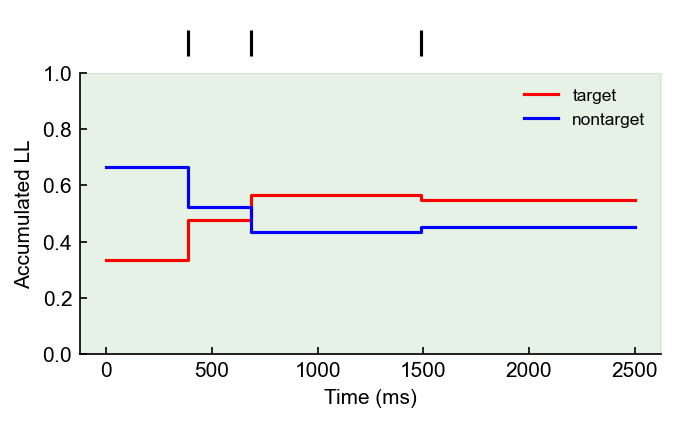

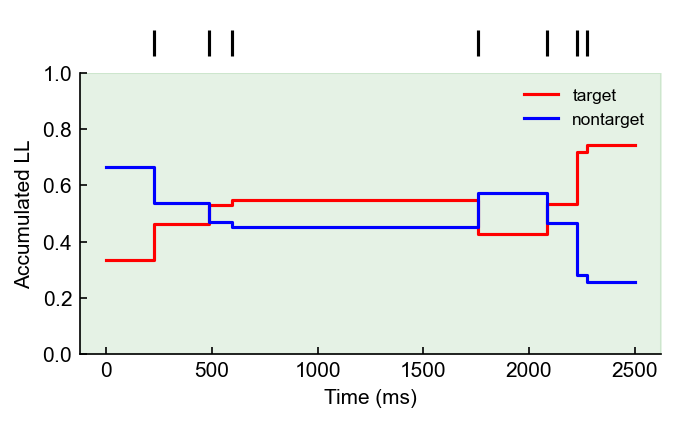

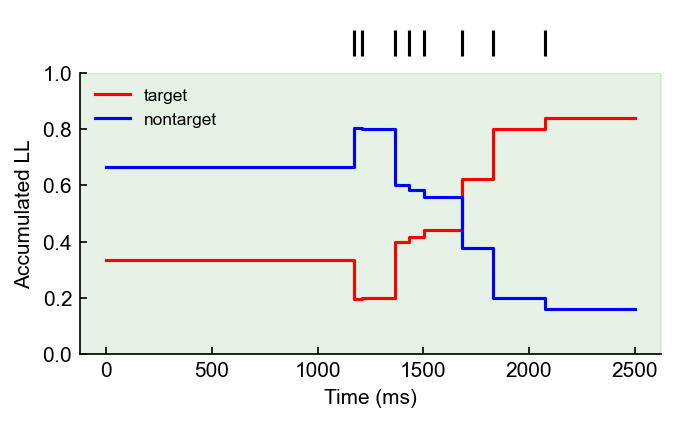

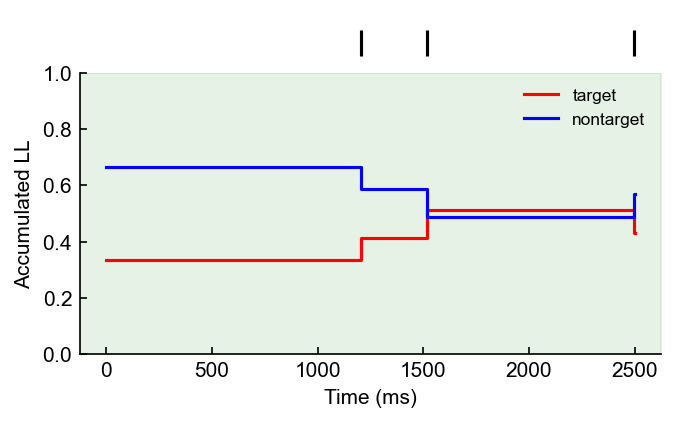

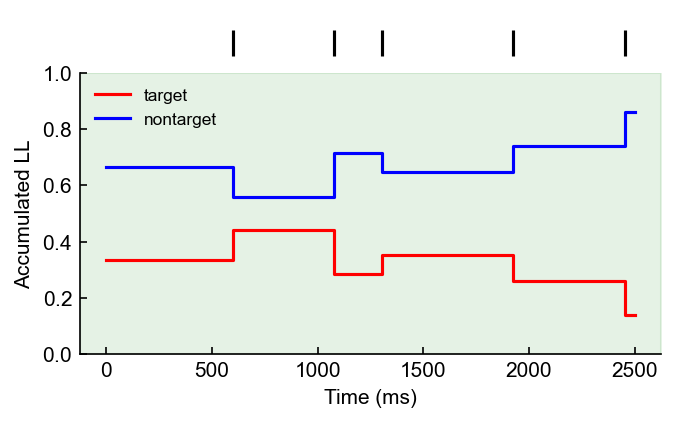

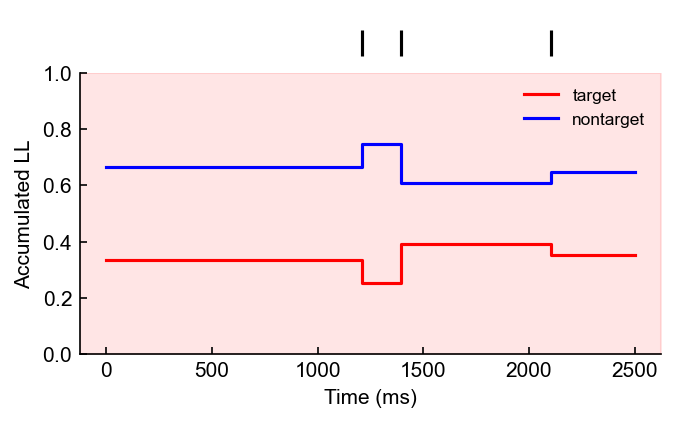

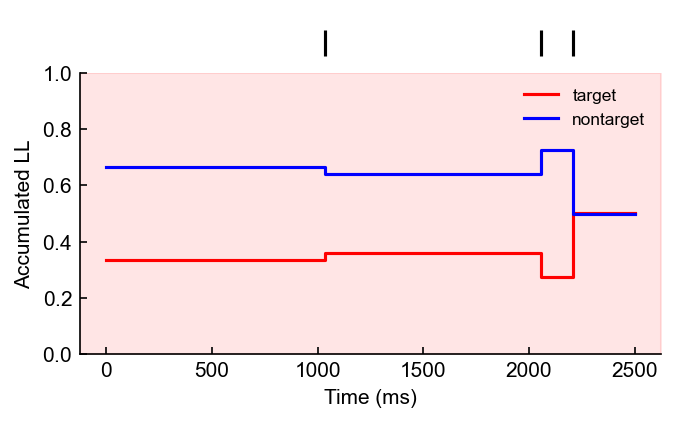

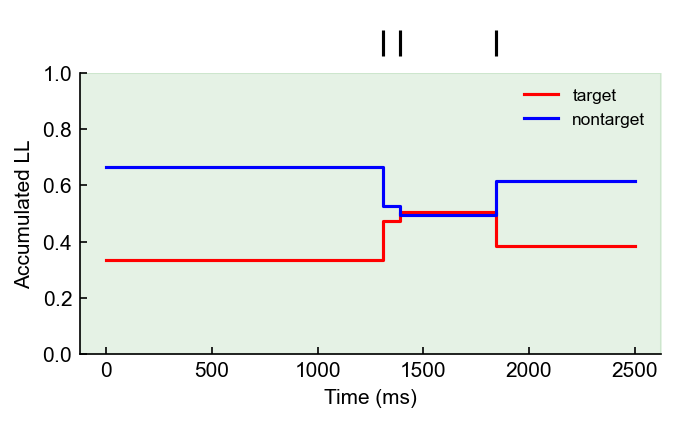

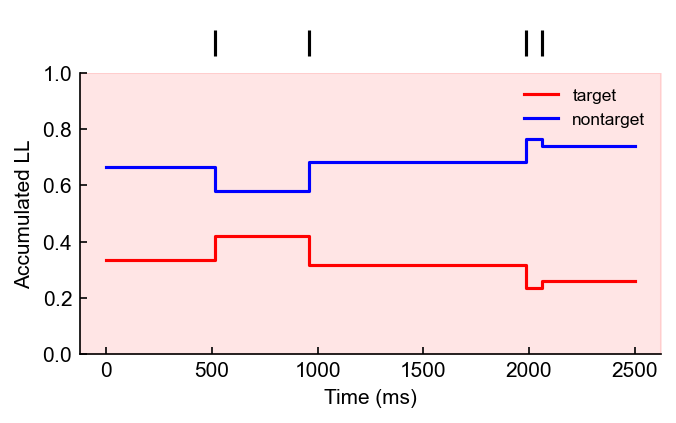

In [42]:
correct_trials = 0
incorrect_trials = 0

accumulated_correct_predictions = 0
accumulated_total_predictions = 0

clustToUse = sessionfile.clusters.good[0]

for K, (Train_X, Test_X) in enumerate(folds):
    for trial in Test_X:
        LogISIs,times = ilep.getLogISIs(sessionfile,clustToUse,[trial])
        preservedtimes = times

        if(len(LogISIs) < 3):
            continue

        posposteriors = np.zeros(len(LogISIs)+1)
        posposteriors[0] = np.log10(0.5)
        negposteriors[0] = np.log10(0.5)
        for idx,logISI in enumerate(LogISIs):
            posposteriors[idx+1] = posposteriors[idx] + np.log10(model['target_tone'].Likelihood.evaluate(logISI))
            #posposteriors[idx+1] = CalculatePosterior(posposteriors[idx],model['target_tone'],model['nontarget_tone'],logISI)
        posposteriors = np.concatenate((posposteriors,[posposteriors[len(posposteriors)-1]]))

        negposteriors = np.zeros(len(LogISIs)+1)
        for idx,logISI in enumerate(LogISIs):
            negposteriors[idx+1] = negposteriors[idx] + np.log10(model['nontarget_tone'].Likelihood.evaluate(logISI))
            #negposteriors[idx+1] = CalculatePosterior(negposteriors[idx],model['nontarget_tone'],model['target_tone'],logISI)
        negposteriors = np.concatenate((negposteriors,[negposteriors[len(negposteriors)-1]]))
        
        #Convert from W. LLRs to probabilities
        #print('Trial')
        #print(posposteriors)
        #print(negposteriors)
        #print(sum_of_probs)
        #posposteriors = np.array([ pos / sumprob for pos,sumprob in zip(posposteriors,sum_of_probs)])
        #negposteriors = np.array([ neg / sumprob for neg,sumprob in zip(negposteriors,sum_of_probs)])
        #print(posposteriors)
        #posposteriors = 10** (posposteriors - negposteriors)
        #posposteriors = posposteriors - negposteriors
        
        posposteriors = np.power(10,posposteriors)
        negposteriors = np.power(10,negposteriors)
        sum_of_probs = posposteriors + negposteriors
        posposteriors = posposteriors / sum_of_probs
        negposteriors = negposteriors / sum_of_probs

        times = np.concatenate(([0],times,[2500]))

        fig,ax = plt.subplots(figsize=(5,3))
        gs = fig.add_gridspec(2,1,height_ratios=[1,5],hspace=0.01)
        ax = plt.subplot(gs[1,0])
        ax2 = plt.subplot(gs[0,0],sharex=ax)

        ax.step(times,posposteriors,color='red',label='target',where='post')
        ax.step(times,negposteriors,color='blue',label='nontarget',where='post')
        #ax.step(times,np.power(10,posposteriors),color='red',label='target',where='post')
        #ax.step(times,np.power(10,negposteriors),color='blue',label='nontarget',where='post')
        ax.set_xticks([0,500,1000,1500,2000,2500])
        ax.set_xticklabels(['0','500','1000','1500','2000','2500'])
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Accumulated LL')

        ax2.eventplot(preservedtimes,color='k')
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        ax.legend(frameon=False)

        ax.set_ylim([0,1])
        x_axes = ax.get_xlim()
        y_axes = ax.get_ylim()
        final_idx = len(posposteriors)-1
        if posposteriors[final_idx] >= negposteriors[final_idx] and sessionfile.trials.target[trial]:
            ax.fill_between(x_axes,[y_axes[0]]*2,[y_axes[1]]*2,color='green',alpha=0.1,zorder=-10)
            correct_trials+=1
            accumulated_correct_predictions += np.abs(posposteriors[final_idx] - negposteriors[final_idx])
            accumulated_total_predictions += np.abs(posposteriors[final_idx] - negposteriors[final_idx])
        elif posposteriors[final_idx] < negposteriors[final_idx] and not sessionfile.trials.target[trial]:
            ax.fill_between(x_axes,[y_axes[0]]*2,[y_axes[1]]*2,color='green',alpha=0.1,zorder=-10)
            correct_trials+=1
            accumulated_correct_predictions += np.abs(posposteriors[final_idx] - negposteriors[final_idx])
            accumulated_total_predictions += np.abs(posposteriors[final_idx] - negposteriors[final_idx])
        else:
            ax.fill_between(x_axes,[y_axes[0]]*2,[y_axes[1]]*2,color='red',alpha=0.1,zorder=-10)
            incorrect_trials+=1
            accumulated_total_predictions += np.abs(posposteriors[final_idx] - negposteriors[final_idx])
        ax.set_xlim(x_axes)
        ax.set_ylim(y_axes)

#Potential discrepancy: correct/incorrect needs to be weighted
print('correct  : '+str(correct_trials))
print('incorrect: '+str(incorrect_trials))

print('PC: '+str(accumulated_correct_predictions/accumulated_total_predictions))

In [6]:
print(sessionfile.clusters.good)
clust = 33

[ 5  6  8 12 18 24 26 33 45 57 60 72 76 80]


In [58]:
import h5py

CACHE_DIR = 'D:\\DecodingTempFolder'
#Setup directory for storing file stuff

for file in os.listdir(CACHE_DIR):
    try:
        os.remove(os.path.join(CACHE_DIR,file))
    except:
        pass
    try:
        os.rmdir(os.path.join(CACHE_DIR,file))
    except:
        pass
    
directory = CACHE_DIR
run_name = 'temporary_filename'
this_folder = os.path.join(directory,run_name)
os.mkdir(os.path.join(this_folder))

In [20]:
a = np.array(list(range(10)))
b = np.array(list(range(10)))+20

for a2,b2 in zip(a,b):
    print(str(a2)+' '+str(b2))
    
print(a+b)

0 20
1 21
2 22
3 23
4 24
5 25
6 26
7 27
8 28
9 29
[20 22 24 26 28 30 32 34 36 38]


In [27]:
10**( np.log10(5) + np.log10(5))

25.000000000000007

In [28]:
5*5

25